#### Select and create InSAR interferograms with ASF Search 
version 1 look 
cut pairs to area of interest, not overlapIntersect
do not omit seasons
short time spans only

2025/05/21 make small test case to debug pyaps
2025/06/06 use UTM zones consistently
2025/06/09 try to generalize

 #### 0. Initial Setup

To run this notebook, you'll need a conda environment with the required dependencies. You can set up a new environment (recommended) and run the jupyter server like:
```shell
mamba create --name hyp3-mintpy "python>=3.10" "asf_search>=7.0.0" hyp3_sdk "mintpy>=1.5.2" pandas jupyter ipympl jupytext gdal proj  --channel conda-forge --yes
```

mamba run -n hyp3kf jupytext --to py hyp3_insar_stack_for_ts_v1.ipynb

To run in VS Code, then use command palette to do the following:
    Clear Workspace Interpreter Setting
    Select interpreter
        Type interpreter
            
   ~/miniforge3/envs/hyp3-mintpy/bin/python

In [140]:
from pathlib import Path
from dateutil.parser import parse as parse_date
import datetime
import asf_search as asf
import pandas as pd
import hyp3_sdk as sdk
from pathlib import Path
from typing import List, Union

#from osgeo import gdal # Import "osgeo" could not be resolved
from osgeo import gdal, osr
#import gdal 
import numpy as np
import shapely 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pyproj import Proj, transform, CRS, Transformer
import os
import argparse
import re
from dateutil.parser import parse as parse_date
import datetime
import sys








In [141]:
def get_site_dims(sitecode5):
    """
    Return bounding box and UTM limits from site_dims.txt for given 5-character site code.
    Equivalent to MATLAB function by Kurt Feigl (2021/10/18).
    """
    home = os.environ.get('HOME')
    fname = os.path.join(home, 'site_dims.txt')

    LIMITS = {}
    try:
        with open(fname, 'rt') as fid:
            lines = fid.readlines()

        i = 0
        while i < len(lines):
            tline = lines[i].strip()
            if len(tline) == 6 and ':' in tline and tline[:5].lower() == sitecode5.lower():
                # Found matching site
                if i + 3 >= len(lines):
                    raise ValueError("Insufficient lines after match in file.")

                # Line 1: lat/lon
                latlon_line = lines[i+1].strip().replace('-R', '').replace('/', ',')
                lonMin, lonMax, latMin, latMax = map(float, latlon_line.split(','))
                LIMITS['lonMin'] = lonMin
                LIMITS['lonMax'] = lonMax
                LIMITS['latMin'] = latMin
                LIMITS['latMax'] = latMax

                # Line 2: UTM
                utm_line = lines[i+2].strip().replace('-R', '').replace('/', ',')
                Emin, Emax, Nmin, Nmax = map(float, utm_line.split(','))
                LIMITS['Emin'] = Emin
                LIMITS['Emax'] = Emax
                LIMITS['Nmin'] = Nmin
                LIMITS['Nmax'] = Nmax

                # Line 3: UTM zone
                utm_zone_line = lines[i+3].strip()
                LIMITS['UTMzone'] = int(utm_zone_line)
                break

            i += 1

        if not LIMITS:
            raise ValueError(f"Site code {sitecode5} not found in {fname}")

        return LIMITS

    except FileNotFoundError:
        raise FileNotFoundError(f"Could not open file named {fname}")




In [142]:
# function to calculate the day of the year

def day_of_year(date):
    #print(f"date is {date}")
    #print(f'type of date is {type(date)}')
    if type(date) == type(datetime.datetime(2024,8,29)):
        doy = date - datetime.datetime(date.year, 1, 1,tzinfo=date.tzinfo) + datetime.timedelta(days=1)
    elif type(date) == type('hello'):
        date1=parse_date(date)
        doy = date1 - datetime.datetime(date1.year, 1, 1, tzinfo=date1.tzinfo) + datetime.timedelta(days=1)
    elif type(date) == 'pandas.core.series.Series':
        nDates=len(date)
        print(f"nDates is {nDates}")
    
    else:
        print(f"Error")
        doy=None
        raise Exception
    return doy.days

def plot_lola(dateStr0,dateStr1,AOIlola,lonCenter,latCenter,work_dir):
    # Plot the rectangle
    #plt.figure()
    fig, ax = plt.subplots()
    plt.plot([en[0] for en in AOIlola], [EN[1] for EN in AOIlola], marker='o', linestyle='-')
    plt.plot(lonCenter,latCenter,marker='*',color='magenta',markersize=24)
    #plt.fill([EN[0] for EN in AOIlola], [EN[1] for EN in AOIlola], alpha=0.2, color='blue')
    fig.suptitle(f"{work_dir}")
    plt.title(f"{dateStr0} to {dateStr1}")
    plt.xlabel("Longitude",fontsize=9)
    plt.ylabel("Latitude",fontsize=9)
    plt.grid(True)
    # Format tick labels to show 3 decimal places
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)

    mean_lat = np.radians(np.mean([lola[1] for lola in AOIlola]))
    aspect_ratio = 1 / np.cos(mean_lat)

    ax.set_aspect(aspect_ratio)
    fig.savefig('search1lola.png',dpi=600)
    # Display the plot
    #fig.show()
    plt.show(block=False)
    
    return

### 3.1 Subset all GeoTIFFs to their common overlapIntersect

In [143]:
def get_epsg(file_path): 
        dataset = gdal.Open(file_path)
        wkt_crs = dataset.GetProjection()
        #print(f"{wkt_crs}")

        # Optional: Parse it into a spatial reference object
        srs = osr.SpatialReference()
        srs.ImportFromWkt(wkt_crs)

        #wkt = dataset.GetProjection()

        # Try getting the EPSG code
        epsg = srs.GetAuthorityCode(None)
        #print(f"epsg: {epsg} wkt_crs {wkt_crs} {file_path}")
        
        return epsg



In [144]:
def clip_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float]) -> None:
    """Clip all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-tight y
            corner coordinates of the common overlap
    Returns: None
    """

    # 2025/06/11 add two more files
    files_for_mintpy = ['_water_mask.tif',
                        '_corr.tif',
                        '_conncomp.tif',
                        '_unw_phase.tif',
                        '_dem.tif',
                        '_lv_theta.tif',
                        '_lv_phi.tif'
                        '_los_rdr', 
                        '_wrapped_phase.tif']

    for extension in files_for_mintpy:

        for file in data_dir.rglob(f'*{extension}'):

            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'

            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [145]:
def find_zip_files(directory):
    # Compile the regex pattern to match .zip files
    pattern = re.compile(r'.*\.zip$')

    # List all files in the directory
    all_files = os.listdir(directory)

    # Filter and return files that match the pattern
    zip_files = [f for f in all_files if pattern.match(f)]
    return zip_files


In [146]:
def warp_hyp3_products_to_common_overlap(data_dir: Union[str, Path], overlap: List[float],epsgAOI) -> None:
    """Warp all GeoTIFF files to their common overlap
    
    Args:
        data_dir:
            directory containing the GeoTIFF files to clip
        overlap:
            a list of the upper-left x, upper-left y, lower-right-x, and lower-right y
            corner coordinates of the common overlap
    Returns: None
    """

    # Define bounding box in target EPSG coordinates: (minX, minY, maxX, maxY)
    #output_bounds = (500000, 4700000, 510000, 4710000)
    
    # Transform bounds to target CRS (e.g., EPSG:32616)
    # transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
    # xmin_t, ymin_t = transformer.transform(xmin, ymin)
    # xmax_t, ymax_t = transformer.transform(xmax, ymax)

    output_bounds = (overlap[0], overlap[3], overlap[2], overlap[1])

    # 2025/06/06 add los_rdr in hopes that it contains bperp info
    # 2025/06/10 add _wrapped_phase.tif 
    files_for_mintpy = ['_water_mask.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif', '_los_rdr', '_wrapped_phase.tif']

    for extension in files_for_mintpy:

        for file in data_dir.rglob(f'*{extension}'):
            dst_file = file.parent / f'{file.stem}_clipped{file.suffix}'
            # file.name → full file name with extension (e.g., "example.txt")
            # file.stem → file name without extension (e.g., "example")
            # file.suffix → extension only (e.g., ".txt")
            epsgTIF1=get_epsg(file)
            print(f"Warping EPSG from {epsgTIF1} to {epsgAOI} on {file.name} to {dst_file.name}")
            gdal.Warp(srcDSOrSrcDSTab=str(file), 
                      destNameOrDestDS=str(dst_file), 
                      dstSRS=f"EPSG:{epsgAOI}", 
                      outputBounds=output_bounds, 
                      dstNodata=0, 
                      )
    
    return









In [147]:
def plot_utm(dateStr0,dateStr1,AOIlola,UTMzone,work_dir):

    # Create a projection object for UTM zone (you need to specify the zone)
    #UTMprojectionFunction = Proj(proj="utm", zone=11, ellps="WGS84", south=False)
    UTMprojectionFunction = Proj(proj="utm", zone=UTMzone, ellps="WGS84", south=False)
    print(f"{UTMprojectionFunction}")

    # Convert to CRS and get EPSG code
    crsAOI = CRS.from_proj4(UTMprojectionFunction.srs)
    epsgAOI = crsAOI.to_epsg()
    print(f"for AOI: EPSG code: {epsgAOI} CRS code {crsAOI} ")


    # Project the lat/lon coordinates into UTM
    AOIutm = [UTMprojectionFunction(lon, lat) for lon, lat in AOIlola]
    #ENcenter = UTMprojectionFunction(lonCenter, latCenter)

    # define the bounding box
    # larger SANEM
    #epsgAOI=32611 # UTM Zone 11 
    #bBoxAOI = [291074.4825013202, 4480500.202558111, 298595.532410652, 4469090.405787393] 
    # widen eastward to include GPS station GARL
    # Eref =     300196.97
    # Nref =    4476704.85

    #bBoxAOI = [291.E3, 4480.E3, 301.E3, 4470.E3] 
    ulx = np.floor(min([corner[0] for corner in AOIutm]))
    uly = np.ceil(max([corner[1] for corner in AOIutm]))
    lrx = np.ceil(max([corner[0] for corner in AOIutm]))
    lry = np.floor(min([corner[1] for corner in AOIutm]))
    bBoxAOI=[ulx, uly, lrx, lry]

    print(f"bBoxAOI is {bBoxAOI}")

    # Plot the UTM rectangle
    #plt.figure()
    fig, ax = plt.subplots()
    plt.plot([EN[0]/1000. for EN in AOIutm], [EN[1]/1000. for EN in AOIutm], marker='o', linestyle='-',label='AOI')
    plt.fill([EN[0]/1000. for EN in AOIutm], [EN[1]/1000. for EN in AOIutm], alpha=0.2, color='blue')
    #plt.plot(ENcenter[0]/1000., ENcenter[1]/1000, marker='*', color='magenta',linestyle=None)
    plt.suptitle(f"{work_dir} \n {dateStr0} to {dateStr1}", fontsize=9)
    plt.title(f"EPSG code: {epsgAOI} \n CRS code {crsAOI}", fontsize=9)
    plt.xlabel("UTM Easting [km]")
    plt.ylabel("UTM Northing [km]")
    # Format tick labels to show 0 decimal places
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    plt.grid(False)
    ax.set_aspect('equal', 'box')
    # Place legend outside to the upper right
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()  # Adjust layout to prevent clipping

    # save the plot, then show it
    plt.savefig('search1utm.png',dpi=600)
    plt.show(block=False)
    
    return [AOIutm,bBoxAOI,epsgAOI,UTMprojectionFunction]

In [148]:
def main():
    parser = argparse.ArgumentParser(description="Script with debug/--no-debug switch.")
    parser.add_argument("--site", dest="site",     default="BRADY", help="name of site as 5-character upper-case word")
    parser.add_argument("--name", dest="project_name", default="mintpy60", help="label for solution")
    parser.add_argument("--aord", dest="aord",     default="ASCENDING", help="flight direction ASCENDING or DESCENDING")
    parser.add_argument("--t0",   dest="dateStr0", default="2020-01-01", help="start date in format YYYY-MM-DD")
    parser.add_argument("--t1",   dest="dateStr1", default="2020-12-31", help="end   date in format YYYY-MM-DD")
 
    debug_group = parser.add_mutually_exclusive_group()
    debug_group.add_argument('--debug', dest='debug', action='store_true', help="Enable debug mode")
    debug_group.add_argument('--no-debug', dest='debug', action='store_false', help="Disable debug mode")
    parser.set_defaults(debug=False)  # Default is --no-debug

    args = parser.parse_args()

    if args.debug:
        print(f"Debug is on")
    else:
        print("Debug mode is OFF")
        
    return

In [149]:




# Main logic here
#
## set main controlling parameters here
project_name = 'mintpy61'
burstORslc='BURST'
site = 'BRADY'
aord = asf.FLIGHT_DIRECTION.ASCENDING
burstORslc == 'BURST'
dateStr0='2017-01-01'
dateStr1='2024-12-31'
debug=True

# set up directories
if os.path.isdir('/Volumes/feigl/insar'):
    topPath='/Volumes/feigl/insar'
elif os.path.isdir('/data/insar'):
    topPath='/data/insar'

# working directory
work_dir = Path(topPath) / site / 'SDK' / aord / project_name
work_dir.mkdir(parents=True, exist_ok=True)
print(f"Changing working directory to {work_dir}")  
os.chdir(work_dir)

# data directory
data_dir = work_dir / 'data'
data_dir.mkdir(parents=True, exist_ok=True)
print(f"data_dir is {data_dir}")


Changing working directory to /Volumes/feigl/insar/BRADY/SDK/ASCENDING/mintpy61
data_dir is /Volumes/feigl/insar/BRADY/SDK/ASCENDING/mintpy61/data


In [150]:
# Use your [NASA Earthdata login](https://urs.earthdata.nasa.gov/) 
# to connect to [ASF HyP3](https://hyp3-docs.asf.alaska.edu/).
#hyp3 = sdk.HyP3(prompt=True)
hyp3 = sdk.HyP3(prompt=False)
#hyp3 =  sdk.HyP3.get_authenticated_session('feigl@wisc.edu')
nCredits0=hyp3.check_credits()
print(f'Number of credits before starting jobs is {nCredits0}')

Number of credits before starting jobs is 9973


{'lonMin': -119.03, 'lonMax': -118.99, 'latMin': 39.78, 'latMax': 39.82, 'Emin': 326160.0, 'Emax': 329680.0, 'Nmin': 4405200.0, 'Nmax': 4409800.0, 'UTMzone': 11}
-119.03000000
11
UTMzone is 11
centerAOIWKT is POINT(-119.00999999999999 39.8)


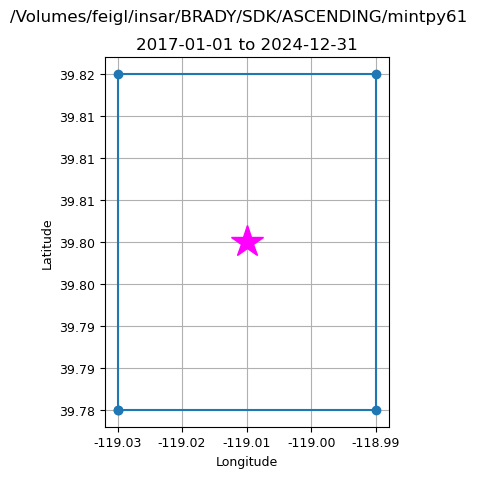

proj=utm zone=11 ellps=WGS84 units=m no_defs
for AOI: EPSG code: 32611 CRS code +proj=utm +zone=11 +ellps=WGS84 +units=m +no_defs +type=crs 
bBoxAOI is [np.float64(326158.0), np.float64(4409751.0), np.float64(329683.0), np.float64(4405233.0)]


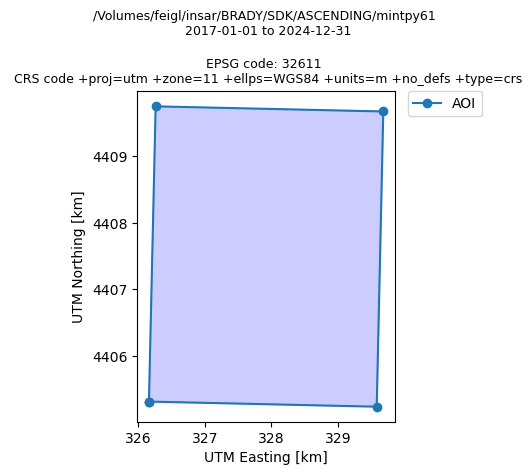

Debug mode is ON. Continuing bravely onward.


In [151]:
LIMITS=get_site_dims(site)
print(f"{LIMITS}")
print(f"{LIMITS['lonMin']:12.8f}")
print(f"{LIMITS['UTMzone']}")

if site == 'DCAMP':
    # The DAC is expanded to encompass GVR (78 km2) 
    # -118.3591409949927,38.81917034951293,0 -118.2245378112751,38.82065893511532,0 -118.2251891413302,38.88085324203438,0 -118.3605156707135,38.87935480699949,0 -118.3591409949927,38.81917034951293,0 
    # corner	lon	lat	ground
    # SW	-118.35914099	38.81917035	0
    # B	    -118.22453781	38.82065894	0
    # NE	-118.22518914	38.88085324	0
    # D	    -118.36051567	38.87935481	0
    # mean	-118.29234590	38.85000933	0
    latMin=38.81917035
    latMax=38.88085324
    lonMin=-118.36051567
    lonMax=-118.22453781
    UTMzone=11 # 11 S verified by Google Earth
elif site == 'SANEM':
    # original AOI
    #  grep -A3 sanem ~/siteinfo/site_dims.txt  
    # sanem:
    # -R-119.46/-119.375/40.348/40.449
    # -R291074.48226/298595.53221/4469090.38971/4480500.18609
    # 11
    # latMin=40.348
    # latMax=40.449
    # lonMin=-119.46
    # lonMax=-119.375 
    
    # larger AOI from /Users/feigl/siteinfo/sanem/AOIforSANEM2025.kml  
    # -119.5086551479411,40.3051742449493,0
    # -119.3250213982107,40.30569311996287,0
    # -119.3270788642407,40.50172708513533,0
    # -119.5083119649335,40.5004502253031,0
    # -119.5086551479411,40.3051742449493,0
    latMin=40.30517424494930
    latMax=40.50172708513533
    lonMin=-119.5086551479411
    lonMax=-119.3250213982107
    UTMzone=11      # 2025/06/05  verified by Google Earth
elif site == 'MCGIN':
    UTMzone=11 # 11 S verified by Google Earth
    assert False
elif site == 'BRADY':
    UTMzone=LIMITS['UTMzone']
    LIMITS=get_site_dims(site)
    # 
    lonMin=LIMITS['lonMin'] 
    lonMax=LIMITS['lonMax'] 
    latMin=LIMITS['latMin'] 
    latMax=LIMITS['latMax']
    # # expand by 10 km - fails
    # lonMin=LIMITS['lonMin'] - 10/111.
    # lonMax=LIMITS['lonMax'] + 10/111.
    # latMin=LIMITS['latMin'] - 10/111.
    # latMax=LIMITS['latMax'] + 10/111.
    #print(f"{LIMITS['lonMin']:12.8f}")
    
else:
    print(f"WARNING unknown site {site}")
    UTMzone=LIMITS['UTMzone']
    LIMITS=get_site_dims(site)
    lonMin=LIMITS['lonMin']
    lonMax=LIMITS['lonMax']
    latMin=LIMITS['latMin']
    latMax=LIMITS['latMax']

print(f"UTMzone is {UTMzone}")   
lonCenter=(lonMin + lonMax)/2
latCenter=(latMin + latMax)/2
# format is intersectsWith='POINT(-119.543 37.925)'
centerAOIWKT=f'POINT({lonCenter} {latCenter})'
print(f"centerAOIWKT is {centerAOIWKT}")

# Define the four corners
AOIlola = [
    [lonMin, latMin],  # Bottom-left corner
    [lonMax, latMin],  # Bottom-right corner
    [lonMax, latMax],  # Top-right corner
    [lonMin, latMax],  # Top-left corner
    [lonMin, latMin]   # Close the loop by returning to bottom-left
]

# make plots
plot_lola(dateStr0,dateStr1,AOIlola,lonCenter,latCenter,work_dir)
AOIutm,bBoxAOI,epsgAOI,UTMprojectionFunction = plot_utm(dateStr0,dateStr1,AOIlola,UTMzone,work_dir)


if debug:
    print("Debug mode is ON. Continuing bravely onward.")
else:
    print("Debug mode is OFF. Continuing bravely onward.")  
    #sys.exit(f"Debug mode is off. Exiting here.")
    


In [152]:
print(f"timeout is now {asf.constants.INTERNAL.CMR_TIMEOUT} seconds")
asf.constants.INTERNAL.CMR_TIMEOUT=120
print(f"timeout is now {asf.constants.INTERNAL.CMR_TIMEOUT}: seconds")

if burstORslc == 'BURST':
    processingLevel=asf.PRODUCT_TYPE.BURST
# elif burstORslc == 'MULTIBURST':
#     processingLevel=asf.PRODUCT_TYPE.BURST
elif burstORslc == 'SLC':
    processingLevel=asf.PRODUCT_TYPE.SLC
else:
    assert False # throw an error
ProductsFound = asf.geo_search(
        platform=asf.PLATFORM.SENTINEL1,
        intersectsWith=centerAOIWKT,
        start=dateStr0,
        end  =dateStr1,        
        processingLevel=processingLevel,
        polarization=asf.POLARIZATION.VV, 
        beamMode=asf.BEAMMODE.IW,
        flightDirection=aord,
    )
        # season=season,


nProducts=len(ProductsFound)
print(f'nProducts = {nProducts}')

timeout is now 120 seconds
timeout is now 120: seconds


/var/folders/f7/rqlcjcxn66z5p_drv3rk550w0002v2/T/ipykernel_83686/3170821774.py:13: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  ProductsFound = asf.geo_search(
/var/folders/f7/rqlcjcxn66z5p_drv3rk550w0002v2/T/ipykernel_83686/3170821774.py:13: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  ProductsFound = asf.geo_search(


nProducts = 301


In [153]:
    # make sure scene or burst overlapUnions with all 4 corners of the AOI
    point= shapely.wkt.loads(centerAOIWKT)

    # Plot the AOI rectangle in lon, lat
    #print(f'{AOIlola}')
    #print(f'{coordinates}')
    # plt.figure()
    # plt.plot([point[0] for point in AOIlola], [point[1] for point in AOIlola], marker='o', linestyle='-')
    # plt.fill([point[0] for point in AOIlola], [point[1] for point in AOIlola], alpha=0.2, color='blue')
    # plt.plot(lonCenter,latCenter,marker='*',color='magenta',markersize=12)

    for product in ProductsFound: 
        coordsLOLA=product.geometry['coordinates']
        polygon = shapely.Polygon(coordsLOLA[0])
        for corner in AOIlola:
            point = shapely.Point(corner)
        
        # plot the coordinates for this scene
        #plt.plot([point[0] for point in coordsLOLA[0]], [point[1] for point in coordsLOLA[0]], marker='+', linestyle='-')

    # plt.suptitle(f"{work_dir}")
    # plt.title(f"{dateStr0} to {dateStr1}")
    # plt.xlabel("UTM Easting [km]")
    # plt.ylabel("UTM Northing [km]")
    # # Format tick labels to show 3 decimal places
    # #plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    # #plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))
    # plt.grid(False)
    # # save the plot, then show it
    # plt.savefig('search1utm.png',dpi=600)
    # plt.show()

In [154]:
    # map coverage in UTM
    # Project the lat/lon coordinates into UTM
    AOIutm = [UTMprojectionFunction(lon, lat) for lon, lat in AOIlola]

    # #plt.figure()
    # fig, ax = plt.subplots()

    # plt.plot([point[0]/1000 for point in AOIutm], [point[1]/1000 for point in AOIutm], marker='o', linestyle='-')
    # plt.fill([point[0]/1000 for point in AOIutm], [point[1]/1000 for point in AOIutm], alpha=0.2, color='blue',label='AOI')
    # #plt.plot(ENcenter[0]/1000,ENcenter[1]/1000,marker='*',color='magenta',markersize=12,label='AOI center')

    nKeep=0
    nSkip=0
    #granulesKept=empty_object = type(granulesFound)()
    ProductsKept = empty_object = type(ProductsFound)()
    for product in ProductsFound: 
        print(f"{product.properties['sceneName']}")  
        #print(f"{granule.geometry['coordinates'][0][0]}")
        #polygon=shapely.wkt.loads(granule.geometry['coordinates'])
        coordsLOLA=product.geometry['coordinates']
        #print(f'{coordsLOLA}')
        coordsUTM=[UTMprojectionFunction(lola[0],lola[1]) for lola in coordsLOLA[0]]
        
        #print(f'{coordsUTM}')
        polygon = shapely.Polygon(coordsUTM)
        #print(f'{polygon}')
    
        mKeep=0
        mSkip=0 
        for corner in AOIutm:
            #print(f'{corner}')
            point = shapely.Point(corner)
            #print(f'point is {point}')
            # Check for intersection
            if point.intersects(polygon):
                #print(f"The point intersects the polygon.")
                mKeep=mKeep+1
            else:
                #print(f"The point does not intersect the polygon.")
                mSkip=mSkip+1
                
        #print(f"mKeep = {mKeep} mSkip = {mSkip}")       
        if mKeep >=2:
            nKeep=nKeep+1
            ProductsKept.append(product)
        else:
            nSkip=nSkip+1
        
        # plot the coordinates for this scene
        #plt.plot([point[0]/1000 for point in coordsUTM], [point[1]/1000 for point in coordsUTM], marker='+', linestyle='-')
        #ax.set_aspect('equal', 'box')

    # #plt.title(f"{granule.properties['sceneName']}")
    # plt.suptitle(f"{work_dir}")
    # plt.title(f"{dateStr0} to {dateStr1} nKeep = {nKeep} nSkip = {nSkip}")
    # plt.xlabel("UTM Easting [km]")
    # plt.ylabel("UTM Northing [km]")
    # plt.grid(True)
    # plt.savefig('search2.png')
    # # Display the plot
    # plt.show()

    print(f"Number of products found is {len(ProductsFound)}")
    print(f"Number of products kept  is {len(ProductsKept)}")
    print(f"nKeep  is                   {nKeep}")
    #print(f"{granulesKept[0]}")
    # for product in ProductsKept:
    #     #print(f"{granule.properties['sceneName']}")  
    #     # OK  print(f"{product.properties}")  
    #     # OK  print(f"{product.properties['burst']}")
    #     prop1=product.properties['burst']
    #     #print(f"{prop1}")
    #     print(f"{prop1['burstIndex']}") 

S1_135553_IW2_20241228T015218_VV_9A47-BURST
S1_135553_IW2_20241216T015219_VV_F3FE-BURST
S1_135553_IW2_20241204T015220_VV_BB7D-BURST
S1_135553_IW2_20241122T015221_VV_CB20-BURST
S1_135553_IW2_20241110T015221_VV_6F70-BURST
S1_135553_IW2_20241029T015222_VV_EF97-BURST
S1_135553_IW2_20241017T015222_VV_AB3A-BURST
S1_135553_IW2_20241005T015221_VV_2A96-BURST
S1_135553_IW2_20240923T015221_VV_3A3C-BURST
S1_135553_IW2_20240911T015221_VV_10D2-BURST
S1_135553_IW2_20240830T015221_VV_EDF8-BURST
S1_135553_IW2_20240818T015220_VV_B5A6-BURST
S1_135553_IW2_20240806T015220_VV_E52D-BURST
S1_135553_IW2_20240725T015220_VV_45F5-BURST
S1_135553_IW2_20240713T015221_VV_8C88-BURST
S1_135553_IW2_20240701T015221_VV_2A81-BURST
S1_135553_IW2_20240619T015222_VV_A504-BURST
S1_135553_IW2_20240526T015223_VV_8D37-BURST
S1_135553_IW2_20240514T015222_VV_DE01-BURST
S1_135553_IW2_20240502T015223_VV_9719-BURST
S1_135553_IW2_20240420T015223_VV_1328-BURST
S1_135553_IW2_20240408T015222_VV_3DB6-BURST
S1_135553_IW2_20240327T015221_VV

In [155]:
    print(f'asf.constants.INTERNAL.CMR_TIMEOUT is {asf.constants.INTERNAL.CMR_TIMEOUT} seconds')
    asf.constants.INTERNAL.CMR_TIMEOUT=120
    print(f'asf.constants.INTERNAL.CMR_TIMEOUT is {asf.constants.INTERNAL.CMR_TIMEOUT} seconds')

    # make a stack of epochs
    print(f"number of products is {len(ProductsKept)}")
    # This will make a stack of ALL possible pairs that use last epoch as reference
    EpochsAll = asf.baseline_search.stack_from_product(ProductsKept[-1])
    # print(f"{StackAll.Properties.values}")
                                                                
    nStackAll = len(EpochsAll)
    print(f"nStackAll is {nStackAll}")


    # trim list of epochs
    t0 = parse_date(dateStr0 + ' 00:00:00Z')
    t1 = parse_date(dateStr1 + ' 23:59:59Z')
 
    EpochsSub=empty_object=type(EpochsAll)()
    for Epoch0 in EpochsAll:
        #print(f"baseline is {baseline}")
        if ((parse_date(Epoch0.properties['startTime']) >= t0) 
            and (parse_date(Epoch0.properties['stopTime']) <= t1) 
            and Epoch0.properties['perpendicularBaseline'] != None):
            EpochsSub.append(Epoch0)
        
    nStackSub=len(EpochsSub)
    print(f"nStackSub is {nStackSub}")

    # for Epoch0 in EpochsSub:
    #     #print(f"{Epoch0.properties}") 
    #     print(f"{Epoch0.properties['startTime']} {Epoch0.properties['temporalBaseline']:5d}days {Epoch0.properties['perpendicularBaseline']:10.1f}m {Epoch0.properties['burst']['fullBurstID']}")




asf.constants.INTERNAL.CMR_TIMEOUT is 120 seconds
asf.constants.INTERNAL.CMR_TIMEOUT is 120 seconds
number of products is 301
nStackAll is 345
nStackSub is 300


In [156]:
    # start building set of pairs

    minTemporalBaseline = 5      # days
    maxTemporalBaseline = 100    # days # must be greater than excluded season
    maxPerpendicularBaseline = 100 # meters
    
    ## consider season - causes problems
    # take whole year
    doy1=1
    doy2=366
    # exclude January and February
    #doy1 = day_of_year(parse_date('2023-03-01'))
    #doy2 = day_of_year(parse_date('2023-12-31'))
    # take Summer only
    # doy1 = day_of_year(parse_date('2023-06-01'))
    # doy2 = day_of_year(parse_date('2023-08-31'))
    season = [doy1,doy2]
    # print(f"season is {season}")


    Pairs = set()
    # make a set adding to the end
    for Epoch0 in EpochsSub:
        #print(f"{Epoch0.properties}") 

        rN=Epoch0.properties['sceneName']             # long name of burst granule
        rt=Epoch0.properties['temporalBaseline']      # days from first epoch for reference
        rB=Epoch0.properties['perpendicularBaseline'] # meters from first epoch for reference
        rd=day_of_year(parse_date(Epoch0.properties['startTime'])) # day of year 
        rS=Epoch0.properties['burst']['subswath']
        ri=Epoch0.properties['burst']['burstIndex']           # 5, 6, 7
        rF=Epoch0.properties['burst']['fullBurstID']
        
        for Epoch1 in EpochsSub:
            sN=Epoch1.properties['sceneName']             # long name of burst granule
            st=Epoch1.properties['temporalBaseline']      # days from first epoch for reference
            sB=Epoch1.properties['perpendicularBaseline'] # meters from first epoch for reference
            sd=day_of_year(parse_date(Epoch1.properties['startTime'])) # day of year 
            sS=Epoch1.properties['burst']['subswath']   # 'IW1' 'IW2' or 'IW3'
            si=Epoch1.properties['burst']['burstIndex']           # 5, 6, 7
            sF=Epoch1.properties['burst']['fullBurstID']
            
        
            if ((sN != rN) and (si == ri) and (sS == rS) and (sF == rF)
                and (abs(sB - rB) < maxPerpendicularBaseline)
                and (st - rt <= maxTemporalBaseline)
                and (st - rt >  minTemporalBaseline)
                and (rd >= season[0])
                and (rd <= season[1])
                ):
                print(f"{rN}, {sN}, {abs(sB - rB):10.1f}m, {(st-rt):5d}days {ri}, {rS}, {rF}")
                Pairs.add((rN,sN) )
                
    
        
    nPairs=len(Pairs)
    print(f'number of pairs nPairs = {nPairs}')





S1_135553_IW2_20170109T015059_VV_B837-BURST, S1_135553_IW2_20170115T015140_VV_514D-BURST,       15.0m,     6days 8, IW2, 064_135553_IW2
S1_135553_IW2_20170109T015059_VV_B837-BURST, S1_135553_IW2_20170121T015058_VV_F2BC-BURST,       42.0m,    12days 8, IW2, 064_135553_IW2
S1_135553_IW2_20170109T015059_VV_B837-BURST, S1_135553_IW2_20170202T015058_VV_81DD-BURST,        5.0m,    24days 8, IW2, 064_135553_IW2
S1_135553_IW2_20170109T015059_VV_B837-BURST, S1_135553_IW2_20170208T015140_VV_FD77-BURST,        4.0m,    30days 8, IW2, 064_135553_IW2
S1_135553_IW2_20170115T015140_VV_514D-BURST, S1_135553_IW2_20170121T015058_VV_F2BC-BURST,       27.0m,     6days 8, IW2, 064_135553_IW2
S1_135553_IW2_20170115T015140_VV_514D-BURST, S1_135553_IW2_20170202T015058_VV_81DD-BURST,       20.0m,    18days 8, IW2, 064_135553_IW2
S1_135553_IW2_20170115T015140_VV_514D-BURST, S1_135553_IW2_20170208T015140_VV_FD77-BURST,       19.0m,    24days 8, IW2, 064_135553_IW2
S1_135553_IW2_20170121T015058_VV_F2BC-BURST, S1_

In [157]:
    costs=hyp3.costs()
    print(f"costs is of type {type(costs)}")
    print(f"{costs}")
    for cost in costs:
        print(f"{cost}")
    #     for p in cost:
    #         print(p,end="\n")
    #     print()
        

    


costs is of type <class 'dict'>
{'AUTORIFT': {'cost': 50}, 'INSAR_GAMMA': {'cost_parameters': ['looks'], 'cost_table': {'20x4': 10, '10x2': 15}}, 'RTC_GAMMA': {'cost_parameters': ['resolution'], 'cost_table': {'30': 5, '20': 15, '10': 60}}, 'INSAR_ISCE_BURST': {'cost': 1}, 'INSAR_ISCE_MULTI_BURST': {'cost_parameters': ['looks', 'reference'], 'cost_table': {'20x4': {'1': 1, '2': 1, '3': 1, '4': 1, '5': 5, '6': 5, '7': 5, '8': 5, '9': 5, '10': 5, '11': 5, '12': 5, '13': 5, '14': 5, '15': 5}, '10x2': {'1': 1, '2': 1, '3': 1, '4': 5, '5': 5, '6': 5, '7': 5, '8': 5, '9': 5, '10': 10, '11': 10, '12': 10, '13': 10, '14': 10, '15': 10}, '5x1': {'1': 1, '2': 5, '3': 10, '4': 15, '5': 20, '6': 25, '7': 30, '8': 35, '9': 40, '10': 45, '11': 90, '12': 95, '13': 100, '14': 105, '15': 110}}}, 'ARIA_S1_GUNW': {'cost': 60}, 'OPERA_DISP_TMS': {'cost': 10001}}
AUTORIFT
INSAR_GAMMA
RTC_GAMMA
INSAR_ISCE_BURST
INSAR_ISCE_MULTI_BURST
ARIA_S1_GUNW
OPERA_DISP_TMS


    # The number of looks drives the resolution and pixel spacing of the output products. 
    # Selecting 10x2 looks will yield larger products with 80 m resolution and pixel spacing of 40 m. 
    # Selecting 20x4 looks reduces the resolution to 160 m and reduces the size of the products (roughly 1/4 the size of 10x2 look products), with a pixel spacing of 80 m. 
    # The default is 20x4 looks.
    # 
    # Modifying looks does not change the cost!
    # 
    # 

In [158]:
    #help(sdk.Batch)
    jobName=project_name
    print(f'Preparing insar burst jobs with name {project_name}')
    nCredits0 = hyp3.check_credits()
    print(f'nCredits0 = {nCredits0}')
    #looks='20x4'
    looks='10x2'
    jobs = sdk.Batch()
    nJobs=0
    for Epoch0, Epoch1 in Pairs:
        nJobs=nJobs+1
        
        #jobName="%s_job%02d" % (project_name, nJobs)
        # new in hyp3_sdk v7.4.0 API Reference
        #https://hyp3-docs.asf.alaska.edu/using/sdk_api/#hyp3_sdk.HyP3.prepare_insar_isce_multi_burst_job
        print(f"{nJobs:5d} : {Epoch0} to {Epoch1}")
        if burstORslc == 'BURST':
            job=hyp3.prepare_insar_isce_burst_job(Epoch0, Epoch1, 
                name=jobName, 
                apply_water_mask=True,
                looks=looks)
            # jobs+=hyp3.submit_insar_isce_burst_job(Epoch0, Epoch1, 
            #     name=jobName, 
            #     apply_water_mask=True,
            #     looks=looks)
            costFor1Job=1
        elif burstORslc == 'MULTIBURST':     
                #     prepare_insar_isce_multi_burst_job(reference, secondary, name=None, apply_water_mask=False, looks='20x4') classmethod ¶
                # Prepare an InSAR ISCE multi burst job.

                # Parameters:

                # Name	Type	Description	Default
                # reference	list[str]	A list of reference granules (scenes) to use	required
                # secondary	list[str]	A list of secondary granules (scenes) to use	required
                # name	str | None	A name for the job	None
                # apply_water_mask	bool	Sets pixels over coastal waters and large inland waterbodies as invalid for phase unwrapping	False
                # looks	Literal['20x4', '10x2', '5x1']	Number of looks to take in range and azimuth
            job=prepare_insar_isce_multi_burst_job(Epoch0, Epoch1, 
                name=jobName, 
                looks=looks)
            costFor1Job=1
        elif burstORslc == 'SLC':
            job=hyp3.prepare_insar_job(Epoch0, Epoch1, 
                                    name=jobName, 
                                    looks=looks, 
                                    include_look_vectors=True, 
                                    include_inc_map=True, 
                                    include_dem=True, 
                                    include_wrapped_phase=True, 
                                    apply_water_mask=False,
                                    include_displacement_maps=True, 
                                    phase_filter_parameter=0.6) 
            costFor1Job=15
        else:
            assert False # throw error
        
        jobs+=hyp3.submit_prepared_jobs(job)
            
    print(f'nJobs is {nJobs}')
    costEstimate=nJobs*costFor1Job # TODO use cost value from table, type of job and possibly number of looks
    print(f'costEstimate is {costEstimate}')

Preparing insar burst jobs with name mintpy61
nCredits0 = 9973
    1 : S1_135553_IW2_20190902T015201_VV_BB47-BURST to S1_135553_IW2_20190926T015202_VV_606A-BURST
    2 : S1_135553_IW2_20170121T015058_VV_F2BC-BURST to S1_135553_IW2_20170202T015058_VV_81DD-BURST
    3 : S1_135553_IW2_20201219T015125_VV_E28D-BURST to S1_135553_IW2_20210217T015123_VV_52AC-BURST
    4 : S1_135553_IW2_20240103T015223_VV_311C-BURST to S1_135553_IW2_20240220T015221_VV_B3FA-BURST
    5 : S1_135553_IW2_20170602T015101_VV_0A44-BURST to S1_135553_IW2_20170708T015103_VV_49CF-BURST
    6 : S1_135553_IW2_20201125T015126_VV_D0C3-BURST to S1_135553_IW2_20210112T015124_VV_C3A9-BURST
    7 : S1_135553_IW2_20201020T015127_VV_6B2E-BURST to S1_135553_IW2_20201101T015127_VV_1216-BURST
    8 : S1_135553_IW2_20200318T015117_VV_B7EA-BURST to S1_135553_IW2_20200505T015119_VV_E0E1-BURST
    9 : S1_135553_IW2_20210717T015211_VV_1234-BURST to S1_135553_IW2_20210903T015213_VV_69EE-BURST
   10 : S1_135553_IW2_20171024T015108_VV_856E-

In [159]:
jobs = hyp3.watch(jobs)
nCredits1 = hyp3.check_credits()
print(f'nCredits1 = {nCredits1}')
nCreditsUsed=nCredits1-nCredits0
print(f'nCreditsUsed = {nCreditsUsed}')
#print(f'costEstimate is {costEstimate}')

  0%|          | 0/1544 [timeout in 10800 s]

nCredits1 = 8429
nCreditsUsed = -1544


In [160]:
jobs = hyp3.find_jobs(name=project_name)

In [161]:
# download 
insar_products = jobs.download_files(data_dir)
print(f'data_dir is {data_dir}')
insar_products = data_dir.glob('*.zip')
print(f'{insar_products}')



  0%|          | 0/1551 [00:00<?, ?it/s]

S1_135553_IW2_20210112_20210124_VV_INT40_72EC.zip:   0%|          | 0/60057220 [00:00<?, ?it/s]

S1_135553_IW2_20210810_20210822_VV_INT40_062C.zip:   0%|          | 0/59210102 [00:00<?, ?it/s]

S1_135553_IW2_20220125_20220314_VV_INT40_976A.zip:   0%|          | 0/59753879 [00:00<?, ?it/s]

S1_135553_IW2_20200312_20200511_VV_INT40_18A2.zip:   0%|          | 0/60085261 [00:00<?, ?it/s]

S1_135553_IW2_20200803_20200920_VV_INT40_D731.zip:   0%|          | 0/59723756 [00:00<?, ?it/s]

S1_135553_IW2_20230108_20230309_VV_INT40_2C53.zip:   0%|          | 0/61140056 [00:00<?, ?it/s]

S1_135553_IW2_20231116_20240115_VV_INT40_358F.zip:   0%|          | 0/60955401 [00:00<?, ?it/s]

S1_135553_IW2_20200118_20200411_VV_INT40_9F53.zip:   0%|          | 0/60948946 [00:00<?, ?it/s]

S1_135553_IW2_20210711_20210804_VV_INT40_744A.zip:   0%|          | 0/61095322 [00:00<?, ?it/s]

S1_135553_IW2_20210723_20210909_VV_INT40_4377.zip:   0%|          | 0/60832496 [00:00<?, ?it/s]

S1_135553_IW2_20201207_20201231_VV_INT40_D9E3.zip:   0%|          | 0/60319362 [00:00<?, ?it/s]

S1_135553_IW2_20220805_20220817_VV_INT40_3363.zip:   0%|          | 0/60640907 [00:00<?, ?it/s]

S1_135553_IW2_20221004_20221227_VV_INT40_3EB5.zip:   0%|          | 0/60845880 [00:00<?, ?it/s]

S1_135553_IW2_20221227_20230201_VV_INT40_AB6C.zip:   0%|          | 0/61481979 [00:00<?, ?it/s]

S1_135553_IW2_20230824_20230929_VV_INT40_0B26.zip:   0%|          | 0/61038452 [00:00<?, ?it/s]

S1_135553_IW2_20230414_20230707_VV_INT40_F659.zip:   0%|          | 0/60955402 [00:00<?, ?it/s]

S1_135553_IW2_20220712_20220910_VV_INT40_AF8E.zip:   0%|          | 0/60491659 [00:00<?, ?it/s]

S1_135553_IW2_20240830_20241005_VV_INT40_2321.zip:   0%|          | 0/60777790 [00:00<?, ?it/s]

S1_135553_IW2_20170813_20171117_VV_INT40_0861.zip:   0%|          | 0/60415586 [00:00<?, ?it/s]

S1_135553_IW2_20171129_20180209_VV_INT40_B4B6.zip:   0%|          | 0/60499392 [00:00<?, ?it/s]

S1_135553_IW2_20170825_20170906_VV_INT40_D865.zip:   0%|          | 0/60778483 [00:00<?, ?it/s]

S1_135553_IW2_20191225_20200211_VV_INT40_33DE.zip:   0%|          | 0/60913550 [00:00<?, ?it/s]

S1_135553_IW2_20200821_20201125_VV_INT40_AC40.zip:   0%|          | 0/61275832 [00:00<?, ?it/s]

S1_135553_IW2_20191008_20191231_VV_INT40_C486.zip:   0%|          | 0/60550309 [00:00<?, ?it/s]

S1_135553_IW2_20190123_20190312_VV_INT40_BB3E.zip:   0%|          | 0/61268751 [00:00<?, ?it/s]

S1_135553_IW2_20191225_20200223_VV_INT40_9A2F.zip:   0%|          | 0/61151223 [00:00<?, ?it/s]

S1_135553_IW2_20200902_20201113_VV_INT40_B496.zip:   0%|          | 0/61185141 [00:00<?, ?it/s]

S1_135553_IW2_20181230_20190111_VV_INT40_FAE5.zip:   0%|          | 0/60461833 [00:00<?, ?it/s]

S1_135553_IW2_20200229_20200417_VV_INT40_0941.zip:   0%|          | 0/59854031 [00:00<?, ?it/s]

S1_135553_IW2_20230225_20230520_VV_INT40_8D4F.zip:   0%|          | 0/61162208 [00:00<?, ?it/s]

S1_135553_IW2_20201231_20210313_VV_INT40_19E8.zip:   0%|          | 0/61494923 [00:00<?, ?it/s]

S1_135553_IW2_20210217_20210524_VV_INT40_C70B.zip:   0%|          | 0/61405273 [00:00<?, ?it/s]

S1_135553_IW2_20171223_20180104_VV_INT40_1719.zip:   0%|          | 0/59836849 [00:00<?, ?it/s]

S1_135553_IW2_20211114_20211220_VV_INT40_C56E.zip:   0%|          | 0/59982817 [00:00<?, ?it/s]

S1_135553_IW2_20210512_20210723_VV_INT40_A9C5.zip:   0%|          | 0/61508226 [00:00<?, ?it/s]

S1_135553_IW2_20210313_20210325_VV_INT40_EED0.zip:   0%|          | 0/60285979 [00:00<?, ?it/s]

S1_135553_IW2_20210301_20210418_VV_INT40_8B41.zip:   0%|          | 0/61242060 [00:00<?, ?it/s]

S1_135553_IW2_20201219_20210124_VV_INT40_9DB8.zip:   0%|          | 0/60180761 [00:00<?, ?it/s]

S1_135553_IW2_20171211_20180128_VV_INT40_DC0E.zip:   0%|          | 0/60575954 [00:00<?, ?it/s]

S1_135553_IW2_20200505_20200610_VV_INT40_768D.zip:   0%|          | 0/60722790 [00:00<?, ?it/s]

S1_135553_IW2_20201026_20201213_VV_INT40_BDAD.zip:   0%|          | 0/60074927 [00:00<?, ?it/s]

S1_135553_IW2_20240818_20241005_VV_INT40_98BE.zip:   0%|          | 0/60735894 [00:00<?, ?it/s]

S1_135553_IW2_20201119_20210106_VV_INT40_68F8.zip:   0%|          | 0/59757403 [00:00<?, ?it/s]

S1_135553_IW2_20190517_20190716_VV_INT40_42A3.zip:   0%|          | 0/60368938 [00:00<?, ?it/s]

S1_135553_IW2_20210518_20210717_VV_INT40_628B.zip:   0%|          | 0/60235394 [00:00<?, ?it/s]

S1_135553_IW2_20201219_20210325_VV_INT40_F86A.zip:   0%|          | 0/61368546 [00:00<?, ?it/s]

S1_135553_IW2_20190827_20190908_VV_INT40_B403.zip:   0%|          | 0/60718308 [00:00<?, ?it/s]

S1_135553_IW2_20171117_20180116_VV_INT40_AEC9.zip:   0%|          | 0/60744987 [00:00<?, ?it/s]

S1_135553_IW2_20200710_20201014_VV_INT40_76E1.zip:   0%|          | 0/59833812 [00:00<?, ?it/s]

S1_135553_IW2_20200914_20201207_VV_INT40_34BC.zip:   0%|          | 0/61295897 [00:00<?, ?it/s]

S1_135553_IW2_20211220_20220101_VV_INT40_03DC.zip:   0%|          | 0/60105016 [00:00<?, ?it/s]

S1_135553_IW2_20200722_20200803_VV_INT40_73FE.zip:   0%|          | 0/59372396 [00:00<?, ?it/s]

S1_135553_IW2_20171117_20180209_VV_INT40_A1EC.zip:   0%|          | 0/61076530 [00:00<?, ?it/s]

S1_135553_IW2_20230426_20230707_VV_INT40_8B37.zip:   0%|          | 0/61121969 [00:00<?, ?it/s]

S1_135553_IW2_20221215_20230225_VV_INT40_5005.zip:   0%|          | 0/61772136 [00:00<?, ?it/s]

S1_135553_IW2_20180305_20180528_VV_INT40_ADF8.zip:   0%|          | 0/62112937 [00:00<?, ?it/s]

S1_135553_IW2_20201201_20210211_VV_INT40_DDAA.zip:   0%|          | 0/60581347 [00:00<?, ?it/s]

S1_135553_IW2_20210223_20210424_VV_INT40_6E82.zip:   0%|          | 0/59688813 [00:00<?, ?it/s]

S1_135553_IW2_20210506_20210530_VV_INT40_A0F6.zip:   0%|          | 0/59563156 [00:00<?, ?it/s]

S1_135553_IW2_20180410_20180528_VV_INT40_9312.zip:   0%|          | 0/61402054 [00:00<?, ?it/s]

S1_135553_IW2_20241110_20241122_VV_INT40_E30C.zip:   0%|          | 0/59541009 [00:00<?, ?it/s]

S1_135553_IW2_20210301_20210406_VV_INT40_8989.zip:   0%|          | 0/60531310 [00:00<?, ?it/s]

S1_135553_IW2_20210705_20210810_VV_INT40_C4E7.zip:   0%|          | 0/59668312 [00:00<?, ?it/s]

S1_135553_IW2_20201225_20210319_VV_INT40_13BC.zip:   0%|          | 0/60164925 [00:00<?, ?it/s]

S1_135553_IW2_20200223_20200306_VV_INT40_A388.zip:   0%|          | 0/59939577 [00:00<?, ?it/s]

S1_135553_IW2_20200523_20200803_VV_INT40_BD5C.zip:   0%|          | 0/60286856 [00:00<?, ?it/s]

S1_135553_IW2_20191101_20200205_VV_INT40_6CB0.zip:   0%|          | 0/60298532 [00:00<?, ?it/s]

S1_135553_IW2_20210711_20210723_VV_INT40_7C13.zip:   0%|          | 0/60763215 [00:00<?, ?it/s]

S1_135553_IW2_20210804_20211108_VV_INT40_9B98.zip:   0%|          | 0/61693449 [00:00<?, ?it/s]

S1_135553_IW2_20230929_20231116_VV_INT40_E73F.zip:   0%|          | 0/60207672 [00:00<?, ?it/s]

S1_135553_IW2_20231104_20240115_VV_INT40_7F66.zip:   0%|          | 0/60384327 [00:00<?, ?it/s]

S1_135553_IW2_20210124_20210217_VV_INT40_A0C8.zip:   0%|          | 0/62031802 [00:00<?, ?it/s]

S1_135553_IW2_20170825_20170918_VV_INT40_47A2.zip:   0%|          | 0/60986372 [00:00<?, ?it/s]

S1_135553_IW2_20170918_20171129_VV_INT40_E620.zip:   0%|          | 0/61171919 [00:00<?, ?it/s]

S1_135553_IW2_20230731_20230929_VV_INT40_6E08.zip:   0%|          | 0/61091851 [00:00<?, ?it/s]

S1_135553_IW2_20210623_20210810_VV_INT40_A686.zip:   0%|          | 0/59733964 [00:00<?, ?it/s]

S1_135553_IW2_20210921_20211015_VV_INT40_B09B.zip:   0%|          | 0/61505048 [00:00<?, ?it/s]

S1_135553_IW2_20210506_20210611_VV_INT40_77F8.zip:   0%|          | 0/59656247 [00:00<?, ?it/s]

S1_135553_IW2_20200417_20200616_VV_INT40_DD5A.zip:   0%|          | 0/60175921 [00:00<?, ?it/s]

S1_135553_IW2_20201107_20201225_VV_INT40_437E.zip:   0%|          | 0/60002947 [00:00<?, ?it/s]

S1_135553_IW2_20171211_20180209_VV_INT40_A6BC.zip:   0%|          | 0/60710743 [00:00<?, ?it/s]

S1_135553_IW2_20190728_20191008_VV_INT40_954A.zip:   0%|          | 0/60342222 [00:00<?, ?it/s]

S1_135553_IW2_20240818_20240830_VV_INT40_739A.zip:   0%|          | 0/59928954 [00:00<?, ?it/s]

S1_135553_IW2_20240830_20241029_VV_INT40_DF71.zip:   0%|          | 0/61019242 [00:00<?, ?it/s]

S1_135553_IW2_20190318_20190529_VV_INT40_8C6F.zip:   0%|          | 0/60554142 [00:00<?, ?it/s]

S1_135553_IW2_20220618_20220817_VV_INT40_D5BC.zip:   0%|          | 0/60655931 [00:00<?, ?it/s]

S1_135553_IW2_20190417_20190511_VV_INT40_78AB.zip:   0%|          | 0/60587964 [00:00<?, ?it/s]

S1_135553_IW2_20170521_20170801_VV_INT40_0C14.zip:   0%|          | 0/61283664 [00:00<?, ?it/s]

S1_135553_IW2_20221227_20230402_VV_INT40_31B0.zip:   0%|          | 0/61511539 [00:00<?, ?it/s]

S1_135553_IW2_20210711_20210909_VV_INT40_B0D1.zip:   0%|          | 0/61139224 [00:00<?, ?it/s]

S1_135553_IW2_20220712_20221004_VV_INT40_4A7F.zip:   0%|          | 0/60662305 [00:00<?, ?it/s]

S1_135553_IW2_20210506_20210810_VV_INT40_74D5.zip:   0%|          | 0/60253985 [00:00<?, ?it/s]

S1_135553_IW2_20200106_20200306_VV_INT40_C82C.zip:   0%|          | 0/61282236 [00:00<?, ?it/s]

S1_135553_IW2_20200902_20200914_VV_INT40_8B9F.zip:   0%|          | 0/59858924 [00:00<?, ?it/s]

S1_135553_IW2_20190827_20191119_VV_INT40_0417.zip:   0%|          | 0/61151028 [00:00<?, ?it/s]

S1_135553_IW2_20191026_20191225_VV_INT40_E88B.zip:   0%|          | 0/61696258 [00:00<?, ?it/s]

S1_135553_IW2_20210301_20210524_VV_INT40_F3C0.zip:   0%|          | 0/61264370 [00:00<?, ?it/s]

S1_135553_IW2_20190926_20191207_VV_INT40_9EEC.zip:   0%|          | 0/60455083 [00:00<?, ?it/s]

S1_135553_IW2_20201125_20210205_VV_INT40_DDD6.zip:   0%|          | 0/61488887 [00:00<?, ?it/s]

S1_135553_IW2_20170708_20170825_VV_INT40_0B5B.zip:   0%|          | 0/61275477 [00:00<?, ?it/s]

S1_135553_IW2_20230917_20231210_VV_INT40_54EA.zip:   0%|          | 0/60658130 [00:00<?, ?it/s]

S1_135553_IW2_20210810_20210903_VV_INT40_21D5.zip:   0%|          | 0/58974145 [00:00<?, ?it/s]

S1_135553_IW2_20190429_20190523_VV_INT40_0FA3.zip:   0%|          | 0/61286342 [00:00<?, ?it/s]

S1_135553_IW2_20190622_20190704_VV_INT40_7881.zip:   0%|          | 0/59398664 [00:00<?, ?it/s]

S1_135553_IW2_20170403_20170602_VV_INT40_6104.zip:   0%|          | 0/61519516 [00:00<?, ?it/s]

S1_135553_IW2_20230414_20230520_VV_INT40_7AE9.zip:   0%|          | 0/60559135 [00:00<?, ?it/s]

S1_135553_IW2_20170226_20170509_VV_INT40_C9EC.zip:   0%|          | 0/61129089 [00:00<?, ?it/s]

S1_135553_IW2_20191014_20191026_VV_INT40_F848.zip:   0%|          | 0/60207840 [00:00<?, ?it/s]

S1_135553_IW2_20170310_20170415_VV_INT40_1A5A.zip:   0%|          | 0/60283175 [00:00<?, ?it/s]

S1_135553_IW2_20230225_20230321_VV_INT40_BDF4.zip:   0%|          | 0/60534293 [00:00<?, ?it/s]

S1_135553_IW2_20200821_20201101_VV_INT40_5675.zip:   0%|          | 0/60782037 [00:00<?, ?it/s]

S1_135553_IW2_20190529_20190622_VV_INT40_5C02.zip:   0%|          | 0/60265217 [00:00<?, ?it/s]

S1_135553_IW2_20211220_20220113_VV_INT40_C074.zip:   0%|          | 0/60065947 [00:00<?, ?it/s]

S1_135553_IW2_20200821_20200902_VV_INT40_C326.zip:   0%|          | 0/60352152 [00:00<?, ?it/s]

S1_135553_IW2_20190716_20191020_VV_INT40_74B3.zip:   0%|          | 0/60431095 [00:00<?, ?it/s]

S1_135553_IW2_20180221_20180410_VV_INT40_A114.zip:   0%|          | 0/60169690 [00:00<?, ?it/s]

S1_135553_IW2_20170403_20170521_VV_INT40_CC88.zip:   0%|          | 0/61357987 [00:00<?, ?it/s]

S1_135553_IW2_20210611_20210915_VV_INT40_FEB0.zip:   0%|          | 0/59945312 [00:00<?, ?it/s]

S1_135553_IW2_20211208_20220314_VV_INT40_D814.zip:   0%|          | 0/61088270 [00:00<?, ?it/s]

S1_135553_IW2_20240208_20240327_VV_INT40_DB2D.zip:   0%|          | 0/60890304 [00:00<?, ?it/s]

S1_135553_IW2_20180317_20180609_VV_INT40_540B.zip:   0%|          | 0/62036957 [00:00<?, ?it/s]

S1_135553_IW2_20210524_20210605_VV_INT40_DD54.zip:   0%|          | 0/60868421 [00:00<?, ?it/s]

S1_135553_IW2_20210124_20210325_VV_INT40_6569.zip:   0%|          | 0/61903800 [00:00<?, ?it/s]

S1_135553_IW2_20180116_20180422_VV_INT40_B8A7.zip:   0%|          | 0/61470080 [00:00<?, ?it/s]

S1_135553_IW2_20200411_20200716_VV_INT40_DE16.zip:   0%|          | 0/61414320 [00:00<?, ?it/s]

S1_135553_IW2_20221028_20221203_VV_INT40_0F0D.zip:   0%|          | 0/60181785 [00:00<?, ?it/s]

S1_135553_IW2_20171012_20171223_VV_INT40_883B.zip:   0%|          | 0/61032363 [00:00<?, ?it/s]

S1_135553_IW2_20191119_20200211_VV_INT40_5DB9.zip:   0%|          | 0/62033067 [00:00<?, ?it/s]

S1_135553_IW2_20221004_20221016_VV_INT40_8BDE.zip:   0%|          | 0/59144002 [00:00<?, ?it/s]

S1_135553_IW2_20230402_20230707_VV_INT40_02B3.zip:   0%|          | 0/61327055 [00:00<?, ?it/s]

S1_135553_IW2_20200722_20200815_VV_INT40_8F31.zip:   0%|          | 0/59565956 [00:00<?, ?it/s]

S1_135553_IW2_20180528_20180715_VV_INT40_1BCE.zip:   0%|          | 0/61241745 [00:00<?, ?it/s]

S1_135553_IW2_20221203_20230213_VV_INT40_E74E.zip:   0%|          | 0/60999557 [00:00<?, ?it/s]

S1_135553_IW2_20180422_20180609_VV_INT40_CB7B.zip:   0%|          | 0/61558090 [00:00<?, ?it/s]

S1_135553_IW2_20200616_20200628_VV_INT40_5231.zip:   0%|          | 0/59822892 [00:00<?, ?it/s]

S1_135553_IW2_20200529_20200716_VV_INT40_ED55.zip:   0%|          | 0/60672324 [00:00<?, ?it/s]

S1_135553_IW2_20200517_20200529_VV_INT40_C0A1.zip:   0%|          | 0/60618671 [00:00<?, ?it/s]

S1_135553_IW2_20240923_20241017_VV_INT40_48F2.zip:   0%|          | 0/60322998 [00:00<?, ?it/s]

S1_135553_IW2_20220910_20221203_VV_INT40_1828.zip:   0%|          | 0/60530246 [00:00<?, ?it/s]

S1_135553_IW2_20170626_20170813_VV_INT40_0295.zip:   0%|          | 0/61207234 [00:00<?, ?it/s]

S1_135553_IW2_20240127_20240420_VV_INT40_B7B3.zip:   0%|          | 0/61168857 [00:00<?, ?it/s]

S1_135553_IW2_20180116_20180221_VV_INT40_1EEB.zip:   0%|          | 0/60849796 [00:00<?, ?it/s]

S1_135553_IW2_20210629_20210828_VV_INT40_67C9.zip:   0%|          | 0/60977028 [00:00<?, ?it/s]

S1_135553_IW2_20170109_20170202_VV_INT40_9861.zip:   0%|          | 0/61133959 [00:00<?, ?it/s]

S1_135553_IW2_20200920_20201201_VV_INT40_9EFD.zip:   0%|          | 0/60123417 [00:00<?, ?it/s]

S1_135553_IW2_20220525_20220618_VV_INT40_CC52.zip:   0%|          | 0/60589884 [00:00<?, ?it/s]

S1_135553_IW2_20171129_20180305_VV_INT40_EF36.zip:   0%|          | 0/61182239 [00:00<?, ?it/s]

S1_135553_IW2_20210903_20211021_VV_INT40_598F.zip:   0%|          | 0/59977154 [00:00<?, ?it/s]

S1_135553_IW2_20231128_20240103_VV_INT40_EDA9.zip:   0%|          | 0/59656349 [00:00<?, ?it/s]

S1_135553_IW2_20200223_20200318_VV_INT40_3EE2.zip:   0%|          | 0/60651286 [00:00<?, ?it/s]

S1_135553_IW2_20230426_20230520_VV_INT40_349D.zip:   0%|          | 0/60468797 [00:00<?, ?it/s]

S1_135553_IW2_20200411_20200423_VV_INT40_B0BE.zip:   0%|          | 0/61200867 [00:00<?, ?it/s]

S1_135553_IW2_20190529_20190728_VV_INT40_B7DE.zip:   0%|          | 0/60601366 [00:00<?, ?it/s]

S1_135553_IW2_20210418_20210605_VV_INT40_57C6.zip:   0%|          | 0/61153068 [00:00<?, ?it/s]

S1_135553_IW2_20201213_20210130_VV_INT40_99E2.zip:   0%|          | 0/60810790 [00:00<?, ?it/s]

S1_135553_IW2_20210412_20210717_VV_INT40_941A.zip:   0%|          | 0/60295274 [00:00<?, ?it/s]

S1_135553_IW2_20200423_20200505_VV_INT40_FCDE.zip:   0%|          | 0/60851851 [00:00<?, ?it/s]

S1_135553_IW2_20220314_20220501_VV_INT40_7843.zip:   0%|          | 0/60652798 [00:00<?, ?it/s]

S1_135553_IW2_20210211_20210424_VV_INT40_8BE3.zip:   0%|          | 0/60113404 [00:00<?, ?it/s]

S1_135553_IW2_20240208_20240502_VV_INT40_5A19.zip:   0%|          | 0/61067530 [00:00<?, ?it/s]

S1_135553_IW2_20171024_20171211_VV_INT40_EEB3.zip:   0%|          | 0/61012091 [00:00<?, ?it/s]

S1_135553_IW2_20190330_20190529_VV_INT40_BE08.zip:   0%|          | 0/60131826 [00:00<?, ?it/s]

S1_135553_IW2_20200803_20201026_VV_INT40_F001.zip:   0%|          | 0/59842150 [00:00<?, ?it/s]

S1_135553_IW2_20231210_20240220_VV_INT40_C8EA.zip:   0%|          | 0/61138106 [00:00<?, ?it/s]

S1_135553_IW2_20210307_20210424_VV_INT40_EC17.zip:   0%|          | 0/59309425 [00:00<?, ?it/s]

S1_135553_IW2_20210412_20210705_VV_INT40_8BE7.zip:   0%|          | 0/60151564 [00:00<?, ?it/s]

S1_135553_IW2_20221028_20221121_VV_INT40_6918.zip:   0%|          | 0/60166608 [00:00<?, ?it/s]

S1_135553_IW2_20220326_20220606_VV_INT40_0325.zip:   0%|          | 0/61007161 [00:00<?, ?it/s]

S1_135553_IW2_20210611_20210717_VV_INT40_0D62.zip:   0%|          | 0/59384676 [00:00<?, ?it/s]

S1_135553_IW2_20180516_20180609_VV_INT40_14DC.zip:   0%|          | 0/61539099 [00:00<?, ?it/s]

S1_135553_IW2_20230929_20231104_VV_INT40_B04F.zip:   0%|          | 0/60156161 [00:00<?, ?it/s]

S1_135553_IW2_20170427_20170708_VV_INT40_7806.zip:   0%|          | 0/61655267 [00:00<?, ?it/s]

S1_135553_IW2_20201008_20201207_VV_INT40_4C6F.zip:   0%|          | 0/61054216 [00:00<?, ?it/s]

S1_135553_IW2_20240115_20240127_VV_INT40_B914.zip:   0%|          | 0/59526435 [00:00<?, ?it/s]

S1_135553_IW2_20210611_20210705_VV_INT40_56C2.zip:   0%|          | 0/59652167 [00:00<?, ?it/s]

S1_135553_IW2_20230508_20230520_VV_INT40_4014.zip:   0%|          | 0/60440767 [00:00<?, ?it/s]

S1_135553_IW2_20190809_20191008_VV_INT40_A7A1.zip:   0%|          | 0/60450819 [00:00<?, ?it/s]

S1_135553_IW2_20220712_20220724_VV_INT40_1E09.zip:   0%|          | 0/60331876 [00:00<?, ?it/s]

S1_135553_IW2_20220113_20220407_VV_INT40_C247.zip:   0%|          | 0/59999434 [00:00<?, ?it/s]

S1_135553_IW2_20220606_20220817_VV_INT40_8182.zip:   0%|          | 0/61091992 [00:00<?, ?it/s]

S1_135553_IW2_20190312_20190523_VV_INT40_67BE.zip:   0%|          | 0/61335791 [00:00<?, ?it/s]

S1_135553_IW2_20210512_20210605_VV_INT40_8F85.zip:   0%|          | 0/60820911 [00:00<?, ?it/s]

S1_135553_IW2_20190324_20190616_VV_INT40_10C0.zip:   0%|          | 0/61398160 [00:00<?, ?it/s]

S1_135553_IW2_20200517_20200821_VV_INT40_1C87.zip:   0%|          | 0/61384685 [00:00<?, ?it/s]

S1_135553_IW2_20230213_20230402_VV_INT40_2878.zip:   0%|          | 0/60868703 [00:00<?, ?it/s]

S1_135553_IW2_20190722_20191002_VV_INT40_610D.zip:   0%|          | 0/61397320 [00:00<?, ?it/s]

S1_135553_IW2_20170115_20170208_VV_INT40_94F4.zip:   0%|          | 0/60173899 [00:00<?, ?it/s]

S1_135553_IW2_20200610_20200716_VV_INT40_A42D.zip:   0%|          | 0/60702709 [00:00<?, ?it/s]

S1_135553_IW2_20190523_20190722_VV_INT40_BB56.zip:   0%|          | 0/61417314 [00:00<?, ?it/s]

S1_135553_IW2_20200211_20200306_VV_INT40_BBD1.zip:   0%|          | 0/60198787 [00:00<?, ?it/s]

S1_135553_IW2_20240830_20240911_VV_INT40_860E.zip:   0%|          | 0/59585901 [00:00<?, ?it/s]

S1_135553_IW2_20170602_20170813_VV_INT40_259A.zip:   0%|          | 0/61677622 [00:00<?, ?it/s]

S1_135553_IW2_20230426_20230731_VV_INT40_22F5.zip:   0%|          | 0/61267558 [00:00<?, ?it/s]

S1_135553_IW2_20180128_20180410_VV_INT40_3CFE.zip:   0%|          | 0/61371139 [00:00<?, ?it/s]

S1_135553_IW2_20190210_20190330_VV_INT40_5CCA.zip:   0%|          | 0/60342372 [00:00<?, ?it/s]

S1_135553_IW2_20200716_20201008_VV_INT40_2F7A.zip:   0%|          | 0/61073441 [00:00<?, ?it/s]

S1_135553_IW2_20210223_20210518_VV_INT40_FF03.zip:   0%|          | 0/59820834 [00:00<?, ?it/s]

S1_135553_IW2_20200229_20200523_VV_INT40_0310.zip:   0%|          | 0/60064979 [00:00<?, ?it/s]

S1_135553_IW2_20200914_20201125_VV_INT40_3005.zip:   0%|          | 0/61414529 [00:00<?, ?it/s]

S1_135553_IW2_20240420_20240526_VV_INT40_DCA2.zip:   0%|          | 0/60828892 [00:00<?, ?it/s]

S1_135553_IW2_20170801_20171012_VV_INT40_AAEC.zip:   0%|          | 0/61360225 [00:00<?, ?it/s]

S1_135553_IW2_20210729_20211009_VV_INT40_0E00.zip:   0%|          | 0/61452932 [00:00<?, ?it/s]

S1_135553_IW2_20200312_20200324_VV_INT40_0490.zip:   0%|          | 0/59867990 [00:00<?, ?it/s]

S1_135553_IW2_20190318_20190411_VV_INT40_07EA.zip:   0%|          | 0/59314875 [00:00<?, ?it/s]

S1_135553_IW2_20210205_20210418_VV_INT40_CA55.zip:   0%|          | 0/61586528 [00:00<?, ?it/s]

S1_135553_IW2_20220218_20220501_VV_INT40_0C3D.zip:   0%|          | 0/60439799 [00:00<?, ?it/s]

S1_135553_IW2_20200318_20200529_VV_INT40_242A.zip:   0%|          | 0/61526015 [00:00<?, ?it/s]

S1_135553_IW2_20170427_20170626_VV_INT40_6EFF.zip:   0%|          | 0/61299838 [00:00<?, ?it/s]

S1_135553_IW2_20230601_20230707_VV_INT40_C9CD.zip:   0%|          | 0/60897480 [00:00<?, ?it/s]

S1_135553_IW2_20200616_20200803_VV_INT40_B735.zip:   0%|          | 0/60105406 [00:00<?, ?it/s]

S1_135553_IW2_20170801_20170825_VV_INT40_75B4.zip:   0%|          | 0/61012499 [00:00<?, ?it/s]

S1_135553_IW2_20190312_20190417_VV_INT40_ADCA.zip:   0%|          | 0/60714537 [00:00<?, ?it/s]

S1_135553_IW2_20200628_20200710_VV_INT40_E841.zip:   0%|          | 0/59568847 [00:00<?, ?it/s]

S1_135553_IW2_20210223_20210307_VV_INT40_DA29.zip:   0%|          | 0/59534398 [00:00<?, ?it/s]

S1_135553_IW2_20200217_20200511_VV_INT40_B22B.zip:   0%|          | 0/60244402 [00:00<?, ?it/s]

S1_135553_IW2_20190815_20191107_VV_INT40_D1B6.zip:   0%|          | 0/61008186 [00:00<?, ?it/s]

S1_135553_IW2_20210705_20210729_VV_INT40_A8FF.zip:   0%|          | 0/59639020 [00:00<?, ?it/s]

S1_135553_IW2_20240818_20240911_VV_INT40_61C8.zip:   0%|          | 0/60056958 [00:00<?, ?it/s]

S1_135553_IW2_20240208_20240220_VV_INT40_0B13.zip:   0%|          | 0/60512530 [00:00<?, ?it/s]

S1_135553_IW2_20171211_20180305_VV_INT40_FBC0.zip:   0%|          | 0/61764205 [00:00<?, ?it/s]

S1_135553_IW2_20201231_20210217_VV_INT40_74E0.zip:   0%|          | 0/61926583 [00:00<?, ?it/s]

S1_135553_IW2_20200118_20200306_VV_INT40_6C0F.zip:   0%|          | 0/60998364 [00:00<?, ?it/s]

S1_135553_IW2_20240115_20240420_VV_INT40_D8F7.zip:   0%|          | 0/61181963 [00:00<?, ?it/s]

S1_135553_IW2_20171105_20171117_VV_INT40_E71F.zip:   0%|          | 0/60352036 [00:00<?, ?it/s]

S1_135553_IW2_20211015_20211214_VV_INT40_1169.zip:   0%|          | 0/61626392 [00:00<?, ?it/s]

S1_135553_IW2_20210301_20210313_VV_INT40_8173.zip:   0%|          | 0/60105442 [00:00<?, ?it/s]

S1_135553_IW2_20240127_20240408_VV_INT40_CBC2.zip:   0%|          | 0/61050945 [00:00<?, ?it/s]

S1_135553_IW2_20201201_20210106_VV_INT40_0B47.zip:   0%|          | 0/59352085 [00:00<?, ?it/s]

S1_135553_IW2_20191213_20200118_VV_INT40_F40C.zip:   0%|          | 0/60979474 [00:00<?, ?it/s]

S1_135553_IW2_20190815_20191014_VV_INT40_DCD6.zip:   0%|          | 0/61057257 [00:00<?, ?it/s]

S1_135553_IW2_20170918_20171105_VV_INT40_67A5.zip:   0%|          | 0/61538880 [00:00<?, ?it/s]

S1_135553_IW2_20220326_20220501_VV_INT40_5970.zip:   0%|          | 0/60499658 [00:00<?, ?it/s]

S1_135553_IW2_20201125_20210217_VV_INT40_5667.zip:   0%|          | 0/61864669 [00:00<?, ?it/s]

S1_135553_IW2_20200616_20200722_VV_INT40_6E38.zip:   0%|          | 0/59960047 [00:00<?, ?it/s]

S1_135553_IW2_20190517_20190610_VV_INT40_9898.zip:   0%|          | 0/59769894 [00:00<?, ?it/s]

S1_135553_IW2_20221215_20230309_VV_INT40_CD17.zip:   0%|          | 0/61404858 [00:00<?, ?it/s]

S1_135553_IW2_20210205_20210406_VV_INT40_DF6C.zip:   0%|          | 0/61455828 [00:00<?, ?it/s]

S1_135553_IW2_20240103_20240127_VV_INT40_B07E.zip:   0%|          | 0/60492325 [00:00<?, ?it/s]

S1_135553_IW2_20200312_20200616_VV_INT40_8525.zip:   0%|          | 0/60529055 [00:00<?, ?it/s]

S1_135553_IW2_20230402_20230520_VV_INT40_F958.zip:   0%|          | 0/60772536 [00:00<?, ?it/s]

S1_135553_IW2_20200710_20201002_VV_INT40_2E34.zip:   0%|          | 0/59992438 [00:00<?, ?it/s]

S1_135553_IW2_20220419_20220513_VV_INT40_A1AA.zip:   0%|          | 0/60575521 [00:00<?, ?it/s]

S1_135553_IW2_20190111_20190312_VV_INT40_3B95.zip:   0%|          | 0/61685737 [00:00<?, ?it/s]

S1_135553_IW2_20210623_20210729_VV_INT40_9E22.zip:   0%|          | 0/59497831 [00:00<?, ?it/s]

S1_135553_IW2_20201026_20201107_VV_INT40_D0A9.zip:   0%|          | 0/58806185 [00:00<?, ?it/s]

S1_135553_IW2_20190902_20191101_VV_INT40_CA0C.zip:   0%|          | 0/59626650 [00:00<?, ?it/s]

S1_135553_IW2_20201002_20201119_VV_INT40_AA41.zip:   0%|          | 0/60171501 [00:00<?, ?it/s]

S1_135553_IW2_20210412_20210424_VV_INT40_4786.zip:   0%|          | 0/58991717 [00:00<?, ?it/s]

S1_135553_IW2_20180621_20180703_VV_INT40_5E7C.zip:   0%|          | 0/60747024 [00:00<?, ?it/s]

S1_135553_IW2_20230201_20230225_VV_INT40_502C.zip:   0%|          | 0/60521149 [00:00<?, ?it/s]

S1_135553_IW2_20200318_20200517_VV_INT40_F66A.zip:   0%|          | 0/61323565 [00:00<?, ?it/s]

S1_135553_IW2_20220501_20220724_VV_INT40_4D16.zip:   0%|          | 0/60825255 [00:00<?, ?it/s]

S1_135553_IW2_20201020_20201207_VV_INT40_E230.zip:   0%|          | 0/61082867 [00:00<?, ?it/s]

S1_135553_IW2_20170801_20171024_VV_INT40_B167.zip:   0%|          | 0/61382098 [00:00<?, ?it/s]

S1_135553_IW2_20201014_20201225_VV_INT40_6E14.zip:   0%|          | 0/59994471 [00:00<?, ?it/s]

S1_135553_IW2_20220513_20220606_VV_INT40_A112.zip:   0%|          | 0/60267908 [00:00<?, ?it/s]

S1_135553_IW2_20201002_20201014_VV_INT40_7C2A.zip:   0%|          | 0/58800064 [00:00<?, ?it/s]

S1_135553_IW2_20170918_20171211_VV_INT40_D66C.zip:   0%|          | 0/61080718 [00:00<?, ?it/s]

S1_135553_IW2_20211126_20220218_VV_INT40_FB0F.zip:   0%|          | 0/60590765 [00:00<?, ?it/s]

S1_135553_IW2_20190210_20190411_VV_INT40_CB24.zip:   0%|          | 0/60525279 [00:00<?, ?it/s]

S1_135553_IW2_20200622_20200902_VV_INT40_3767.zip:   0%|          | 0/61110525 [00:00<?, ?it/s]

S1_135553_IW2_20241122_20241204_VV_INT40_421B.zip:   0%|          | 0/59765582 [00:00<?, ?it/s]

S1_135553_IW2_20201113_20210112_VV_INT40_FFC1.zip:   0%|          | 0/61120612 [00:00<?, ?it/s]

S1_135553_IW2_20230120_20230309_VV_INT40_1654.zip:   0%|          | 0/61342002 [00:00<?, ?it/s]

S1_135553_IW2_20191107_20200118_VV_INT40_503B.zip:   0%|          | 0/61945418 [00:00<?, ?it/s]

S1_135553_IW2_20190710_20190827_VV_INT40_3892.zip:   0%|          | 0/61100124 [00:00<?, ?it/s]

S1_135553_IW2_20220419_20220525_VV_INT40_E1E6.zip:   0%|          | 0/60814994 [00:00<?, ?it/s]

S1_135553_IW2_20190411_20190529_VV_INT40_4671.zip:   0%|          | 0/60341385 [00:00<?, ?it/s]

S1_135553_IW2_20221028_20230201_VV_INT40_F359.zip:   0%|          | 0/61440686 [00:00<?, ?it/s]

S1_135553_IW2_20211220_20220125_VV_INT40_FA5C.zip:   0%|          | 0/60192282 [00:00<?, ?it/s]

S1_135553_IW2_20200306_20200318_VV_INT40_0171.zip:   0%|          | 0/61224978 [00:00<?, ?it/s]

S1_135553_IW2_20231011_20231222_VV_INT40_E519.zip:   0%|          | 0/60533298 [00:00<?, ?it/s]

S1_135553_IW2_20231222_20240208_VV_INT40_FE48.zip:   0%|          | 0/61104587 [00:00<?, ?it/s]

S1_135553_IW2_20240420_20240502_VV_INT40_6E98.zip:   0%|          | 0/59898536 [00:00<?, ?it/s]

S1_135553_IW2_20231128_20240208_VV_INT40_A64F.zip:   0%|          | 0/61208898 [00:00<?, ?it/s]

S1_135553_IW2_20230707_20230824_VV_INT40_2F69.zip:   0%|          | 0/61087527 [00:00<?, ?it/s]

S1_135553_IW2_20191020_20191207_VV_INT40_E2CA.zip:   0%|          | 0/60597435 [00:00<?, ?it/s]

S1_135553_IW2_20231210_20240315_VV_INT40_943D.zip:   0%|          | 0/61269905 [00:00<?, ?it/s]

S1_135553_IW2_20210717_20211009_VV_INT40_BB40.zip:   0%|          | 0/60294471 [00:00<?, ?it/s]

S1_135553_IW2_20201225_20210223_VV_INT40_3749.zip:   0%|          | 0/60025541 [00:00<?, ?it/s]

S1_135553_IW2_20190330_20190411_VV_INT40_D54B.zip:   0%|          | 0/59487292 [00:00<?, ?it/s]

S1_135553_IW2_20200716_20200926_VV_INT40_D7D6.zip:   0%|          | 0/61025540 [00:00<?, ?it/s]

S1_135553_IW2_20200517_20200704_VV_INT40_A6A6.zip:   0%|          | 0/60914302 [00:00<?, ?it/s]

S1_135553_IW2_20211208_20211220_VV_INT40_2842.zip:   0%|          | 0/60852279 [00:00<?, ?it/s]

S1_135553_IW2_20200728_20201008_VV_INT40_A6A1.zip:   0%|          | 0/60906970 [00:00<?, ?it/s]

S1_135553_IW2_20190429_20190722_VV_INT40_81D5.zip:   0%|          | 0/61187711 [00:00<?, ?it/s]

S1_135553_IW2_20170521_20170602_VV_INT40_F919.zip:   0%|          | 0/60965679 [00:00<?, ?it/s]

S1_135553_IW2_20201125_20210124_VV_INT40_CC32.zip:   0%|          | 0/61072584 [00:00<?, ?it/s]

S1_135553_IW2_20220618_20220712_VV_INT40_A26E.zip:   0%|          | 0/60000602 [00:00<?, ?it/s]

S1_135553_IW2_20200318_20200411_VV_INT40_2176.zip:   0%|          | 0/60708539 [00:00<?, ?it/s]

S1_135553_IW2_20190908_20191002_VV_INT40_E97E.zip:   0%|          | 0/61062666 [00:00<?, ?it/s]

S1_135553_IW2_20211220_20220206_VV_INT40_0A13.zip:   0%|          | 0/60390645 [00:00<?, ?it/s]

S1_135553_IW2_20190902_20191113_VV_INT40_1A3B.zip:   0%|          | 0/59542321 [00:00<?, ?it/s]

S1_135553_IW2_20230601_20230625_VV_INT40_588A.zip:   0%|          | 0/60983464 [00:00<?, ?it/s]

S1_135553_IW2_20200211_20200318_VV_INT40_DC73.zip:   0%|          | 0/60875815 [00:00<?, ?it/s]

S1_135553_IW2_20210406_20210711_VV_INT40_1C8E.zip:   0%|          | 0/61640006 [00:00<?, ?it/s]

S1_135553_IW2_20200908_20201107_VV_INT40_0D4E.zip:   0%|          | 0/59281368 [00:00<?, ?it/s]

S1_135553_IW2_20170202_20170208_VV_INT40_DD56.zip:   0%|          | 0/59814253 [00:00<?, ?it/s]

S1_135553_IW2_20171129_20180221_VV_INT40_C350.zip:   0%|          | 0/60752746 [00:00<?, ?it/s]

S1_135553_IW2_20241029_20241122_VV_INT40_1101.zip:   0%|          | 0/59951777 [00:00<?, ?it/s]

S1_135553_IW2_20220206_20220314_VV_INT40_F26E.zip:   0%|          | 0/59332648 [00:00<?, ?it/s]

S1_135553_IW2_20210804_20210909_VV_INT40_87FE.zip:   0%|          | 0/60919781 [00:00<?, ?it/s]

S1_135553_IW2_20220314_20220618_VV_INT40_1174.zip:   0%|          | 0/60853231 [00:00<?, ?it/s]

S1_135553_IW2_20200517_20200622_VV_INT40_CC16.zip:   0%|          | 0/60773712 [00:00<?, ?it/s]

S1_135553_IW2_20200223_20200529_VV_INT40_B24E.zip:   0%|          | 0/61428522 [00:00<?, ?it/s]

S1_135553_IW2_20170427_20170509_VV_INT40_0F75.zip:   0%|          | 0/61083982 [00:00<?, ?it/s]

S1_135553_IW2_20200511_20200523_VV_INT40_6F62.zip:   0%|          | 0/59392080 [00:00<?, ?it/s]

S1_135553_IW2_20201225_20210307_VV_INT40_CAC3.zip:   0%|          | 0/60456259 [00:00<?, ?it/s]

S1_135553_IW2_20190417_20190523_VV_INT40_DA71.zip:   0%|          | 0/61043591 [00:00<?, ?it/s]

S1_135553_IW2_20230426_20230613_VV_INT40_1100.zip:   0%|          | 0/61423669 [00:00<?, ?it/s]

S1_135553_IW2_20230225_20230508_VV_INT40_F6AC.zip:   0%|          | 0/60733015 [00:00<?, ?it/s]

S1_135553_IW2_20210211_20210518_VV_INT40_C1C0.zip:   0%|          | 0/60182104 [00:00<?, ?it/s]

S1_135553_IW2_20211108_20211120_VV_INT40_FFC9.zip:   0%|          | 0/60439975 [00:00<?, ?it/s]

S1_135553_IW2_20200616_20200815_VV_INT40_1E32.zip:   0%|          | 0/60243137 [00:00<?, ?it/s]

S1_135553_IW2_20220525_20220630_VV_INT40_063D.zip:   0%|          | 0/60297339 [00:00<?, ?it/s]

S1_135553_IW2_20190926_20191008_VV_INT40_26BE.zip:   0%|          | 0/58844595 [00:00<?, ?it/s]

S1_135553_IW2_20201207_20210301_VV_INT40_11B1.zip:   0%|          | 0/61344614 [00:00<?, ?it/s]

S1_135553_IW2_20210307_20210518_VV_INT40_BDA4.zip:   0%|          | 0/59891884 [00:00<?, ?it/s]

S1_135553_IW2_20240115_20240408_VV_INT40_151D.zip:   0%|          | 0/61441499 [00:00<?, ?it/s]

S1_135553_IW2_20200517_20200728_VV_INT40_B945.zip:   0%|          | 0/61315615 [00:00<?, ?it/s]

S1_135553_IW2_20200716_20200809_VV_INT40_D56B.zip:   0%|          | 0/60504712 [00:00<?, ?it/s]

S1_135553_IW2_20210211_20210506_VV_INT40_BE04.zip:   0%|          | 0/60184623 [00:00<?, ?it/s]

S1_135553_IW2_20230201_20230321_VV_INT40_3CBB.zip:   0%|          | 0/60901526 [00:00<?, ?it/s]

S1_135553_IW2_20180104_20180128_VV_INT40_8AEA.zip:   0%|          | 0/60666925 [00:00<?, ?it/s]

S1_135553_IW2_20210307_20210506_VV_INT40_079F.zip:   0%|          | 0/59596828 [00:00<?, ?it/s]

S1_135553_IW2_20200312_20200417_VV_INT40_B9D4.zip:   0%|          | 0/59545380 [00:00<?, ?it/s]

S1_135553_IW2_20210518_20210611_VV_INT40_EE95.zip:   0%|          | 0/59531964 [00:00<?, ?it/s]

S1_135553_IW2_20191014_20191201_VV_INT40_DB29.zip:   0%|          | 0/61567461 [00:00<?, ?it/s]

S1_135553_IW2_20180504_20180528_VV_INT40_6B80.zip:   0%|          | 0/61190215 [00:00<?, ?it/s]

S1_135553_IW2_20201125_20201231_VV_INT40_5745.zip:   0%|          | 0/60625520 [00:00<?, ?it/s]

S1_135553_IW2_20210307_20210530_VV_INT40_280C.zip:   0%|          | 0/59843955 [00:00<?, ?it/s]

S1_135553_IW2_20190312_20190405_VV_INT40_99ED.zip:   0%|          | 0/60308553 [00:00<?, ?it/s]

S1_135553_IW2_20201207_20210205_VV_INT40_69FD.zip:   0%|          | 0/61572858 [00:00<?, ?it/s]

S1_135553_IW2_20230508_20230613_VV_INT40_9CFA.zip:   0%|          | 0/61076722 [00:00<?, ?it/s]

S1_135553_IW2_20191201_20200130_VV_INT40_FDE9.zip:   0%|          | 0/61185011 [00:00<?, ?it/s]

S1_135553_IW2_20190704_20190716_VV_INT40_6F43.zip:   0%|          | 0/59244913 [00:00<?, ?it/s]

S1_135553_IW2_20230812_20230929_VV_INT40_C0B8.zip:   0%|          | 0/60830569 [00:00<?, ?it/s]

S1_135553_IW2_20200920_20201225_VV_INT40_5237.zip:   0%|          | 0/60313646 [00:00<?, ?it/s]

S1_135553_IW2_20190405_20190511_VV_INT40_9E6C.zip:   0%|          | 0/60673166 [00:00<?, ?it/s]

S1_135553_IW2_20210112_20210301_VV_INT40_E147.zip:   0%|          | 0/61492268 [00:00<?, ?it/s]

S1_135553_IW2_20191002_20191119_VV_INT40_1A1A.zip:   0%|          | 0/60597141 [00:00<?, ?it/s]

S1_135553_IW2_20220630_20220910_VV_INT40_2C06.zip:   0%|          | 0/60702900 [00:00<?, ?it/s]

S1_135553_IW2_20220125_20220206_VV_INT40_40B6.zip:   0%|          | 0/58971346 [00:00<?, ?it/s]

S1_135553_IW2_20180128_20180209_VV_INT40_243C.zip:   0%|          | 0/60038394 [00:00<?, ?it/s]

S1_135553_IW2_20230520_20230707_VV_INT40_21B3.zip:   0%|          | 0/61056006 [00:00<?, ?it/s]

S1_135553_IW2_20210518_20210810_VV_INT40_98F0.zip:   0%|          | 0/60242820 [00:00<?, ?it/s]

S1_135553_IW2_20210617_20210921_VV_INT40_B01C.zip:   0%|          | 0/61345781 [00:00<?, ?it/s]

S1_135553_IW2_20210729_20210810_VV_INT40_5E4E.zip:   0%|          | 0/60296118 [00:00<?, ?it/s]

S1_135553_IW2_20210319_20210623_VV_INT40_CF5D.zip:   0%|          | 0/60344533 [00:00<?, ?it/s]

S1_135553_IW2_20200505_20200517_VV_INT40_58F0.zip:   0%|          | 0/60223891 [00:00<?, ?it/s]

S1_135553_IW2_20190523_20190616_VV_INT40_4FA1.zip:   0%|          | 0/61103844 [00:00<?, ?it/s]

S1_135553_IW2_20210307_20210611_VV_INT40_09E6.zip:   0%|          | 0/60094147 [00:00<?, ?it/s]

S1_135553_IW2_20171129_20171223_VV_INT40_DD81.zip:   0%|          | 0/60139331 [00:00<?, ?it/s]

S1_135553_IW2_20230812_20231011_VV_INT40_32AF.zip:   0%|          | 0/61213599 [00:00<?, ?it/s]

S1_135553_IW2_20231023_20231116_VV_INT40_FCBA.zip:   0%|          | 0/59969769 [00:00<?, ?it/s]

S1_135553_IW2_20210106_20210130_VV_INT40_FFD7.zip:   0%|          | 0/61221517 [00:00<?, ?it/s]

S1_135553_IW2_20210530_20210822_VV_INT40_3149.zip:   0%|          | 0/60324960 [00:00<?, ?it/s]

S1_135553_IW2_20190222_20190330_VV_INT40_0B74.zip:   0%|          | 0/60378733 [00:00<?, ?it/s]

S1_135553_IW2_20200728_20200926_VV_INT40_F081.zip:   0%|          | 0/61008761 [00:00<?, ?it/s]

S1_135553_IW2_20230601_20230731_VV_INT40_6CEB.zip:   0%|          | 0/61426779 [00:00<?, ?it/s]

S1_135553_IW2_20220829_20221016_VV_INT40_B5E1.zip:   0%|          | 0/59870624 [00:00<?, ?it/s]

S1_135553_IW2_20170825_20171117_VV_INT40_B577.zip:   0%|          | 0/61457212 [00:00<?, ?it/s]

S1_135553_IW2_20170415_20170602_VV_INT40_887B.zip:   0%|          | 0/61235709 [00:00<?, ?it/s]

S1_135553_IW2_20171211_20180221_VV_INT40_360F.zip:   0%|          | 0/61103906 [00:00<?, ?it/s]

S1_135553_IW2_20180305_20180609_VV_INT40_9FED.zip:   0%|          | 0/61795692 [00:00<?, ?it/s]

S1_135553_IW2_20191213_20200130_VV_INT40_1F16.zip:   0%|          | 0/60981036 [00:00<?, ?it/s]

S1_135553_IW2_20191008_20191101_VV_INT40_0E62.zip:   0%|          | 0/59059649 [00:00<?, ?it/s]

S1_135553_IW2_20201014_20201026_VV_INT40_2EAB.zip:   0%|          | 0/58842742 [00:00<?, ?it/s]

S1_135553_IW2_20190622_20190716_VV_INT40_5171.zip:   0%|          | 0/59783673 [00:00<?, ?it/s]

S1_135553_IW2_20230824_20231116_VV_INT40_0A60.zip:   0%|          | 0/61328836 [00:00<?, ?it/s]

S1_135553_IW2_20231116_20240127_VV_INT40_E653.zip:   0%|          | 0/60617645 [00:00<?, ?it/s]

S1_135553_IW2_20180410_20180609_VV_INT40_354D.zip:   0%|          | 0/61545880 [00:00<?, ?it/s]

S1_135553_IW2_20200827_20201107_VV_INT40_9377.zip:   0%|          | 0/59503809 [00:00<?, ?it/s]

S1_135553_IW2_20230225_20230402_VV_INT40_87D6.zip:   0%|          | 0/60886072 [00:00<?, ?it/s]

S1_135553_IW2_20210130_20210223_VV_INT40_9F0D.zip:   0%|          | 0/60855171 [00:00<?, ?it/s]

S1_135553_IW2_20170415_20170521_VV_INT40_A807.zip:   0%|          | 0/61062859 [00:00<?, ?it/s]

S1_135553_IW2_20201219_20210301_VV_INT40_0F4C.zip:   0%|          | 0/61440656 [00:00<?, ?it/s]

S1_135553_IW2_20200628_20201002_VV_INT40_F4E8.zip:   0%|          | 0/60078462 [00:00<?, ?it/s]

S1_135553_IW2_20200803_20201107_VV_INT40_C78C.zip:   0%|          | 0/59612636 [00:00<?, ?it/s]

S1_135553_IW2_20201014_20201213_VV_INT40_09C3.zip:   0%|          | 0/60094063 [00:00<?, ?it/s]

S1_135553_IW2_20210617_20210629_VV_INT40_576D.zip:   0%|          | 0/60220266 [00:00<?, ?it/s]

S1_135553_IW2_20240806_20240818_VV_INT40_1EDC.zip:   0%|          | 0/60093160 [00:00<?, ?it/s]

S1_135553_IW2_20221121_20221227_VV_INT40_A6D3.zip:   0%|          | 0/60586246 [00:00<?, ?it/s]

S1_135553_IW2_20191113_20191231_VV_INT40_E061.zip:   0%|          | 0/60205684 [00:00<?, ?it/s]

S1_135553_IW2_20201113_20210205_VV_INT40_26E9.zip:   0%|          | 0/61815813 [00:00<?, ?it/s]

S1_135553_IW2_20190324_20190523_VV_INT40_7E08.zip:   0%|          | 0/61429967 [00:00<?, ?it/s]

S1_135553_IW2_20200423_20200529_VV_INT40_744B.zip:   0%|          | 0/61177011 [00:00<?, ?it/s]

S1_135553_IW2_20200417_20200710_VV_INT40_30FC.zip:   0%|          | 0/60041115 [00:00<?, ?it/s]

S1_135553_IW2_20190902_20191020_VV_INT40_D357.zip:   0%|          | 0/59861114 [00:00<?, ?it/s]

S1_135553_IW2_20230402_20230613_VV_INT40_CBF9.zip:   0%|          | 0/61435678 [00:00<?, ?it/s]

S1_135553_IW2_20200728_20200809_VV_INT40_C649.zip:   0%|          | 0/60667826 [00:00<?, ?it/s]

S1_135553_IW2_20221227_20230213_VV_INT40_67B7.zip:   0%|          | 0/61029315 [00:00<?, ?it/s]

S1_135553_IW2_20190405_20190710_VV_INT40_0262.zip:   0%|          | 0/61486908 [00:00<?, ?it/s]

S1_135553_IW2_20230414_20230508_VV_INT40_4DCC.zip:   0%|          | 0/60620252 [00:00<?, ?it/s]

S1_135553_IW2_20220712_20220817_VV_INT40_602E.zip:   0%|          | 0/60708669 [00:00<?, ?it/s]

S1_135553_IW2_20190123_20190405_VV_INT40_A1C3.zip:   0%|          | 0/61766230 [00:00<?, ?it/s]

S1_135553_IW2_20210412_20210518_VV_INT40_94D3.zip:   0%|          | 0/59710635 [00:00<?, ?it/s]

S1_135553_IW2_20210810_20211009_VV_INT40_8DBD.zip:   0%|          | 0/60093237 [00:00<?, ?it/s]

S1_135553_IW2_20211114_20220218_VV_INT40_A4FC.zip:   0%|          | 0/59947076 [00:00<?, ?it/s]

S1_135553_IW2_20210130_20210307_VV_INT40_77D9.zip:   0%|          | 0/60933365 [00:00<?, ?it/s]

S1_135553_IW2_20190306_20190517_VV_INT40_7E20.zip:   0%|          | 0/60102940 [00:00<?, ?it/s]

S1_135553_IW2_20201119_20210223_VV_INT40_6A08.zip:   0%|          | 0/60713432 [00:00<?, ?it/s]

S1_135553_IW2_20221004_20221028_VV_INT40_3F6A.zip:   0%|          | 0/59466664 [00:00<?, ?it/s]

S1_135553_IW2_20240911_20241005_VV_INT40_A93A.zip:   0%|          | 0/60731908 [00:00<?, ?it/s]

S1_135553_IW2_20191008_20191113_VV_INT40_0137.zip:   0%|          | 0/58934994 [00:00<?, ?it/s]

S1_135553_IW2_20210530_20210623_VV_INT40_8C2F.zip:   0%|          | 0/59216574 [00:00<?, ?it/s]

S1_135553_IW2_20241017_20241029_VV_INT40_2B35.zip:   0%|          | 0/60266223 [00:00<?, ?it/s]

S1_135553_IW2_20210412_20210506_VV_INT40_E1FF.zip:   0%|          | 0/58965716 [00:00<?, ?it/s]

S1_135553_IW2_20190511_20190722_VV_INT40_0424.zip:   0%|          | 0/61248869 [00:00<?, ?it/s]

S1_135553_IW2_20210424_20210729_VV_INT40_33AA.zip:   0%|          | 0/60138588 [00:00<?, ?it/s]

S1_135553_IW2_20210205_20210313_VV_INT40_60DF.zip:   0%|          | 0/61080457 [00:00<?, ?it/s]

S1_135553_IW2_20220712_20220829_VV_INT40_91CC.zip:   0%|          | 0/60612844 [00:00<?, ?it/s]

S1_135553_IW2_20170509_20170813_VV_INT40_1810.zip:   0%|          | 0/61645025 [00:00<?, ?it/s]

S1_135553_IW2_20210412_20210530_VV_INT40_5E7D.zip:   0%|          | 0/59678884 [00:00<?, ?it/s]

S1_135553_IW2_20180221_20180528_VV_INT40_9FD8.zip:   0%|          | 0/60478723 [00:00<?, ?it/s]

S1_135553_IW2_20181230_20190312_VV_INT40_97CB.zip:   0%|          | 0/62001438 [00:00<?, ?it/s]

S1_135553_IW2_20200130_20200211_VV_INT40_41BB.zip:   0%|          | 0/60030526 [00:00<?, ?it/s]

S1_135553_IW2_20211027_20211108_VV_INT40_B909.zip:   0%|          | 0/60968409 [00:00<?, ?it/s]

S1_135553_IW2_20200130_20200223_VV_INT40_8A3F.zip:   0%|          | 0/60681329 [00:00<?, ?it/s]

S1_135553_IW2_20171211_20171223_VV_INT40_1507.zip:   0%|          | 0/60299519 [00:00<?, ?it/s]

S1_135553_IW2_20190330_20190423_VV_INT40_1838.zip:   0%|          | 0/59745710 [00:00<?, ?it/s]

S1_135553_IW2_20190324_20190417_VV_INT40_29C6.zip:   0%|          | 0/60749145 [00:00<?, ?it/s]

S1_135553_IW2_20200529_20200902_VV_INT40_3DF3.zip:   0%|          | 0/61352578 [00:00<?, ?it/s]

S1_135553_IW2_20201020_20201113_VV_INT40_71BA.zip:   0%|          | 0/60648287 [00:00<?, ?it/s]

S1_135553_IW2_20191231_20200217_VV_INT40_6CCC.zip:   0%|          | 0/60195460 [00:00<?, ?it/s]

S1_135553_IW2_20220419_20220712_VV_INT40_E3F0.zip:   0%|          | 0/61099152 [00:00<?, ?it/s]

S1_135553_IW2_20200217_20200324_VV_INT40_18CF.zip:   0%|          | 0/60122902 [00:00<?, ?it/s]

S1_135553_IW2_20200423_20200517_VV_INT40_DF80.zip:   0%|          | 0/60998518 [00:00<?, ?it/s]

S1_135553_IW2_20191125_20200229_VV_INT40_7402.zip:   0%|          | 0/60090029 [00:00<?, ?it/s]

S1_135553_IW2_20210325_20210512_VV_INT40_6C23.zip:   0%|          | 0/61085011 [00:00<?, ?it/s]

S1_135553_IW2_20201119_20210130_VV_INT40_FAF6.zip:   0%|          | 0/61024346 [00:00<?, ?it/s]

S1_135553_IW2_20170403_20170614_VV_INT40_ECF1.zip:   0%|          | 0/61553877 [00:00<?, ?it/s]

S1_135553_IW2_20210412_20210611_VV_INT40_9445.zip:   0%|          | 0/59663897 [00:00<?, ?it/s]

S1_135553_IW2_20230426_20230508_VV_INT40_3FB1.zip:   0%|          | 0/60330610 [00:00<?, ?it/s]

S1_135553_IW2_20230613_20230707_VV_INT40_4B56.zip:   0%|          | 0/60923952 [00:00<?, ?it/s]

S1_135553_IW2_20230201_20230309_VV_INT40_E84B.zip:   0%|          | 0/60852288 [00:00<?, ?it/s]

S1_135553_IW2_20180128_20180504_VV_INT40_18E1.zip:   0%|          | 0/61537389 [00:00<?, ?it/s]

S1_135553_IW2_20211126_20220113_VV_INT40_7559.zip:   0%|          | 0/60240416 [00:00<?, ?it/s]

S1_135553_IW2_20231104_20240127_VV_INT40_0A59.zip:   0%|          | 0/60539940 [00:00<?, ?it/s]

S1_135553_IW2_20220113_20220314_VV_INT40_7F98.zip:   0%|          | 0/59998637 [00:00<?, ?it/s]

S1_135553_IW2_20230917_20231104_VV_INT40_81F0.zip:   0%|          | 0/60557978 [00:00<?, ?it/s]

S1_135553_IW2_20210325_20210430_VV_INT40_0845.zip:   0%|          | 0/60829505 [00:00<?, ?it/s]

S1_135553_IW2_20190306_20190318_VV_INT40_ABE6.zip:   0%|          | 0/59955990 [00:00<?, ?it/s]

S1_135553_IW2_20190117_20190330_VV_INT40_4A36.zip:   0%|          | 0/60652091 [00:00<?, ?it/s]

S1_135553_IW2_20200920_20201026_VV_INT40_9372.zip:   0%|          | 0/59324284 [00:00<?, ?it/s]

S1_135553_IW2_20200815_20201119_VV_INT40_4C51.zip:   0%|          | 0/60166119 [00:00<?, ?it/s]

S1_135553_IW2_20200920_20201213_VV_INT40_6466.zip:   0%|          | 0/60095232 [00:00<?, ?it/s]

S1_135553_IW2_20200815_20201014_VV_INT40_E75E.zip:   0%|          | 0/59425878 [00:00<?, ?it/s]

S1_135553_IW2_20180317_20180516_VV_INT40_3A2B.zip:   0%|          | 0/61482658 [00:00<?, ?it/s]

S1_135553_IW2_20220513_20220618_VV_INT40_F00C.zip:   0%|          | 0/60617526 [00:00<?, ?it/s]

S1_135553_IW2_20190628_20190722_VV_INT40_B83D.zip:   0%|          | 0/60945170 [00:00<?, ?it/s]

S1_135553_IW2_20221109_20230120_VV_INT40_23EF.zip:   0%|          | 0/61703866 [00:00<?, ?it/s]

S1_135553_IW2_20200505_20200728_VV_INT40_F1EB.zip:   0%|          | 0/61413109 [00:00<?, ?it/s]

S1_135553_IW2_20190710_20190908_VV_INT40_CA39.zip:   0%|          | 0/61255821 [00:00<?, ?it/s]

S1_135553_IW2_20210124_20210301_VV_INT40_8434.zip:   0%|          | 0/61649502 [00:00<?, ?it/s]

S1_135553_IW2_20210611_20210810_VV_INT40_7BFD.zip:   0%|          | 0/59877637 [00:00<?, ?it/s]

S1_135553_IW2_20170720_20171012_VV_INT40_0896.zip:   0%|          | 0/61108106 [00:00<?, ?it/s]

S1_135553_IW2_20190722_20190827_VV_INT40_C404.zip:   0%|          | 0/60942612 [00:00<?, ?it/s]

S1_135553_IW2_20211220_20220218_VV_INT40_7293.zip:   0%|          | 0/60946385 [00:00<?, ?it/s]

S1_135553_IW2_20210319_20210412_VV_INT40_B43B.zip:   0%|          | 0/59916883 [00:00<?, ?it/s]

S1_135553_IW2_20210418_20210512_VV_INT40_1FD5.zip:   0%|          | 0/60307949 [00:00<?, ?it/s]

S1_135553_IW2_20221016_20221227_VV_INT40_E377.zip:   0%|          | 0/60821372 [00:00<?, ?it/s]

S1_135553_IW2_20200324_20200511_VV_INT40_5FF7.zip:   0%|          | 0/60303653 [00:00<?, ?it/s]

S1_135553_IW2_20170403_20170509_VV_INT40_BD41.zip:   0%|          | 0/61016009 [00:00<?, ?it/s]

S1_135553_IW2_20170614_20170813_VV_INT40_D8FA.zip:   0%|          | 0/61624336 [00:00<?, ?it/s]

S1_135553_IW2_20200610_20200902_VV_INT40_B5D3.zip:   0%|          | 0/61124076 [00:00<?, ?it/s]

S1_135553_IW2_20190417_20190722_VV_INT40_9DA6.zip:   0%|          | 0/61702879 [00:00<?, ?it/s]

S1_135553_IW2_20220501_20220513_VV_INT40_ECD4.zip:   0%|          | 0/60350067 [00:00<?, ?it/s]

S1_135553_IW2_20180422_20180516_VV_INT40_36CC.zip:   0%|          | 0/60916567 [00:00<?, ?it/s]

S1_135553_IW2_20180128_20180305_VV_INT40_33AE.zip:   0%|          | 0/60836090 [00:00<?, ?it/s]

S1_135553_IW2_20170720_20170813_VV_INT40_8B16.zip:   0%|          | 0/60714949 [00:00<?, ?it/s]

S1_135553_IW2_20191026_20200106_VV_INT40_ACD6.zip:   0%|          | 0/61842421 [00:00<?, ?it/s]

S1_135553_IW2_20230824_20231104_VV_INT40_8FC3.zip:   0%|          | 0/61212836 [00:00<?, ?it/s]

S1_135553_IW2_20220314_20220419_VV_INT40_AFD5.zip:   0%|          | 0/60714083 [00:00<?, ?it/s]

S1_135553_IW2_20210629_20210711_VV_INT40_049B.zip:   0%|          | 0/60841518 [00:00<?, ?it/s]

S1_135553_IW2_20200411_20200610_VV_INT40_2E02.zip:   0%|          | 0/61151190 [00:00<?, ?it/s]

S1_135553_IW2_20200205_20200511_VV_INT40_8987.zip:   0%|          | 0/60452645 [00:00<?, ?it/s]

S1_135553_IW2_20200722_20201014_VV_INT40_ED7C.zip:   0%|          | 0/59824061 [00:00<?, ?it/s]

S1_135553_IW2_20190318_20190622_VV_INT40_E71C.zip:   0%|          | 0/60189886 [00:00<?, ?it/s]

S1_135553_IW2_20201125_20201207_VV_INT40_7C24.zip:   0%|          | 0/60403716 [00:00<?, ?it/s]

S1_135553_IW2_20230520_20230731_VV_INT40_AF65.zip:   0%|          | 0/61221665 [00:00<?, ?it/s]

S1_135553_IW2_20201026_20210130_VV_INT40_740A.zip:   0%|          | 0/61127444 [00:00<?, ?it/s]

S1_135553_IW2_20221203_20221215_VV_INT40_6307.zip:   0%|          | 0/60920689 [00:00<?, ?it/s]

S1_135553_IW2_20240911_20241029_VV_INT40_6BA0.zip:   0%|          | 0/61094169 [00:00<?, ?it/s]

S1_135553_IW2_20190815_20191002_VV_INT40_D6FF.zip:   0%|          | 0/61158409 [00:00<?, ?it/s]

S1_135553_IW2_20200324_20200628_VV_INT40_1A6F.zip:   0%|          | 0/60663791 [00:00<?, ?it/s]

S1_135553_IW2_20210217_20210418_VV_INT40_D3E3.zip:   0%|          | 0/61356209 [00:00<?, ?it/s]

S1_135553_IW2_20200815_20200908_VV_INT40_46E5.zip:   0%|          | 0/59298144 [00:00<?, ?it/s]

S1_135553_IW2_20191225_20200106_VV_INT40_C87B.zip:   0%|          | 0/61052700 [00:00<?, ?it/s]

S1_135553_IW2_20200529_20200610_VV_INT40_43BC.zip:   0%|          | 0/60727349 [00:00<?, ?it/s]

S1_135553_IW2_20170813_20171012_VV_INT40_C219.zip:   0%|          | 0/60327392 [00:00<?, ?it/s]

S1_135553_IW2_20171105_20180116_VV_INT40_D6EA.zip:   0%|          | 0/61113676 [00:00<?, ?it/s]

S1_135553_IW2_20200312_20200523_VV_INT40_8F8E.zip:   0%|          | 0/59803757 [00:00<?, ?it/s]

S1_135553_IW2_20210518_20210729_VV_INT40_A4DE.zip:   0%|          | 0/60182822 [00:00<?, ?it/s]

S1_135553_IW2_20171105_20180209_VV_INT40_2327.zip:   0%|          | 0/61074800 [00:00<?, ?it/s]

S1_135553_IW2_20240701_20240806_VV_INT40_1B2B.zip:   0%|          | 0/60592606 [00:00<?, ?it/s]

S1_135553_IW2_20210828_20211108_VV_INT40_2CC8.zip:   0%|          | 0/61703674 [00:00<?, ?it/s]

S1_135553_IW2_20210430_20210524_VV_INT40_ECBD.zip:   0%|          | 0/61188948 [00:00<?, ?it/s]

S1_135553_IW2_20200106_20200130_VV_INT40_C5F0.zip:   0%|          | 0/61002454 [00:00<?, ?it/s]

S1_135553_IW2_20171012_20171129_VV_INT40_25E9.zip:   0%|          | 0/60939314 [00:00<?, ?it/s]

S1_135553_IW2_20190312_20190616_VV_INT40_EDC9.zip:   0%|          | 0/61391047 [00:00<?, ?it/s]

S1_135553_IW2_20210325_20210418_VV_INT40_64E8.zip:   0%|          | 0/61118072 [00:00<?, ?it/s]

S1_135553_IW2_20230613_20230625_VV_INT40_5295.zip:   0%|          | 0/60726008 [00:00<?, ?it/s]

S1_135553_IW2_20180104_20180305_VV_INT40_3083.zip:   0%|          | 0/61547845 [00:00<?, ?it/s]

S1_135553_IW2_20201231_20210112_VV_INT40_FFDA.zip:   0%|          | 0/59969464 [00:00<?, ?it/s]

S1_135553_IW2_20210909_20210921_VV_INT40_400A.zip:   0%|          | 0/59960792 [00:00<?, ?it/s]

S1_135553_IW2_20221215_20230108_VV_INT40_02BA.zip:   0%|          | 0/61090318 [00:00<?, ?it/s]

S1_135553_IW2_20201113_20210217_VV_INT40_A921.zip:   0%|          | 0/61848377 [00:00<?, ?it/s]

S1_135553_IW2_20190117_20190411_VV_INT40_28E8.zip:   0%|          | 0/60634924 [00:00<?, ?it/s]

S1_135553_IW2_20210211_20210331_VV_INT40_7E3F.zip:   0%|          | 0/59675810 [00:00<?, ?it/s]

S1_135553_IW2_20180609_20180703_VV_INT40_31D0.zip:   0%|          | 0/60902312 [00:00<?, ?it/s]

S1_135553_IW2_20191008_20191020_VV_INT40_218A.zip:   0%|          | 0/59278095 [00:00<?, ?it/s]

S1_135553_IW2_20191225_20200306_VV_INT40_F52C.zip:   0%|          | 0/61322344 [00:00<?, ?it/s]

S1_135553_IW2_20171223_20180317_VV_INT40_FD1C.zip:   0%|          | 0/61297240 [00:00<?, ?it/s]

S1_135553_IW2_20170720_20171024_VV_INT40_0101.zip:   0%|          | 0/60999472 [00:00<?, ?it/s]

S1_135553_IW2_20210217_20210406_VV_INT40_11E1.zip:   0%|          | 0/61085394 [00:00<?, ?it/s]

S1_135553_IW2_20200411_20200505_VV_INT40_641F.zip:   0%|          | 0/61059949 [00:00<?, ?it/s]

S1_135553_IW2_20210629_20210804_VV_INT40_73E2.zip:   0%|          | 0/60911049 [00:00<?, ?it/s]

S1_135553_IW2_20210307_20210331_VV_INT40_B3F7.zip:   0%|          | 0/59307070 [00:00<?, ?it/s]

S1_135553_IW2_20191201_20200223_VV_INT40_865F.zip:   0%|          | 0/61665797 [00:00<?, ?it/s]

S1_135553_IW2_20191207_20200217_VV_INT40_DD07.zip:   0%|          | 0/60410344 [00:00<?, ?it/s]

S1_135553_IW2_20190111_20190417_VV_INT40_DC33.zip:   0%|          | 0/61656075 [00:00<?, ?it/s]

S1_135553_IW2_20210822_20211102_VV_INT40_24C7.zip:   0%|          | 0/60402139 [00:00<?, ?it/s]

S1_135553_IW2_20200324_20200604_VV_INT40_A4F3.zip:   0%|          | 0/60174451 [00:00<?, ?it/s]

S1_135553_IW2_20180609_20180621_VV_INT40_DAA7.zip:   0%|          | 0/60759518 [00:00<?, ?it/s]

S1_135553_IW2_20220125_20220218_VV_INT40_8C54.zip:   0%|          | 0/59000066 [00:00<?, ?it/s]

S1_135553_IW2_20230402_20230508_VV_INT40_D03C.zip:   0%|          | 0/60547836 [00:00<?, ?it/s]

S1_135553_IW2_20200902_20201008_VV_INT40_AEEB.zip:   0%|          | 0/60407481 [00:00<?, ?it/s]

S1_135553_IW2_20191207_20191231_VV_INT40_3118.zip:   0%|          | 0/59324627 [00:00<?, ?it/s]

S1_135553_IW2_20190411_20190423_VV_INT40_0035.zip:   0%|          | 0/59453377 [00:00<?, ?it/s]

S1_135553_IW2_20170226_20170310_VV_INT40_07A9.zip:   0%|          | 0/60477419 [00:00<?, ?it/s]

S1_135553_IW2_20201101_20201113_VV_INT40_EA1F.zip:   0%|          | 0/60853372 [00:00<?, ?it/s]

S1_135553_IW2_20171117_20180128_VV_INT40_187D.zip:   0%|          | 0/60860327 [00:00<?, ?it/s]

S1_135553_IW2_20170509_20170602_VV_INT40_93BD.zip:   0%|          | 0/61015871 [00:00<?, ?it/s]

S1_135553_IW2_20220314_20220326_VV_INT40_F34A.zip:   0%|          | 0/59906509 [00:00<?, ?it/s]

S1_135553_IW2_20240127_20240208_VV_INT40_8CB8.zip:   0%|          | 0/60368332 [00:00<?, ?it/s]

S1_135553_IW2_20220218_20220419_VV_INT40_6DCF.zip:   0%|          | 0/60354225 [00:00<?, ?it/s]

S1_135553_IW2_20210112_20210325_VV_INT40_7BFD.zip:   0%|          | 0/61633194 [00:00<?, ?it/s]

S1_135553_IW2_20190324_20190405_VV_INT40_D2D6.zip:   0%|          | 0/60640777 [00:00<?, ?it/s]

S1_135553_IW2_20200429_20200628_VV_INT40_9E67.zip:   0%|          | 0/60228918 [00:00<?, ?it/s]

S1_135553_IW2_20210106_20210331_VV_INT40_1B1F.zip:   0%|          | 0/60170294 [00:00<?, ?it/s]

S1_135553_IW2_20180305_20180504_VV_INT40_AEE0.zip:   0%|          | 0/61783518 [00:00<?, ?it/s]

S1_135553_IW2_20170509_20170521_VV_INT40_BF47.zip:   0%|          | 0/60700292 [00:00<?, ?it/s]

S1_135553_IW2_20210325_20210406_VV_INT40_93D6.zip:   0%|          | 0/60493330 [00:00<?, ?it/s]

S1_135553_IW2_20230225_20230601_VV_INT40_CC9B.zip:   0%|          | 0/61016979 [00:00<?, ?it/s]

S1_135553_IW2_20210406_20210605_VV_INT40_6DF8.zip:   0%|          | 0/61151569 [00:00<?, ?it/s]

S1_135553_IW2_20180410_20180504_VV_INT40_CC9A.zip:   0%|          | 0/60862629 [00:00<?, ?it/s]

S1_135553_IW2_20190716_20191008_VV_INT40_2893.zip:   0%|          | 0/59973515 [00:00<?, ?it/s]

S1_135553_IW2_20210804_20211015_VV_INT40_BD14.zip:   0%|          | 0/61397325 [00:00<?, ?it/s]

S1_135553_IW2_20191125_20191207_VV_INT40_8855.zip:   0%|          | 0/59468820 [00:00<?, ?it/s]

S1_135553_IW2_20230625_20230824_VV_INT40_F4FB.zip:   0%|          | 0/61360570 [00:00<?, ?it/s]

S1_135553_IW2_20200217_20200417_VV_INT40_AF26.zip:   0%|          | 0/60100720 [00:00<?, ?it/s]

S1_135553_IW2_20180317_20180621_VV_INT40_05DD.zip:   0%|          | 0/62052128 [00:00<?, ?it/s]

S1_135553_IW2_20200914_20201219_VV_INT40_8303.zip:   0%|          | 0/61377467 [00:00<?, ?it/s]

S1_135553_IW2_20190827_20191201_VV_INT40_53F8.zip:   0%|          | 0/61548020 [00:00<?, ?it/s]

S1_135553_IW2_20170813_20171024_VV_INT40_FDF8.zip:   0%|          | 0/60098462 [00:00<?, ?it/s]

S1_135553_IW2_20190330_20190622_VV_INT40_7619.zip:   0%|          | 0/60401355 [00:00<?, ?it/s]

S1_135553_IW2_20200423_20200728_VV_INT40_4583.zip:   0%|          | 0/61638000 [00:00<?, ?it/s]

S1_135553_IW2_20200205_20200217_VV_INT40_32FC.zip:   0%|          | 0/59624724 [00:00<?, ?it/s]

S1_135553_IW2_20180422_20180703_VV_INT40_3D58.zip:   0%|          | 0/61585801 [00:00<?, ?it/s]

S1_135553_IW2_20220326_20220419_VV_INT40_B497.zip:   0%|          | 0/60722480 [00:00<?, ?it/s]

S1_135553_IW2_20230613_20230917_VV_INT40_31DE.zip:   0%|          | 0/61339635 [00:00<?, ?it/s]

S1_135553_IW2_20201113_20210124_VV_INT40_253A.zip:   0%|          | 0/60806782 [00:00<?, ?it/s]

S1_135553_IW2_20221109_20230108_VV_INT40_B965.zip:   0%|          | 0/61666773 [00:00<?, ?it/s]

S1_135553_IW2_20220419_20220724_VV_INT40_AFEC.zip:   0%|          | 0/61165436 [00:00<?, ?it/s]

S1_135553_IW2_20200821_20201113_VV_INT40_2240.zip:   0%|          | 0/61450318 [00:00<?, ?it/s]

S1_135553_IW2_20191213_20200211_VV_INT40_4DCF.zip:   0%|          | 0/61240433 [00:00<?, ?it/s]

S1_135553_IW2_20180422_20180621_VV_INT40_A1BA.zip:   0%|          | 0/61615305 [00:00<?, ?it/s]

S1_135553_IW2_20191213_20200223_VV_INT40_3CE3.zip:   0%|          | 0/61178849 [00:00<?, ?it/s]

S1_135553_IW2_20190511_20190616_VV_INT40_C2B8.zip:   0%|          | 0/60929190 [00:00<?, ?it/s]

S1_135553_IW2_20240923_20241110_VV_INT40_49CF.zip:   0%|          | 0/60195325 [00:00<?, ?it/s]

S1_135553_IW2_20191101_20191207_VV_INT40_CFB4.zip:   0%|          | 0/60580547 [00:00<?, ?it/s]

S1_135553_IW2_20230929_20231128_VV_INT40_3466.zip:   0%|          | 0/60349281 [00:00<?, ?it/s]

S1_135553_IW2_20231210_20240115_VV_INT40_01D1.zip:   0%|          | 0/60285065 [00:00<?, ?it/s]

S1_135553_IW2_20200130_20200423_VV_INT40_3D35.zip:   0%|          | 0/61543535 [00:00<?, ?it/s]

S1_135553_IW2_20230108_20230201_VV_INT40_0085.zip:   0%|          | 0/60937086 [00:00<?, ?it/s]

S1_135553_IW2_20180516_20180703_VV_INT40_4DE0.zip:   0%|          | 0/61581228 [00:00<?, ?it/s]

S1_135553_IW2_20230201_20230402_VV_INT40_594D.zip:   0%|          | 0/61181114 [00:00<?, ?it/s]

S1_135553_IW2_20191125_20200205_VV_INT40_9EDF.zip:   0%|          | 0/60334500 [00:00<?, ?it/s]

S1_135553_IW2_20230613_20230731_VV_INT40_AEEB.zip:   0%|          | 0/60988586 [00:00<?, ?it/s]

S1_135553_IW2_20210629_20210723_VV_INT40_09AE.zip:   0%|          | 0/60825254 [00:00<?, ?it/s]

S1_135553_IW2_20210325_20210524_VV_INT40_FD9F.zip:   0%|          | 0/61296659 [00:00<?, ?it/s]

S1_135553_IW2_20230321_20230613_VV_INT40_C0A4.zip:   0%|          | 0/61390098 [00:00<?, ?it/s]

S1_135553_IW2_20190210_20190222_VV_INT40_6B79.zip:   0%|          | 0/59596916 [00:00<?, ?it/s]

S1_135553_IW2_20201002_20210106_VV_INT40_42B8.zip:   0%|          | 0/60108113 [00:00<?, ?it/s]

S1_135553_IW2_20220206_20220501_VV_INT40_5224.zip:   0%|          | 0/60189083 [00:00<?, ?it/s]

S1_135553_IW2_20211114_20220113_VV_INT40_7650.zip:   0%|          | 0/59551991 [00:00<?, ?it/s]

S1_135553_IW2_20180516_20180621_VV_INT40_2136.zip:   0%|          | 0/61634272 [00:00<?, ?it/s]

S1_135553_IW2_20201014_20201107_VV_INT40_B027.zip:   0%|          | 0/59205415 [00:00<?, ?it/s]

S1_135553_IW2_20191107_20200211_VV_INT40_D13E.zip:   0%|          | 0/61646442 [00:00<?, ?it/s]

S1_135553_IW2_20180504_20180715_VV_INT40_459A.zip:   0%|          | 0/61423800 [00:00<?, ?it/s]

S1_135553_IW2_20211126_20220125_VV_INT40_23D1.zip:   0%|          | 0/60195086 [00:00<?, ?it/s]

S1_135553_IW2_20210717_20210927_VV_INT40_EAEB.zip:   0%|          | 0/59366888 [00:00<?, ?it/s]

S1_135553_IW2_20230520_20230613_VV_INT40_C1D5.zip:   0%|          | 0/61042535 [00:00<?, ?it/s]

S1_135553_IW2_20210313_20210512_VV_INT40_B6CC.zip:   0%|          | 0/60908678 [00:00<?, ?it/s]

S1_135553_IW2_20220407_20220630_VV_INT40_DD9B.zip:   0%|          | 0/60625658 [00:00<?, ?it/s]

S1_135553_IW2_20201201_20201225_VV_INT40_7044.zip:   0%|          | 0/59509850 [00:00<?, ?it/s]

S1_135553_IW2_20190628_20191002_VV_INT40_715C.zip:   0%|          | 0/61885633 [00:00<?, ?it/s]

S1_135553_IW2_20201113_20201231_VV_INT40_E05E.zip:   0%|          | 0/60584160 [00:00<?, ?it/s]

S1_135553_IW2_20211009_20211102_VV_INT40_8575.zip:   0%|          | 0/60495252 [00:00<?, ?it/s]

S1_135553_IW2_20180317_20180410_VV_INT40_5411.zip:   0%|          | 0/61232119 [00:00<?, ?it/s]

S1_135553_IW2_20191113_20200205_VV_INT40_CC07.zip:   0%|          | 0/60720565 [00:00<?, ?it/s]

S1_135553_IW2_20210717_20210915_VV_INT40_3BBB.zip:   0%|          | 0/59638745 [00:00<?, ?it/s]

S1_135553_IW2_20201201_20210223_VV_INT40_D7B2.zip:   0%|          | 0/60386703 [00:00<?, ?it/s]

S1_135553_IW2_20210530_20210717_VV_INT40_F954.zip:   0%|          | 0/59964720 [00:00<?, ?it/s]

S1_135553_IW2_20180209_20180504_VV_INT40_A250.zip:   0%|          | 0/61046405 [00:00<?, ?it/s]

S1_135553_IW2_20210705_20210822_VV_INT40_9AC7.zip:   0%|          | 0/59963917 [00:00<?, ?it/s]

S1_135553_IW2_20210130_20210412_VV_INT40_492B.zip:   0%|          | 0/61022719 [00:00<?, ?it/s]

S1_135553_IW2_20200902_20200926_VV_INT40_7974.zip:   0%|          | 0/60537107 [00:00<?, ?it/s]

S1_135553_IW2_20210804_20211027_VV_INT40_FDFB.zip:   0%|          | 0/61813600 [00:00<?, ?it/s]

S1_135553_IW2_20210205_20210217_VV_INT40_84CF.zip:   0%|          | 0/61043301 [00:00<?, ?it/s]

S1_135553_IW2_20190523_20190827_VV_INT40_A06A.zip:   0%|          | 0/61725542 [00:00<?, ?it/s]

S1_135553_IW2_20211126_20220206_VV_INT40_7E8D.zip:   0%|          | 0/60031120 [00:00<?, ?it/s]

S1_135553_IW2_20170521_20170614_VV_INT40_295D.zip:   0%|          | 0/61228910 [00:00<?, ?it/s]

S1_135553_IW2_20210530_20210705_VV_INT40_CC1F.zip:   0%|          | 0/59716725 [00:00<?, ?it/s]

S1_135553_IW2_20190411_20190704_VV_INT40_59DA.zip:   0%|          | 0/60635051 [00:00<?, ?it/s]

S1_135553_IW2_20240115_20240208_VV_INT40_62CE.zip:   0%|          | 0/60655517 [00:00<?, ?it/s]

S1_135553_IW2_20210313_20210430_VV_INT40_0D1D.zip:   0%|          | 0/60725716 [00:00<?, ?it/s]

S1_135553_IW2_20190529_20190704_VV_INT40_FA09.zip:   0%|          | 0/60377026 [00:00<?, ?it/s]

S1_135553_IW2_20190902_20191207_VV_INT40_DE51.zip:   0%|          | 0/60603143 [00:00<?, ?it/s]

S1_135553_IW2_20221203_20230225_VV_INT40_C22F.zip:   0%|          | 0/61123385 [00:00<?, ?it/s]

S1_135553_IW2_20180128_20180221_VV_INT40_C58D.zip:   0%|          | 0/60674731 [00:00<?, ?it/s]

S1_135553_IW2_20240806_20241005_VV_INT40_24A4.zip:   0%|          | 0/60943361 [00:00<?, ?it/s]

S1_135553_IW2_20220125_20220419_VV_INT40_4C08.zip:   0%|          | 0/60360363 [00:00<?, ?it/s]

S1_135553_IW2_20170115_20170202_VV_INT40_3A87.zip:   0%|          | 0/59435675 [00:00<?, ?it/s]

S1_135553_IW2_20180116_20180317_VV_INT40_FF56.zip:   0%|          | 0/61040623 [00:00<?, ?it/s]

S1_135553_IW2_20210418_20210524_VV_INT40_9C87.zip:   0%|          | 0/61442121 [00:00<?, ?it/s]

S1_135553_IW2_20170626_20170801_VV_INT40_6A4C.zip:   0%|          | 0/60827004 [00:00<?, ?it/s]

S1_135553_IW2_20210629_20210909_VV_INT40_19EE.zip:   0%|          | 0/60976324 [00:00<?, ?it/s]

S1_135553_IW2_20200517_20200716_VV_INT40_E1E4.zip:   0%|          | 0/60958266 [00:00<?, ?it/s]

S1_135553_IW2_20171024_20171117_VV_INT40_1B25.zip:   0%|          | 0/60691655 [00:00<?, ?it/s]

S1_135553_IW2_20200429_20200722_VV_INT40_D502.zip:   0%|          | 0/60087929 [00:00<?, ?it/s]

S1_135553_IW2_20190111_20190405_VV_INT40_06D8.zip:   0%|          | 0/61812037 [00:00<?, ?it/s]

S1_135553_IW2_20200118_20200130_VV_INT40_D773.zip:   0%|          | 0/59770086 [00:00<?, ?it/s]

S1_135553_IW2_20201125_20210301_VV_INT40_9534.zip:   0%|          | 0/61320486 [00:00<?, ?it/s]

S1_135553_IW2_20210611_20210729_VV_INT40_C03E.zip:   0%|          | 0/59682579 [00:00<?, ?it/s]

S1_135553_IW2_20210331_20210412_VV_INT40_2838.zip:   0%|          | 0/58724423 [00:00<?, ?it/s]

S1_135553_IW2_20220829_20221028_VV_INT40_5BF0.zip:   0%|          | 0/59917439 [00:00<?, ?it/s]

S1_135553_IW2_20190417_20190616_VV_INT40_B3E2.zip:   0%|          | 0/61334591 [00:00<?, ?it/s]

S1_135553_IW2_20200622_20200821_VV_INT40_34EF.zip:   0%|          | 0/61303914 [00:00<?, ?it/s]

S1_135553_IW2_20201231_20210205_VV_INT40_8D29.zip:   0%|          | 0/61797469 [00:00<?, ?it/s]

S1_135553_IW2_20240514_20240806_VV_INT40_703C.zip:   0%|          | 0/61107109 [00:00<?, ?it/s]

S1_135553_IW2_20180209_20180305_VV_INT40_2F02.zip:   0%|          | 0/60989798 [00:00<?, ?it/s]

S1_135553_IW2_20170226_20170415_VV_INT40_9B16.zip:   0%|          | 0/61347024 [00:00<?, ?it/s]

S1_135553_IW2_20210319_20210424_VV_INT40_B8D8.zip:   0%|          | 0/59565052 [00:00<?, ?it/s]

S1_135553_IW2_20180504_20180609_VV_INT40_2B89.zip:   0%|          | 0/61242276 [00:00<?, ?it/s]

S1_135553_IW2_20200803_20200815_VV_INT40_B210.zip:   0%|          | 0/59306417 [00:00<?, ?it/s]

S1_135553_IW2_20191201_20191213_VV_INT40_DE9F.zip:   0%|          | 0/60705155 [00:00<?, ?it/s]

S1_135553_IW2_20190111_20190324_VV_INT40_2E0C.zip:   0%|          | 0/61866951 [00:00<?, ?it/s]

S1_135553_IW2_20180104_20180221_VV_INT40_C425.zip:   0%|          | 0/60978674 [00:00<?, ?it/s]

S1_135553_IW2_20211114_20211126_VV_INT40_C2BE.zip:   0%|          | 0/59075139 [00:00<?, ?it/s]

S1_135553_IW2_20220314_20220525_VV_INT40_3500.zip:   0%|          | 0/60769032 [00:00<?, ?it/s]

S1_135553_IW2_20181230_20190123_VV_INT40_E736.zip:   0%|          | 0/60406113 [00:00<?, ?it/s]

S1_135553_IW2_20221215_20230321_VV_INT40_3B3D.zip:   0%|          | 0/61333043 [00:00<?, ?it/s]

S1_135553_IW2_20190704_20190902_VV_INT40_CDEE.zip:   0%|          | 0/60124797 [00:00<?, ?it/s]

S1_135553_IW2_20211208_20220218_VV_INT40_0C51.zip:   0%|          | 0/60835995 [00:00<?, ?it/s]

S1_135553_IW2_20190411_20190622_VV_INT40_1F71.zip:   0%|          | 0/60245370 [00:00<?, ?it/s]

S1_135553_IW2_20220618_20220829_VV_INT40_DF56.zip:   0%|          | 0/60534219 [00:00<?, ?it/s]

S1_135553_IW2_20240818_20241029_VV_INT40_9446.zip:   0%|          | 0/61119262 [00:00<?, ?it/s]

S1_135553_IW2_20200926_20201008_VV_INT40_C8C5.zip:   0%|          | 0/60035148 [00:00<?, ?it/s]

S1_135553_IW2_20200523_20200710_VV_INT40_55D9.zip:   0%|          | 0/59778372 [00:00<?, ?it/s]

S1_135553_IW2_20210909_20211214_VV_INT40_F991.zip:   0%|          | 0/61596944 [00:00<?, ?it/s]

S1_135553_IW2_20201107_20210130_VV_INT40_C4FB.zip:   0%|          | 0/61364319 [00:00<?, ?it/s]

S1_135553_IW2_20230225_20230426_VV_INT40_3BFE.zip:   0%|          | 0/60772047 [00:00<?, ?it/s]

S1_135553_IW2_20170602_20170801_VV_INT40_607F.zip:   0%|          | 0/61282859 [00:00<?, ?it/s]

S1_135553_IW2_20220501_20220712_VV_INT40_1CB2.zip:   0%|          | 0/60644397 [00:00<?, ?it/s]

S1_135553_IW2_20220125_20220326_VV_INT40_BA1A.zip:   0%|          | 0/60110955 [00:00<?, ?it/s]

S1_135553_IW2_20201213_20210211_VV_INT40_FCD2.zip:   0%|          | 0/60849863 [00:00<?, ?it/s]

S1_135553_IW2_20200920_20201107_VV_INT40_F0EC.zip:   0%|          | 0/59216992 [00:00<?, ?it/s]

S1_135553_IW2_20190722_20190908_VV_INT40_AD80.zip:   0%|          | 0/61242978 [00:00<?, ?it/s]

S1_135553_IW2_20210313_20210418_VV_INT40_8F88.zip:   0%|          | 0/60623908 [00:00<?, ?it/s]

S1_135553_IW2_20240103_20240208_VV_INT40_39D0.zip:   0%|          | 0/60974209 [00:00<?, ?it/s]

S1_135553_IW2_20200722_20201002_VV_INT40_FE16.zip:   0%|          | 0/59885173 [00:00<?, ?it/s]

S1_135553_IW2_20190722_20190815_VV_INT40_2F10.zip:   0%|          | 0/61038013 [00:00<?, ?it/s]

S1_135553_IW2_20201008_20201219_VV_INT40_464E.zip:   0%|          | 0/61397249 [00:00<?, ?it/s]

S1_135553_IW2_20210430_20210629_VV_INT40_1582.zip:   0%|          | 0/61285180 [00:00<?, ?it/s]

S1_135553_IW2_20190616_20190628_VV_INT40_4C0C.zip:   0%|          | 0/60861894 [00:00<?, ?it/s]

S1_135553_IW2_20200616_20200710_VV_INT40_146E.zip:   0%|          | 0/60063161 [00:00<?, ?it/s]

S1_135553_IW2_20220724_20220805_VV_INT40_7CE2.zip:   0%|          | 0/60279032 [00:00<?, ?it/s]

S1_135553_IW2_20200616_20200908_VV_INT40_2BB8.zip:   0%|          | 0/60352778 [00:00<?, ?it/s]

S1_135553_IW2_20190318_20190330_VV_INT40_F9AF.zip:   0%|          | 0/59089253 [00:00<?, ?it/s]

S1_135553_IW2_20230929_20240103_VV_INT40_6030.zip:   0%|          | 0/60459983 [00:00<?, ?it/s]

S1_135553_IW2_20200710_20200920_VV_INT40_C000.zip:   0%|          | 0/60193759 [00:00<?, ?it/s]

S1_135553_IW2_20241005_20241122_VV_INT40_CB20.zip:   0%|          | 0/60530786 [00:00<?, ?it/s]

S1_135553_IW2_20171012_20171211_VV_INT40_0DC9.zip:   0%|          | 0/60931192 [00:00<?, ?it/s]

S1_135553_IW2_20180305_20180422_VV_INT40_56C7.zip:   0%|          | 0/61434489 [00:00<?, ?it/s]

S1_135553_IW2_20210217_20210313_VV_INT40_722E.zip:   0%|          | 0/60857485 [00:00<?, ?it/s]

S1_135553_IW2_20210921_20211214_VV_INT40_91EF.zip:   0%|          | 0/61739737 [00:00<?, ?it/s]

S1_135553_IW2_20231116_20240103_VV_INT40_4C85.zip:   0%|          | 0/60077252 [00:00<?, ?it/s]

S1_135553_IW2_20190312_20190429_VV_INT40_C7F6.zip:   0%|          | 0/60858800 [00:00<?, ?it/s]

S1_135553_IW2_20191014_20191107_VV_INT40_D96F.zip:   0%|          | 0/59916988 [00:00<?, ?it/s]

S1_135553_IW2_20180410_20180422_VV_INT40_8165.zip:   0%|          | 0/60672389 [00:00<?, ?it/s]

S1_135553_IW2_20190622_20190902_VV_INT40_1180.zip:   0%|          | 0/59911436 [00:00<?, ?it/s]

S1_135553_IW2_20230508_20230601_VV_INT40_01C2.zip:   0%|          | 0/60575275 [00:00<?, ?it/s]

S1_135553_IW2_20200130_20200411_VV_INT40_E0F8.zip:   0%|          | 0/61107793 [00:00<?, ?it/s]

S1_135553_IW2_20200205_20200324_VV_INT40_E5AE.zip:   0%|          | 0/60455061 [00:00<?, ?it/s]

S1_135553_IW2_20191107_20191225_VV_INT40_9565.zip:   0%|          | 0/61569568 [00:00<?, ?it/s]

S1_135553_IW2_20210130_20210319_VV_INT40_FD78.zip:   0%|          | 0/61040647 [00:00<?, ?it/s]

S1_135553_IW2_20170415_20170614_VV_INT40_1FB5.zip:   0%|          | 0/61381984 [00:00<?, ?it/s]

S1_135553_IW2_20241005_20241216_VV_INT40_0F65.zip:   0%|          | 0/60404864 [00:00<?, ?it/s]

S1_135553_IW2_20240220_20240420_VV_INT40_F7BB.zip:   0%|          | 0/61068624 [00:00<?, ?it/s]

S1_135553_IW2_20210313_20210406_VV_INT40_D11C.zip:   0%|          | 0/60956306 [00:00<?, ?it/s]

S1_135553_IW2_20220218_20220525_VV_INT40_C690.zip:   0%|          | 0/60157708 [00:00<?, ?it/s]

S1_135553_IW2_20200229_20200312_VV_INT40_DCDC.zip:   0%|          | 0/58933107 [00:00<?, ?it/s]

S1_135553_IW2_20221121_20230213_VV_INT40_5909.zip:   0%|          | 0/61151348 [00:00<?, ?it/s]

S1_135553_IW2_20220513_20220805_VV_INT40_6E61.zip:   0%|          | 0/60901641 [00:00<?, ?it/s]

S1_135553_IW2_20210810_20211102_VV_INT40_4686.zip:   0%|          | 0/60448392 [00:00<?, ?it/s]

S1_135553_IW2_20210124_20210430_VV_INT40_EC01.zip:   0%|          | 0/61771960 [00:00<?, ?it/s]

S1_135553_IW2_20240303_20240315_VV_INT40_F438.zip:   0%|          | 0/60889439 [00:00<?, ?it/s]

S1_135553_IW2_20210723_20210921_VV_INT40_4F0D.zip:   0%|          | 0/60814965 [00:00<?, ?it/s]

S1_135553_IW2_20200324_20200616_VV_INT40_5CE3.zip:   0%|          | 0/60270901 [00:00<?, ?it/s]

S1_135553_IW2_20170918_20171117_VV_INT40_E689.zip:   0%|          | 0/61111798 [00:00<?, ?it/s]

S1_135553_IW2_20191107_20191213_VV_INT40_ACDF.zip:   0%|          | 0/61931041 [00:00<?, ?it/s]

S1_135553_IW2_20210705_20210903_VV_INT40_E882.zip:   0%|          | 0/59520104 [00:00<?, ?it/s]

S1_135553_IW2_20201201_20201213_VV_INT40_1891.zip:   0%|          | 0/59226091 [00:00<?, ?it/s]

S1_135553_IW2_20180528_20180609_VV_INT40_A5D4.zip:   0%|          | 0/60934337 [00:00<?, ?it/s]

S1_135553_IW2_20200710_20200722_VV_INT40_29AD.zip:   0%|          | 0/59429440 [00:00<?, ?it/s]

S1_135553_IW2_20200217_20200523_VV_INT40_B1AB.zip:   0%|          | 0/60259825 [00:00<?, ?it/s]

S1_135553_IW2_20191201_20200118_VV_INT40_B61A.zip:   0%|          | 0/60945265 [00:00<?, ?it/s]

S1_135553_IW2_20200106_20200318_VV_INT40_DD5E.zip:   0%|          | 0/61284304 [00:00<?, ?it/s]

S1_135553_IW2_20191014_20200118_VV_INT40_9BD9.zip:   0%|          | 0/61718626 [00:00<?, ?it/s]

S1_135553_IW2_20220218_20220407_VV_INT40_FDC7.zip:   0%|          | 0/59487915 [00:00<?, ?it/s]

S1_135553_IW2_20170415_20170509_VV_INT40_F1E1.zip:   0%|          | 0/61056382 [00:00<?, ?it/s]

S1_135553_IW2_20210325_20210617_VV_INT40_79A3.zip:   0%|          | 0/61731182 [00:00<?, ?it/s]

S1_135553_IW2_20190815_20191026_VV_INT40_7D9D.zip:   0%|          | 0/61089255 [00:00<?, ?it/s]

S1_135553_IW2_20191008_20191207_VV_INT40_249B.zip:   0%|          | 0/60499815 [00:00<?, ?it/s]

S1_135553_IW2_20211114_20220125_VV_INT40_08B1.zip:   0%|          | 0/59625571 [00:00<?, ?it/s]

S1_135553_IW2_20190610_20190704_VV_INT40_8727.zip:   0%|          | 0/59692755 [00:00<?, ?it/s]

S1_135553_IW2_20200902_20201020_VV_INT40_BEA8.zip:   0%|          | 0/60241578 [00:00<?, ?it/s]

S1_135553_IW2_20210623_20210903_VV_INT40_72F8.zip:   0%|          | 0/59639833 [00:00<?, ?it/s]

S1_135553_IW2_20210313_20210524_VV_INT40_C7F9.zip:   0%|          | 0/61070367 [00:00<?, ?it/s]

S1_135553_IW2_20210223_20210506_VV_INT40_D773.zip:   0%|          | 0/59937054 [00:00<?, ?it/s]

S1_135553_IW2_20200604_20200722_VV_INT40_B344.zip:   0%|          | 0/59940775 [00:00<?, ?it/s]

S1_135553_IW2_20200809_20201008_VV_INT40_28F6.zip:   0%|          | 0/60648658 [00:00<?, ?it/s]

S1_135553_IW2_20210729_20211021_VV_INT40_9B40.zip:   0%|          | 0/61142601 [00:00<?, ?it/s]

S1_135553_IW2_20211126_20211208_VV_INT40_F683.zip:   0%|          | 0/59404524 [00:00<?, ?it/s]

S1_135553_IW2_20180209_20180422_VV_INT40_7E01.zip:   0%|          | 0/61362413 [00:00<?, ?it/s]

S1_135553_IW2_20210223_20210530_VV_INT40_D62F.zip:   0%|          | 0/60060434 [00:00<?, ?it/s]

S1_135553_IW2_20200722_20201026_VV_INT40_EEE5.zip:   0%|          | 0/59882494 [00:00<?, ?it/s]

S1_135553_IW2_20211114_20220206_VV_INT40_59B7.zip:   0%|          | 0/59611572 [00:00<?, ?it/s]

S1_135553_IW2_20170801_20170813_VV_INT40_C7D2.zip:   0%|          | 0/60804843 [00:00<?, ?it/s]

S1_135553_IW2_20210822_20211009_VV_INT40_5505.zip:   0%|          | 0/60080705 [00:00<?, ?it/s]

S1_135553_IW2_20231128_20231222_VV_INT40_23E8.zip:   0%|          | 0/59620132 [00:00<?, ?it/s]

S1_135553_IW2_20180128_20180317_VV_INT40_62A9.zip:   0%|          | 0/61285717 [00:00<?, ?it/s]

S1_135553_IW2_20240526_20240830_VV_INT40_9325.zip:   0%|          | 0/60937048 [00:00<?, ?it/s]

S1_135553_IW2_20190324_20190628_VV_INT40_1846.zip:   0%|          | 0/61689445 [00:00<?, ?it/s]

S1_135553_IW2_20201113_20201207_VV_INT40_9051.zip:   0%|          | 0/60369917 [00:00<?, ?it/s]

S1_135553_IW2_20210325_20210629_VV_INT40_7DA4.zip:   0%|          | 0/61761652 [00:00<?, ?it/s]

S1_135553_IW2_20201002_20201201_VV_INT40_A6E8.zip:   0%|          | 0/60043171 [00:00<?, ?it/s]

S1_135553_IW2_20231104_20240103_VV_INT40_FDD7.zip:   0%|          | 0/60056374 [00:00<?, ?it/s]

S1_135553_IW2_20211021_20211102_VV_INT40_1FD0.zip:   0%|          | 0/60377051 [00:00<?, ?it/s]

S1_135553_IW2_20200429_20200616_VV_INT40_ED1B.zip:   0%|          | 0/60177193 [00:00<?, ?it/s]

S1_135553_IW2_20210418_20210617_VV_INT40_DAAC.zip:   0%|          | 0/60919251 [00:00<?, ?it/s]

S1_135553_IW2_20190622_20190926_VV_INT40_A6B7.zip:   0%|          | 0/60538453 [00:00<?, ?it/s]

S1_135553_IW2_20190716_20190728_VV_INT40_ACD3.zip:   0%|          | 0/59608542 [00:00<?, ?it/s]

S1_135553_IW2_20190815_20190827_VV_INT40_607F.zip:   0%|          | 0/60422213 [00:00<?, ?it/s]

S1_135553_IW2_20190511_20190523_VV_INT40_2FB6.zip:   0%|          | 0/61051838 [00:00<?, ?it/s]

S1_135553_IW2_20180209_20180221_VV_INT40_029E.zip:   0%|          | 0/60405628 [00:00<?, ?it/s]

S1_135553_IW2_20211015_20211108_VV_INT40_A4CA.zip:   0%|          | 0/61617205 [00:00<?, ?it/s]

S1_135553_IW2_20210130_20210424_VV_INT40_37FB.zip:   0%|          | 0/60719756 [00:00<?, ?it/s]

S1_135553_IW2_20220113_20220125_VV_INT40_4CE4.zip:   0%|          | 0/59153352 [00:00<?, ?it/s]

S1_135553_IW2_20190610_20190622_VV_INT40_40F1.zip:   0%|          | 0/59560484 [00:00<?, ?it/s]

S1_135553_IW2_20191002_20191201_VV_INT40_2A4A.zip:   0%|          | 0/61847798 [00:00<?, ?it/s]

S1_135553_IW2_20210319_20210518_VV_INT40_F9D4.zip:   0%|          | 0/59844221 [00:00<?, ?it/s]

S1_135553_IW2_20240220_20240408_VV_INT40_3A1F.zip:   0%|          | 0/60793248 [00:00<?, ?it/s]

S1_135553_IW2_20200211_20200223_VV_INT40_5F9A.zip:   0%|          | 0/60025026 [00:00<?, ?it/s]

S1_135553_IW2_20170614_20170918_VV_INT40_DE35.zip:   0%|          | 0/61586173 [00:00<?, ?it/s]

S1_135553_IW2_20190210_20190306_VV_INT40_C284.zip:   0%|          | 0/60003741 [00:00<?, ?it/s]

S1_135553_IW2_20200411_20200517_VV_INT40_EE32.zip:   0%|          | 0/61077307 [00:00<?, ?it/s]

S1_135553_IW2_20210617_20210828_VV_INT40_5991.zip:   0%|          | 0/61155327 [00:00<?, ?it/s]

S1_135553_IW2_20210418_20210629_VV_INT40_615F.zip:   0%|          | 0/61598603 [00:00<?, ?it/s]

S1_135553_IW2_20241029_20241110_VV_INT40_D8A0.zip:   0%|          | 0/59797869 [00:00<?, ?it/s]

S1_135553_IW2_20200324_20200417_VV_INT40_9709.zip:   0%|          | 0/59880881 [00:00<?, ?it/s]

S1_135553_IW2_20210124_20210406_VV_INT40_4595.zip:   0%|          | 0/61835790 [00:00<?, ?it/s]

S1_135553_IW2_20210319_20210530_VV_INT40_11F1.zip:   0%|          | 0/60104594 [00:00<?, ?it/s]

S1_135553_IW2_20200223_20200423_VV_INT40_403C.zip:   0%|          | 0/61540666 [00:00<?, ?it/s]

S1_135553_IW2_20181230_20190405_VV_INT40_A091.zip:   0%|          | 0/61599142 [00:00<?, ?it/s]

S1_135553_IW2_20200205_20200417_VV_INT40_7408.zip:   0%|          | 0/59808821 [00:00<?, ?it/s]

S1_135553_IW2_20200914_20200926_VV_INT40_74D4.zip:   0%|          | 0/60210348 [00:00<?, ?it/s]

S1_135553_IW2_20171129_20180104_VV_INT40_88BE.zip:   0%|          | 0/60345562 [00:00<?, ?it/s]

S1_135553_IW2_20201231_20210124_VV_INT40_118E.zip:   0%|          | 0/60709006 [00:00<?, ?it/s]

S1_135553_IW2_20171223_20180128_VV_INT40_AF9F.zip:   0%|          | 0/60765816 [00:00<?, ?it/s]

S1_135553_IW2_20210711_20210921_VV_INT40_3793.zip:   0%|          | 0/61148522 [00:00<?, ?it/s]

S1_135553_IW2_20231116_20240208_VV_INT40_E95C.zip:   0%|          | 0/61420615 [00:00<?, ?it/s]

S1_135553_IW2_20190610_20190728_VV_INT40_B10E.zip:   0%|          | 0/60419856 [00:00<?, ?it/s]

S1_135553_IW2_20230824_20230917_VV_INT40_68C5.zip:   0%|          | 0/61130456 [00:00<?, ?it/s]

S1_135553_IW2_20190902_20191008_VV_INT40_1082.zip:   0%|          | 0/59778808 [00:00<?, ?it/s]

S1_135553_IW2_20220817_20221016_VV_INT40_1ABC.zip:   0%|          | 0/60546241 [00:00<?, ?it/s]

S1_135553_IW2_20201231_20210325_VV_INT40_AD0E.zip:   0%|          | 0/61849274 [00:00<?, ?it/s]

S1_135553_IW2_20220125_20220407_VV_INT40_F37C.zip:   0%|          | 0/59736342 [00:00<?, ?it/s]

S1_135553_IW2_20190803_20191107_VV_INT40_F7A5.zip:   0%|          | 0/61348102 [00:00<?, ?it/s]

S1_135553_IW2_20220206_20220218_VV_INT40_BF0D.zip:   0%|          | 0/58417481 [00:00<?, ?it/s]

S1_135553_IW2_20221215_20230201_VV_INT40_0BAA.zip:   0%|          | 0/61279732 [00:00<?, ?it/s]

S1_135553_IW2_20190728_20190902_VV_INT40_1F5A.zip:   0%|          | 0/59937680 [00:00<?, ?it/s]

S1_135553_IW2_20200809_20200926_VV_INT40_E3FE.zip:   0%|          | 0/60854932 [00:00<?, ?it/s]

S1_135553_IW2_20200628_20200920_VV_INT40_F992.zip:   0%|          | 0/60249337 [00:00<?, ?it/s]

S1_135553_IW2_20190123_20190417_VV_INT40_3C03.zip:   0%|          | 0/61951965 [00:00<?, ?it/s]

S1_135553_IW2_20200229_20200429_VV_INT40_6D7F.zip:   0%|          | 0/60358355 [00:00<?, ?it/s]

S1_135553_IW2_20190908_20191119_VV_INT40_631C.zip:   0%|          | 0/61266749 [00:00<?, ?it/s]

S1_135553_IW2_20200505_20200529_VV_INT40_C0B9.zip:   0%|          | 0/60485732 [00:00<?, ?it/s]

S1_135553_IW2_20211208_20220113_VV_INT40_C4BF.zip:   0%|          | 0/60420428 [00:00<?, ?it/s]

S1_135553_IW2_20241204_20241228_VV_INT40_5072.zip:   0%|          | 0/60123629 [00:00<?, ?it/s]

S1_135553_IW2_20220407_20220501_VV_INT40_FAC7.zip:   0%|          | 0/60411646 [00:00<?, ?it/s]

S1_135553_IW2_20190117_20190222_VV_INT40_ABEA.zip:   0%|          | 0/60170450 [00:00<?, ?it/s]

S1_135553_IW2_20211009_20211021_VV_INT40_FAA0.zip:   0%|          | 0/59565131 [00:00<?, ?it/s]

S1_135553_IW2_20171105_20171223_VV_INT40_290F.zip:   0%|          | 0/60861191 [00:00<?, ?it/s]

S1_135553_IW2_20201026_20201119_VV_INT40_DAA0.zip:   0%|          | 0/60209755 [00:00<?, ?it/s]

S1_135553_IW2_20210424_20210623_VV_INT40_FDE5.zip:   0%|          | 0/59843032 [00:00<?, ?it/s]

S1_135553_IW2_20201225_20210130_VV_INT40_727D.zip:   0%|          | 0/60977873 [00:00<?, ?it/s]

S1_135553_IW2_20201213_20210106_VV_INT40_4A35.zip:   0%|          | 0/59433514 [00:00<?, ?it/s]

S1_135553_IW2_20210705_20210717_VV_INT40_7D75.zip:   0%|          | 0/59068253 [00:00<?, ?it/s]

S1_135553_IW2_20210406_20210512_VV_INT40_81C0.zip:   0%|          | 0/60407620 [00:00<?, ?it/s]

S1_135553_IW2_20200118_20200318_VV_INT40_04AF.zip:   0%|          | 0/61190088 [00:00<?, ?it/s]

S1_135553_IW2_20170509_20170614_VV_INT40_3421.zip:   0%|          | 0/61278889 [00:00<?, ?it/s]

S1_135553_IW2_20171117_20180221_VV_INT40_912F.zip:   0%|          | 0/61196217 [00:00<?, ?it/s]

S1_135553_IW2_20170310_20170602_VV_INT40_7330.zip:   0%|          | 0/60586075 [00:00<?, ?it/s]

S1_135553_IW2_20200423_20200716_VV_INT40_BDE1.zip:   0%|          | 0/61531288 [00:00<?, ?it/s]

S1_135553_IW2_20230201_20230426_VV_INT40_CD42.zip:   0%|          | 0/60996667 [00:00<?, ?it/s]

S1_135553_IW2_20171223_20180116_VV_INT40_3356.zip:   0%|          | 0/61028788 [00:00<?, ?it/s]

S1_135553_IW2_20221109_20230201_VV_INT40_6CEF.zip:   0%|          | 0/61606075 [00:00<?, ?it/s]

S1_135553_IW2_20210106_20210211_VV_INT40_CD85.zip:   0%|          | 0/60454517 [00:00<?, ?it/s]

S1_135553_IW2_20200628_20200722_VV_INT40_CCBE.zip:   0%|          | 0/59576117 [00:00<?, ?it/s]

S1_135553_IW2_20210406_20210430_VV_INT40_78EE.zip:   0%|          | 0/60308157 [00:00<?, ?it/s]

S1_135553_IW2_20171223_20180209_VV_INT40_4112.zip:   0%|          | 0/60679480 [00:00<?, ?it/s]

S1_135553_IW2_20200716_20200914_VV_INT40_D574.zip:   0%|          | 0/61281629 [00:00<?, ?it/s]

S1_135553_IW2_20220419_20220501_VV_INT40_4A3D.zip:   0%|          | 0/60275689 [00:00<?, ?it/s]

S1_135553_IW2_20221016_20221028_VV_INT40_30A1.zip:   0%|          | 0/59487972 [00:00<?, ?it/s]

S1_135553_IW2_20170801_20171105_VV_INT40_8F3D.zip:   0%|          | 0/61544370 [00:00<?, ?it/s]

S1_135553_IW2_20170521_20170720_VV_INT40_D2A9.zip:   0%|          | 0/61340805 [00:00<?, ?it/s]

S1_135553_IW2_20200716_20200902_VV_INT40_3FDB.zip:   0%|          | 0/60547218 [00:00<?, ?it/s]

S1_135553_IW2_20221227_20230225_VV_INT40_B3F9.zip:   0%|          | 0/61380807 [00:00<?, ?it/s]

S1_135553_IW2_20221028_20221227_VV_INT40_DCDF.zip:   0%|          | 0/61044177 [00:00<?, ?it/s]

S1_135553_IW2_20190411_20190716_VV_INT40_7AD4.zip:   0%|          | 0/60462591 [00:00<?, ?it/s]

S1_135553_IW2_20240830_20241122_VV_INT40_87E7.zip:   0%|          | 0/61128233 [00:00<?, ?it/s]

S1_135553_IW2_20190529_20190716_VV_INT40_A7F0.zip:   0%|          | 0/60338854 [00:00<?, ?it/s]

S1_135553_IW2_20230201_20230213_VV_INT40_0C89.zip:   0%|          | 0/60258833 [00:00<?, ?it/s]

S1_135553_IW2_20190312_20190324_VV_INT40_E867.zip:   0%|          | 0/60849522 [00:00<?, ?it/s]

S1_135553_IW2_20171211_20180104_VV_INT40_6F11.zip:   0%|          | 0/60197260 [00:00<?, ?it/s]

S1_135553_IW2_20190628_20190827_VV_INT40_9117.zip:   0%|          | 0/61288946 [00:00<?, ?it/s]

S1_135553_IW2_20201219_20210313_VV_INT40_3FDF.zip:   0%|          | 0/61699633 [00:00<?, ?it/s]

S1_135553_IW2_20200417_20200523_VV_INT40_5758.zip:   0%|          | 0/59598592 [00:00<?, ?it/s]

S1_135553_IW2_20231104_20240208_VV_INT40_5111.zip:   0%|          | 0/60884171 [00:00<?, ?it/s]

S1_135553_IW2_20210530_20210611_VV_INT40_B69D.zip:   0%|          | 0/59132571 [00:00<?, ?it/s]

S1_135553_IW2_20230731_20230917_VV_INT40_B67A.zip:   0%|          | 0/60806745 [00:00<?, ?it/s]

S1_135553_IW2_20170509_20170801_VV_INT40_27D3.zip:   0%|          | 0/61474594 [00:00<?, ?it/s]

S1_135553_IW2_20200604_20200616_VV_INT40_793B.zip:   0%|          | 0/59729533 [00:00<?, ?it/s]

S1_135553_IW2_20200908_20201119_VV_INT40_AB14.zip:   0%|          | 0/60248932 [00:00<?, ?it/s]

S1_135553_IW2_20210518_20210822_VV_INT40_6775.zip:   0%|          | 0/60530590 [00:00<?, ?it/s]

S1_135553_IW2_20230917_20231023_VV_INT40_BCAA.zip:   0%|          | 0/60329104 [00:00<?, ?it/s]

S1_135553_IW2_20210729_20210822_VV_INT40_CBFF.zip:   0%|          | 0/60542860 [00:00<?, ?it/s]

S1_135553_IW2_20200908_20201014_VV_INT40_5E94.zip:   0%|          | 0/59272440 [00:00<?, ?it/s]

S1_135553_IW2_20211114_20211208_VV_INT40_6FCB.zip:   0%|          | 0/58951935 [00:00<?, ?it/s]

S1_135553_IW2_20210313_20210617_VV_INT40_4B3B.zip:   0%|          | 0/61665502 [00:00<?, ?it/s]

S1_135553_IW2_20190728_20190926_VV_INT40_D389.zip:   0%|          | 0/60343581 [00:00<?, ?it/s]

S1_135553_IW2_20170825_20171024_VV_INT40_7428.zip:   0%|          | 0/61428877 [00:00<?, ?it/s]

S1_135553_IW2_20171024_20180116_VV_INT40_E968.zip:   0%|          | 0/61230636 [00:00<?, ?it/s]

S1_135553_IW2_20191026_20191201_VV_INT40_41DF.zip:   0%|          | 0/61843912 [00:00<?, ?it/s]

S1_135553_IW2_20180715_20180925_VV_INT40_F7B8.zip:   0%|          | 0/60785274 [00:00<?, ?it/s]

S1_135553_IW2_20221004_20221203_VV_INT40_9D97.zip:   0%|          | 0/60625941 [00:00<?, ?it/s]

S1_135553_IW2_20220724_20221016_VV_INT40_479F.zip:   0%|          | 0/60623814 [00:00<?, ?it/s]

S1_135553_IW2_20240818_20241122_VV_INT40_7BDC.zip:   0%|          | 0/61075432 [00:00<?, ?it/s]

S1_135553_IW2_20180317_20180528_VV_INT40_7E86.zip:   0%|          | 0/62045683 [00:00<?, ?it/s]

S1_135553_IW2_20200106_20200118_VV_INT40_D07A.zip:   0%|          | 0/60987847 [00:00<?, ?it/s]

S1_135553_IW2_20190616_20190827_VV_INT40_E2C3.zip:   0%|          | 0/61424876 [00:00<?, ?it/s]

S1_135553_IW2_20180221_20180504_VV_INT40_A008.zip:   0%|          | 0/60326451 [00:00<?, ?it/s]

S1_135553_IW2_20200511_20200628_VV_INT40_0400.zip:   0%|          | 0/60040608 [00:00<?, ?it/s]

S1_135553_IW2_20210530_20210810_VV_INT40_B12F.zip:   0%|          | 0/59997725 [00:00<?, ?it/s]

S1_135553_IW2_20200217_20200229_VV_INT40_C8A5.zip:   0%|          | 0/59426314 [00:00<?, ?it/s]

S1_135553_IW2_20240923_20241029_VV_INT40_11C6.zip:   0%|          | 0/60372146 [00:00<?, ?it/s]

S1_135553_IW2_20191026_20200130_VV_INT40_B7BE.zip:   0%|          | 0/61734853 [00:00<?, ?it/s]

S1_135553_IW2_20210927_20211009_VV_INT40_7702.zip:   0%|          | 0/60100633 [00:00<?, ?it/s]

S1_135553_IW2_20171129_20171211_VV_INT40_22BA.zip:   0%|          | 0/59887426 [00:00<?, ?it/s]

S1_135553_IW2_20240103_20240408_VV_INT40_C755.zip:   0%|          | 0/61215885 [00:00<?, ?it/s]

S1_135553_IW2_20220206_20220419_VV_INT40_BE8A.zip:   0%|          | 0/60425983 [00:00<?, ?it/s]

S1_135553_IW2_20220630_20220712_VV_INT40_010F.zip:   0%|          | 0/59742711 [00:00<?, ?it/s]

S1_135553_IW2_20230625_20230917_VV_INT40_2DDE.zip:   0%|          | 0/61371834 [00:00<?, ?it/s]

S1_135553_IW2_20211108_20211202_VV_INT40_A4AF.zip:   0%|          | 0/60183532 [00:00<?, ?it/s]

S1_135553_IW2_20180422_20180528_VV_INT40_DF3B.zip:   0%|          | 0/61559115 [00:00<?, ?it/s]

S1_135553_IW2_20200306_20200423_VV_INT40_2C5F.zip:   0%|          | 0/61515882 [00:00<?, ?it/s]

S1_135553_IW2_20191225_20200130_VV_INT40_9CCB.zip:   0%|          | 0/61260849 [00:00<?, ?it/s]

S1_135553_IW2_20201113_20201125_VV_INT40_EA10.zip:   0%|          | 0/59835673 [00:00<?, ?it/s]

S1_135553_IW2_20240526_20240806_VV_INT40_192F.zip:   0%|          | 0/61133145 [00:00<?, ?it/s]

S1_135553_IW2_20171117_20171223_VV_INT40_86A4.zip:   0%|          | 0/60865845 [00:00<?, ?it/s]

S1_135553_IW2_20210430_20210804_VV_INT40_5EA0.zip:   0%|          | 0/61545990 [00:00<?, ?it/s]

S1_135553_IW2_20190827_20191107_VV_INT40_0EB9.zip:   0%|          | 0/61060695 [00:00<?, ?it/s]

S1_135553_IW2_20200130_20200306_VV_INT40_042E.zip:   0%|          | 0/60523672 [00:00<?, ?it/s]

S1_135553_IW2_20190523_20190628_VV_INT40_5889.zip:   0%|          | 0/61346933 [00:00<?, ?it/s]

S1_135553_IW2_20170906_20171105_VV_INT40_48AE.zip:   0%|          | 0/61551145 [00:00<?, ?it/s]

S1_135553_IW2_20230213_20230520_VV_INT40_B39F.zip:   0%|          | 0/60973745 [00:00<?, ?it/s]

S1_135553_IW2_20220829_20220910_VV_INT40_375A.zip:   0%|          | 0/59726298 [00:00<?, ?it/s]

S1_135553_IW2_20210406_20210418_VV_INT40_A129.zip:   0%|          | 0/60088368 [00:00<?, ?it/s]

S1_135553_IW2_20220724_20220910_VV_INT40_55F8.zip:   0%|          | 0/60260114 [00:00<?, ?it/s]

S1_135553_IW2_20231128_20231210_VV_INT40_15F6.zip:   0%|          | 0/59546852 [00:00<?, ?it/s]

S1_135553_IW2_20200529_20200728_VV_INT40_7209.zip:   0%|          | 0/61396519 [00:00<?, ?it/s]

S1_135553_IW2_20221004_20221121_VV_INT40_E636.zip:   0%|          | 0/59970967 [00:00<?, ?it/s]

S1_135553_IW2_20210909_20211202_VV_INT40_F8AD.zip:   0%|          | 0/61386540 [00:00<?, ?it/s]

S1_135553_IW2_20200130_20200505_VV_INT40_CB83.zip:   0%|          | 0/61492785 [00:00<?, ?it/s]

S1_135553_IW2_20220817_20221004_VV_INT40_DF0E.zip:   0%|          | 0/60562117 [00:00<?, ?it/s]

S1_135553_IW2_20200211_20200423_VV_INT40_3DA4.zip:   0%|          | 0/61668463 [00:00<?, ?it/s]

S1_135553_IW2_20221227_20230321_VV_INT40_C90A.zip:   0%|          | 0/61137622 [00:00<?, ?it/s]

S1_135553_IW2_20210518_20210623_VV_INT40_C02A.zip:   0%|          | 0/59802911 [00:00<?, ?it/s]

S1_135553_IW2_20180221_20180305_VV_INT40_01DA.zip:   0%|          | 0/59554648 [00:00<?, ?it/s]

S1_135553_IW2_20170626_20170906_VV_INT40_0EDE.zip:   0%|          | 0/61170020 [00:00<?, ?it/s]

S1_135553_IW2_20240127_20240220_VV_INT40_EDD8.zip:   0%|          | 0/60496601 [00:00<?, ?it/s]

S1_135553_IW2_20191101_20191231_VV_INT40_BEB4.zip:   0%|          | 0/60472202 [00:00<?, ?it/s]

S1_135553_IW2_20240408_20240502_VV_INT40_1F3C.zip:   0%|          | 0/60303260 [00:00<?, ?it/s]

S1_135553_IW2_20190210_20190517_VV_INT40_B799.zip:   0%|          | 0/60543463 [00:00<?, ?it/s]

S1_135553_IW2_20180516_20180528_VV_INT40_C7A4.zip:   0%|          | 0/60999517 [00:00<?, ?it/s]

S1_135553_IW2_20240619_20240713_VV_INT40_CDAD.zip:   0%|          | 0/59958959 [00:00<?, ?it/s]

S1_135553_IW2_20230625_20230731_VV_INT40_2814.zip:   0%|          | 0/60563299 [00:00<?, ?it/s]

S1_135553_IW2_20170614_20170801_VV_INT40_AEB5.zip:   0%|          | 0/61584592 [00:00<?, ?it/s]

S1_135553_IW2_20210810_20211021_VV_INT40_B054.zip:   0%|          | 0/60041615 [00:00<?, ?it/s]

S1_135553_IW2_20190517_20190728_VV_INT40_8C8A.zip:   0%|          | 0/60677032 [00:00<?, ?it/s]

S1_135553_IW2_20210223_20210331_VV_INT40_5BD6.zip:   0%|          | 0/59339072 [00:00<?, ?it/s]

S1_135553_IW2_20190222_20190306_VV_INT40_7A39.zip:   0%|          | 0/59886915 [00:00<?, ?it/s]

S1_135553_IW2_20201002_20201225_VV_INT40_03F3.zip:   0%|          | 0/60192202 [00:00<?, ?it/s]

S1_135553_IW2_20200728_20200914_VV_INT40_5B2F.zip:   0%|          | 0/60755985 [00:00<?, ?it/s]

S1_135553_IW2_20170720_20170801_VV_INT40_EA41.zip:   0%|          | 0/60352928 [00:00<?, ?it/s]

S1_135553_IW2_20231210_20240127_VV_INT40_8B05.zip:   0%|          | 0/60480362 [00:00<?, ?it/s]

S1_135553_IW2_20190306_20190610_VV_INT40_E899.zip:   0%|          | 0/60637095 [00:00<?, ?it/s]

S1_135553_IW2_20230213_20230225_VV_INT40_8F4B.zip:   0%|          | 0/60288401 [00:00<?, ?it/s]

S1_135553_IW2_20200728_20200902_VV_INT40_DE23.zip:   0%|          | 0/60847867 [00:00<?, ?it/s]

S1_135553_IW2_20190123_20190324_VV_INT40_9BC3.zip:   0%|          | 0/61682275 [00:00<?, ?it/s]

S1_135553_IW2_20200704_20200716_VV_INT40_EF23.zip:   0%|          | 0/60535645 [00:00<?, ?it/s]

S1_135553_IW2_20170415_20170720_VV_INT40_7A48.zip:   0%|          | 0/61572814 [00:00<?, ?it/s]

S1_135553_IW2_20190330_20190517_VV_INT40_4F79.zip:   0%|          | 0/59853721 [00:00<?, ?it/s]

S1_135553_IW2_20240619_20240701_VV_INT40_CF17.zip:   0%|          | 0/59939710 [00:00<?, ?it/s]

S1_135553_IW2_20220206_20220326_VV_INT40_9D7E.zip:   0%|          | 0/60119784 [00:00<?, ?it/s]

S1_135553_IW2_20240830_20241017_VV_INT40_63EE.zip:   0%|          | 0/60983846 [00:00<?, ?it/s]

S1_135553_IW2_20210921_20211202_VV_INT40_0432.zip:   0%|          | 0/61538468 [00:00<?, ?it/s]

S1_135553_IW2_20180116_20180209_VV_INT40_738F.zip:   0%|          | 0/60522276 [00:00<?, ?it/s]

S1_135553_IW2_20210124_20210313_VV_INT40_9485.zip:   0%|          | 0/61635506 [00:00<?, ?it/s]

S1_135553_IW2_20200505_20200704_VV_INT40_3629.zip:   0%|          | 0/61187109 [00:00<?, ?it/s]

S1_135553_IW2_20230321_20230520_VV_INT40_398F.zip:   0%|          | 0/61018853 [00:00<?, ?it/s]

S1_135553_IW2_20190523_20190710_VV_INT40_8DB5.zip:   0%|          | 0/61322211 [00:00<?, ?it/s]

S1_135553_IW2_20200517_20200610_VV_INT40_D72C.zip:   0%|          | 0/60570096 [00:00<?, ?it/s]

S1_135553_IW2_20200610_20200728_VV_INT40_ABCF.zip:   0%|          | 0/61285430 [00:00<?, ?it/s]

S1_135553_IW2_20170109_20170121_VV_INT40_B54E.zip:   0%|          | 0/61037854 [00:00<?, ?it/s]

S1_135553_IW2_20220407_20220618_VV_INT40_9242.zip:   0%|          | 0/60617658 [00:00<?, ?it/s]

S1_135553_IW2_20200827_20201119_VV_INT40_8E05.zip:   0%|          | 0/60111017 [00:00<?, ?it/s]

S1_135553_IW2_20220113_20220218_VV_INT40_8B1B.zip:   0%|          | 0/59350784 [00:00<?, ?it/s]

S1_135553_IW2_20190809_20190926_VV_INT40_C4B0.zip:   0%|          | 0/60571081 [00:00<?, ?it/s]

S1_135553_IW2_20220513_20220712_VV_INT40_AA38.zip:   0%|          | 0/60620740 [00:00<?, ?it/s]

S1_135553_IW2_20191101_20191125_VV_INT40_138C.zip:   0%|          | 0/60271276 [00:00<?, ?it/s]

S1_135553_IW2_20211208_20220125_VV_INT40_B705.zip:   0%|          | 0/60361345 [00:00<?, ?it/s]

S1_135553_IW2_20201125_20201219_VV_INT40_99C6.zip:   0%|          | 0/60011000 [00:00<?, ?it/s]

S1_135553_IW2_20171105_20180128_VV_INT40_F971.zip:   0%|          | 0/60976313 [00:00<?, ?it/s]

S1_135553_IW2_20210430_20210723_VV_INT40_4115.zip:   0%|          | 0/61634731 [00:00<?, ?it/s]

S1_135553_IW2_20200803_20201014_VV_INT40_7E0C.zip:   0%|          | 0/59564809 [00:00<?, ?it/s]

S1_135553_IW2_20170310_20170427_VV_INT40_2381.zip:   0%|          | 0/60392517 [00:00<?, ?it/s]

S1_135553_IW2_20200505_20200622_VV_INT40_7E92.zip:   0%|          | 0/60818698 [00:00<?, ?it/s]

S1_135553_IW2_20190210_20190318_VV_INT40_40D8.zip:   0%|          | 0/60128731 [00:00<?, ?it/s]

S1_135553_IW2_20210319_20210331_VV_INT40_122D.zip:   0%|          | 0/59021465 [00:00<?, ?it/s]

S1_135553_IW2_20200511_20200722_VV_INT40_9D52.zip:   0%|          | 0/60241112 [00:00<?, ?it/s]

S1_135553_IW2_20200908_20200920_VV_INT40_D2AA.zip:   0%|          | 0/59319083 [00:00<?, ?it/s]

S1_135553_IW2_20170403_20170415_VV_INT40_9C00.zip:   0%|          | 0/60516422 [00:00<?, ?it/s]

S1_135553_IW2_20170626_20170918_VV_INT40_4F6A.zip:   0%|          | 0/61235031 [00:00<?, ?it/s]

S1_135553_IW2_20170109_20170115_VV_INT40_95C4.zip:   0%|          | 0/61310225 [00:00<?, ?it/s]

S1_135553_IW2_20221028_20221215_VV_INT40_0356.zip:   0%|          | 0/60885590 [00:00<?, ?it/s]

S1_135553_IW2_20240526_20240818_VV_INT40_BE65.zip:   0%|          | 0/61167910 [00:00<?, ?it/s]

S1_135553_IW2_20210205_20210301_VV_INT40_38CD.zip:   0%|          | 0/60813167 [00:00<?, ?it/s]

S1_135553_IW2_20210406_20210524_VV_INT40_5254.zip:   0%|          | 0/61112012 [00:00<?, ?it/s]

S1_135553_IW2_20211208_20220206_VV_INT40_FB51.zip:   0%|          | 0/60301578 [00:00<?, ?it/s]

S1_135553_IW2_20201213_20210319_VV_INT40_06A6.zip:   0%|          | 0/60299181 [00:00<?, ?it/s]

S1_135553_IW2_20171223_20180305_VV_INT40_4986.zip:   0%|          | 0/61604883 [00:00<?, ?it/s]

S1_135553_IW2_20200610_20200914_VV_INT40_9C45.zip:   0%|          | 0/61341748 [00:00<?, ?it/s]

S1_135553_IW2_20230601_20230613_VV_INT40_2F1D.zip:   0%|          | 0/60845159 [00:00<?, ?it/s]

S1_135553_IW2_20210804_20210921_VV_INT40_A37F.zip:   0%|          | 0/60795285 [00:00<?, ?it/s]

S1_135553_IW2_20190429_20190628_VV_INT40_F3A5.zip:   0%|          | 0/61175154 [00:00<?, ?it/s]

S1_135553_IW2_20220618_20220630_VV_INT40_11CB.zip:   0%|          | 0/59762245 [00:00<?, ?it/s]

S1_135553_IW2_20200827_20200908_VV_INT40_FC33.zip:   0%|          | 0/59230763 [00:00<?, ?it/s]

S1_135553_IW2_20240115_20240220_VV_INT40_FC32.zip:   0%|          | 0/60816843 [00:00<?, ?it/s]

S1_135553_IW2_20220829_20221004_VV_INT40_0F62.zip:   0%|          | 0/60049271 [00:00<?, ?it/s]

S1_135553_IW2_20220910_20221016_VV_INT40_6D3B.zip:   0%|          | 0/59723526 [00:00<?, ?it/s]

S1_135553_IW2_20220724_20221004_VV_INT40_BD0C.zip:   0%|          | 0/60815324 [00:00<?, ?it/s]

S1_135553_IW2_20201107_20201119_VV_INT40_B721.zip:   0%|          | 0/60105539 [00:00<?, ?it/s]

S1_135553_IW2_20190926_20191231_VV_INT40_B61E.zip:   0%|          | 0/60754569 [00:00<?, ?it/s]

S1_135553_IW2_20230213_20230321_VV_INT40_C7F5.zip:   0%|          | 0/60457725 [00:00<?, ?it/s]

S1_135553_IW2_20200803_20200908_VV_INT40_1D8C.zip:   0%|          | 0/59511265 [00:00<?, ?it/s]

S1_135553_IW2_20210301_20210325_VV_INT40_9520.zip:   0%|          | 0/60613565 [00:00<?, ?it/s]

S1_135553_IW2_20190902_20191125_VV_INT40_5272.zip:   0%|          | 0/60392216 [00:00<?, ?it/s]

S1_135553_IW2_20170427_20170602_VV_INT40_E8AE.zip:   0%|          | 0/61548342 [00:00<?, ?it/s]

S1_135553_IW2_20201225_20210331_VV_INT40_F27D.zip:   0%|          | 0/60720058 [00:00<?, ?it/s]

S1_135553_IW2_20200505_20200809_VV_INT40_884E.zip:   0%|          | 0/61288079 [00:00<?, ?it/s]

S1_135553_IW2_20200318_20200610_VV_INT40_F13A.zip:   0%|          | 0/61422402 [00:00<?, ?it/s]

S1_135553_IW2_20210331_20210623_VV_INT40_9AED.zip:   0%|          | 0/60020059 [00:00<?, ?it/s]

S1_135553_IW2_20210424_20210717_VV_INT40_57F0.zip:   0%|          | 0/60510271 [00:00<?, ?it/s]

S1_135553_IW2_20190117_20190306_VV_INT40_5B30.zip:   0%|          | 0/60398330 [00:00<?, ?it/s]

S1_135553_IW2_20210828_20211027_VV_INT40_BDB5.zip:   0%|          | 0/61827110 [00:00<?, ?it/s]

S1_135553_IW2_20221121_20221215_VV_INT40_D56D.zip:   0%|          | 0/60501162 [00:00<?, ?it/s]

S1_135553_IW2_20240127_20240315_VV_INT40_BC86.zip:   0%|          | 0/61060629 [00:00<?, ?it/s]

S1_135553_IW2_20210424_20210705_VV_INT40_D68B.zip:   0%|          | 0/60027912 [00:00<?, ?it/s]

S1_135553_IW2_20180221_20180422_VV_INT40_B126.zip:   0%|          | 0/60107115 [00:00<?, ?it/s]

S1_135553_IW2_20230601_20230824_VV_INT40_BDB0.zip:   0%|          | 0/61350385 [00:00<?, ?it/s]

S1_135553_IW2_20221227_20230309_VV_INT40_FF28.zip:   0%|          | 0/61202813 [00:00<?, ?it/s]

S1_135553_IW2_20191201_20200211_VV_INT40_AF99.zip:   0%|          | 0/61797272 [00:00<?, ?it/s]

S1_135553_IW2_20200429_20200511_VV_INT40_ABF0.zip:   0%|          | 0/59377705 [00:00<?, ?it/s]

S1_135553_IW2_20190517_20190529_VV_INT40_429E.zip:   0%|          | 0/59733119 [00:00<?, ?it/s]

S1_135553_IW2_20190411_20190517_VV_INT40_0A6D.zip:   0%|          | 0/59722141 [00:00<?, ?it/s]

S1_135553_IW2_20190429_20190710_VV_INT40_F5CD.zip:   0%|          | 0/61418847 [00:00<?, ?it/s]

S1_135553_IW2_20240208_20240420_VV_INT40_41E1.zip:   0%|          | 0/61562063 [00:00<?, ?it/s]

S1_135553_IW2_20191213_20200306_VV_INT40_F354.zip:   0%|          | 0/61731953 [00:00<?, ?it/s]

S1_135553_IW2_20240220_20240315_VV_INT40_005E.zip:   0%|          | 0/60569096 [00:00<?, ?it/s]

S1_135553_IW2_20200926_20201207_VV_INT40_0C93.zip:   0%|          | 0/61174889 [00:00<?, ?it/s]

S1_135553_IW2_20201002_20201026_VV_INT40_9C1A.zip:   0%|          | 0/59222878 [00:00<?, ?it/s]

S1_135553_IW2_20210530_20210729_VV_INT40_09EB.zip:   0%|          | 0/59807896 [00:00<?, ?it/s]

S1_135553_IW2_20190312_20190511_VV_INT40_55EF.zip:   0%|          | 0/61199664 [00:00<?, ?it/s]

S1_135553_IW2_20170801_20170918_VV_INT40_900E.zip:   0%|          | 0/61143988 [00:00<?, ?it/s]

S1_135553_IW2_20191107_20200106_VV_INT40_BB5F.zip:   0%|          | 0/61759882 [00:00<?, ?it/s]

S1_135553_IW2_20240315_20240502_VV_INT40_C318.zip:   0%|          | 0/61107636 [00:00<?, ?it/s]

S1_135553_IW2_20230917_20230929_VV_INT40_34FB.zip:   0%|          | 0/59843612 [00:00<?, ?it/s]

S1_135553_IW2_20221203_20230108_VV_INT40_46F1.zip:   0%|          | 0/61411149 [00:00<?, ?it/s]

S1_135553_IW2_20220113_20220419_VV_INT40_5A6D.zip:   0%|          | 0/60481760 [00:00<?, ?it/s]

S1_135553_IW2_20190411_20190610_VV_INT40_9139.zip:   0%|          | 0/60026369 [00:00<?, ?it/s]

S1_135553_IW2_20201002_20201213_VV_INT40_CF6E.zip:   0%|          | 0/60091545 [00:00<?, ?it/s]

S1_135553_IW2_20190529_20190610_VV_INT40_C55A.zip:   0%|          | 0/59903645 [00:00<?, ?it/s]

S1_135553_IW2_20190405_20190523_VV_INT40_F7CD.zip:   0%|          | 0/61317012 [00:00<?, ?it/s]

S1_135553_IW2_20220712_20221016_VV_INT40_B0E8.zip:   0%|          | 0/60892495 [00:00<?, ?it/s]

S1_135553_IW2_20220101_20220218_VV_INT40_0C8B.zip:   0%|          | 0/60099453 [00:00<?, ?it/s]

S1_135553_IW2_20220817_20221028_VV_INT40_5B07.zip:   0%|          | 0/60578136 [00:00<?, ?it/s]

S1_135553_IW2_20190628_20190908_VV_INT40_F32E.zip:   0%|          | 0/61653937 [00:00<?, ?it/s]

S1_135553_IW2_20210211_20210412_VV_INT40_127E.zip:   0%|          | 0/59974381 [00:00<?, ?it/s]

S1_135553_IW2_20200523_20200628_VV_INT40_35AB.zip:   0%|          | 0/59666578 [00:00<?, ?it/s]

S1_135553_IW2_20230731_20231104_VV_INT40_92DF.zip:   0%|          | 0/60923549 [00:00<?, ?it/s]

S1_135553_IW2_20231128_20240115_VV_INT40_8774.zip:   0%|          | 0/60988109 [00:00<?, ?it/s]

S1_135553_IW2_20190628_20190815_VV_INT40_FC51.zip:   0%|          | 0/61193893 [00:00<?, ?it/s]

S1_135553_IW2_20210307_20210412_VV_INT40_92E4.zip:   0%|          | 0/59394656 [00:00<?, ?it/s]

S1_135553_IW2_20240327_20240526_VV_INT40_E428.zip:   0%|          | 0/60878925 [00:00<?, ?it/s]

S1_135553_IW2_20190523_20190803_VV_INT40_11A0.zip:   0%|          | 0/61556841 [00:00<?, ?it/s]

S1_135553_IW2_20190222_20190517_VV_INT40_F190.zip:   0%|          | 0/60121928 [00:00<?, ?it/s]

S1_135553_IW2_20200815_20200920_VV_INT40_1EEF.zip:   0%|          | 0/59578788 [00:00<?, ?it/s]

S1_135553_IW2_20200902_20201125_VV_INT40_E1B6.zip:   0%|          | 0/61086139 [00:00<?, ?it/s]

S1_135553_IW2_20180116_20180305_VV_INT40_0141.zip:   0%|          | 0/61065963 [00:00<?, ?it/s]

S1_135553_IW2_20210418_20210723_VV_INT40_F33B.zip:   0%|          | 0/61373326 [00:00<?, ?it/s]

S1_135553_IW2_20191113_20191207_VV_INT40_171D.zip:   0%|          | 0/60688748 [00:00<?, ?it/s]

S1_135553_IW2_20211120_20211202_VV_INT40_B7B7.zip:   0%|          | 0/60219023 [00:00<?, ?it/s]

S1_135553_IW2_20191231_20200324_VV_INT40_8721.zip:   0%|          | 0/60488847 [00:00<?, ?it/s]

S1_135553_IW2_20171129_20180116_VV_INT40_1FE5.zip:   0%|          | 0/60749630 [00:00<?, ?it/s]

S1_135553_IW2_20191002_20191213_VV_INT40_E3B4.zip:   0%|          | 0/61683861 [00:00<?, ?it/s]

S1_135553_IW2_20220206_20220407_VV_INT40_6D7C.zip:   0%|          | 0/59599456 [00:00<?, ?it/s]

S1_135553_IW2_20210106_20210412_VV_INT40_D3C9.zip:   0%|          | 0/60349082 [00:00<?, ?it/s]

S1_135553_IW2_20241204_20241216_VV_INT40_5A60.zip:   0%|          | 0/59278996 [00:00<?, ?it/s]

S1_135553_IW2_20190616_20190815_VV_INT40_25E6.zip:   0%|          | 0/61373909 [00:00<?, ?it/s]

S1_135553_IW2_20220513_20220724_VV_INT40_A9B5.zip:   0%|          | 0/60800363 [00:00<?, ?it/s]

S1_135553_IW2_20170708_20170801_VV_INT40_5ED8.zip:   0%|          | 0/60966467 [00:00<?, ?it/s]

S1_135553_IW2_20231222_20240327_VV_INT40_38CA.zip:   0%|          | 0/61076650 [00:00<?, ?it/s]

S1_135553_IW2_20190405_20190417_VV_INT40_5E92.zip:   0%|          | 0/60145877 [00:00<?, ?it/s]

S1_135553_IW2_20180104_20180317_VV_INT40_55EE.zip:   0%|          | 0/61543182 [00:00<?, ?it/s]

S1_135553_IW2_20170509_20170720_VV_INT40_41A7.zip:   0%|          | 0/61423865 [00:00<?, ?it/s]

S1_135553_IW2_20200722_20200920_VV_INT40_702C.zip:   0%|          | 0/59920821 [00:00<?, ?it/s]

S1_135553_IW2_20170602_20170626_VV_INT40_8452.zip:   0%|          | 0/60951564 [00:00<?, ?it/s]

S1_135553_IW2_20220829_20221203_VV_INT40_43C5.zip:   0%|          | 0/60608525 [00:00<?, ?it/s]

S1_135553_IW2_20240115_20240315_VV_INT40_4D02.zip:   0%|          | 0/60970174 [00:00<?, ?it/s]

S1_135553_IW2_20180128_20180422_VV_INT40_E6FE.zip:   0%|          | 0/61299685 [00:00<?, ?it/s]

S1_135553_IW2_20210130_20210331_VV_INT40_52E4.zip:   0%|          | 0/60671881 [00:00<?, ?it/s]

S1_135553_IW2_20200312_20200429_VV_INT40_9D4F.zip:   0%|          | 0/59744062 [00:00<?, ?it/s]

S1_135553_IW2_20200511_20200616_VV_INT40_116B.zip:   0%|          | 0/59980379 [00:00<?, ?it/s]

S1_135553_IW2_20220910_20221004_VV_INT40_40C2.zip:   0%|          | 0/60013662 [00:00<?, ?it/s]

S1_135553_IW2_20210611_20210903_VV_INT40_BE22.zip:   0%|          | 0/59731059 [00:00<?, ?it/s]

S1_135553_IW2_20221016_20221215_VV_INT40_40C4.zip:   0%|          | 0/61125451 [00:00<?, ?it/s]

S1_135553_IW2_20210506_20210518_VV_INT40_DD3A.zip:   0%|          | 0/59668522 [00:00<?, ?it/s]

S1_135553_IW2_20180528_20180703_VV_INT40_AA60.zip:   0%|          | 0/61349000 [00:00<?, ?it/s]

S1_135553_IW2_20191207_20200229_VV_INT40_4EB0.zip:   0%|          | 0/60100388 [00:00<?, ?it/s]

S1_135553_IW2_20190511_20190628_VV_INT40_C075.zip:   0%|          | 0/61206047 [00:00<?, ?it/s]

S1_135553_IW2_20171223_20180221_VV_INT40_6083.zip:   0%|          | 0/61052500 [00:00<?, ?it/s]

S1_135553_IW2_20210518_20210705_VV_INT40_7D33.zip:   0%|          | 0/60135240 [00:00<?, ?it/s]

S1_135553_IW2_20241005_20241204_VV_INT40_249E.zip:   0%|          | 0/60414480 [00:00<?, ?it/s]

S1_135553_IW2_20200429_20200803_VV_INT40_BEF4.zip:   0%|          | 0/60128263 [00:00<?, ?it/s]

S1_135553_IW2_20171012_20171024_VV_INT40_B803.zip:   0%|          | 0/60475539 [00:00<?, ?it/s]

S1_135553_IW2_20180528_20180621_VV_INT40_13F7.zip:   0%|          | 0/61364511 [00:00<?, ?it/s]

S1_135553_IW2_20190222_20190318_VV_INT40_AB56.zip:   0%|          | 0/59930840 [00:00<?, ?it/s]

S1_135553_IW2_20240208_20240408_VV_INT40_D93A.zip:   0%|          | 0/61445734 [00:00<?, ?it/s]

S1_135553_IW2_20210406_20210617_VV_INT40_5E36.zip:   0%|          | 0/61339778 [00:00<?, ?it/s]

S1_135553_IW2_20201020_20210124_VV_INT40_B771.zip:   0%|          | 0/61692190 [00:00<?, ?it/s]

S1_135553_IW2_20191002_20191107_VV_INT40_D0CF.zip:   0%|          | 0/60313085 [00:00<?, ?it/s]

S1_135553_IW2_20201231_20210301_VV_INT40_347F.zip:   0%|          | 0/61645437 [00:00<?, ?it/s]

S1_135553_IW2_20220829_20221121_VV_INT40_F200.zip:   0%|          | 0/60544878 [00:00<?, ?it/s]

S1_135553_IW2_20190728_20191101_VV_INT40_AA9D.zip:   0%|          | 0/60427510 [00:00<?, ?it/s]

S1_135553_IW2_20240514_20240713_VV_INT40_0503.zip:   0%|          | 0/60569074 [00:00<?, ?it/s]

S1_135553_IW2_20191201_20191225_VV_INT40_DB1C.zip:   0%|          | 0/60795473 [00:00<?, ?it/s]

S1_135553_IW2_20241017_20241110_VV_INT40_943C.zip:   0%|          | 0/60470432 [00:00<?, ?it/s]

S1_135553_IW2_20170813_20171105_VV_INT40_A4D0.zip:   0%|          | 0/60293137 [00:00<?, ?it/s]

S1_135553_IW2_20220419_20220630_VV_INT40_6FAF.zip:   0%|          | 0/60887521 [00:00<?, ?it/s]

S1_135553_IW2_20191014_20191225_VV_INT40_46C2.zip:   0%|          | 0/61764648 [00:00<?, ?it/s]

S1_135553_IW2_20210617_20210804_VV_INT40_EA8B.zip:   0%|          | 0/61023154 [00:00<?, ?it/s]

S1_135553_IW2_20220407_20220419_VV_INT40_3CF6.zip:   0%|          | 0/60638686 [00:00<?, ?it/s]

S1_135553_IW2_20210623_20210822_VV_INT40_243C.zip:   0%|          | 0/59597452 [00:00<?, ?it/s]

S1_135553_IW2_20220314_20220513_VV_INT40_02A5.zip:   0%|          | 0/60935084 [00:00<?, ?it/s]

S1_135553_IW2_20200908_20201026_VV_INT40_0187.zip:   0%|          | 0/59388941 [00:00<?, ?it/s]

S1_135553_IW2_20200223_20200505_VV_INT40_5B7F.zip:   0%|          | 0/61241173 [00:00<?, ?it/s]

S1_135553_IW2_20230414_20230601_VV_INT40_C2CE.zip:   0%|          | 0/60859296 [00:00<?, ?it/s]

S1_135553_IW2_20230508_20230707_VV_INT40_5014.zip:   0%|          | 0/60940177 [00:00<?, ?it/s]

S1_135553_IW2_20220724_20221028_VV_INT40_079A.zip:   0%|          | 0/60903333 [00:00<?, ?it/s]

S1_135553_IW2_20200205_20200229_VV_INT40_CBE8.zip:   0%|          | 0/59445598 [00:00<?, ?it/s]

S1_135553_IW2_20210524_20210828_VV_INT40_F9A5.zip:   0%|          | 0/61653339 [00:00<?, ?it/s]

S1_135553_IW2_20201107_20210211_VV_INT40_888C.zip:   0%|          | 0/60876148 [00:00<?, ?it/s]

S1_135553_IW2_20201201_20210130_VV_INT40_880A.zip:   0%|          | 0/60865191 [00:00<?, ?it/s]

S1_135553_IW2_20241216_20241228_VV_INT40_7820.zip:   0%|          | 0/59969566 [00:00<?, ?it/s]

S1_135553_IW2_20200710_20200908_VV_INT40_1358.zip:   0%|          | 0/59763389 [00:00<?, ?it/s]

S1_135553_IW2_20230414_20230625_VV_INT40_80FC.zip:   0%|          | 0/61349203 [00:00<?, ?it/s]

S1_135553_IW2_20231011_20231128_VV_INT40_EA80.zip:   0%|          | 0/60582374 [00:00<?, ?it/s]

S1_135553_IW2_20200523_20200722_VV_INT40_7AC4.zip:   0%|          | 0/59972231 [00:00<?, ?it/s]

S1_135553_IW2_20210406_20210629_VV_INT40_3637.zip:   0%|          | 0/61176010 [00:00<?, ?it/s]

S1_135553_IW2_20210211_20210319_VV_INT40_A2AC.zip:   0%|          | 0/59657373 [00:00<?, ?it/s]

S1_135553_IW2_20170602_20170614_VV_INT40_9AE6.zip:   0%|          | 0/61229907 [00:00<?, ?it/s]

S1_135553_IW2_20240514_20240701_VV_INT40_6AB5.zip:   0%|          | 0/60692588 [00:00<?, ?it/s]

S1_135553_IW2_20201026_20210106_VV_INT40_390F.zip:   0%|          | 0/60081929 [00:00<?, ?it/s]

S1_135553_IW2_20170614_20170720_VV_INT40_5168.zip:   0%|          | 0/61493036 [00:00<?, ?it/s]

S1_135553_IW2_20180305_20180317_VV_INT40_12EA.zip:   0%|          | 0/60745438 [00:00<?, ?it/s]

S1_135553_IW2_20230520_20230824_VV_INT40_D192.zip:   0%|          | 0/61446909 [00:00<?, ?it/s]

S1_135553_IW2_20221121_20230225_VV_INT40_934A.zip:   0%|          | 0/61188056 [00:00<?, ?it/s]

S1_135553_IW2_20230707_20230917_VV_INT40_D4F4.zip:   0%|          | 0/61052465 [00:00<?, ?it/s]

S1_135553_IW2_20210512_20210524_VV_INT40_EA4C.zip:   0%|          | 0/61169384 [00:00<?, ?it/s]

S1_135553_IW2_20171211_20180116_VV_INT40_782D.zip:   0%|          | 0/60908843 [00:00<?, ?it/s]

S1_135553_IW2_20220606_20220805_VV_INT40_4792.zip:   0%|          | 0/61158462 [00:00<?, ?it/s]

S1_135553_IW2_20210307_20210319_VV_INT40_545F.zip:   0%|          | 0/59076149 [00:00<?, ?it/s]

S1_135553_IW2_20211108_20211214_VV_INT40_0590.zip:   0%|          | 0/60593181 [00:00<?, ?it/s]

S1_135553_IW2_20200803_20201002_VV_INT40_4454.zip:   0%|          | 0/59614778 [00:00<?, ?it/s]

S1_135553_IW2_20191020_20191231_VV_INT40_DEBD.zip:   0%|          | 0/60416867 [00:00<?, ?it/s]

S1_135553_IW2_20191014_20191213_VV_INT40_77FD.zip:   0%|          | 0/61727427 [00:00<?, ?it/s]

S1_135553_IW2_20190511_20190710_VV_INT40_F2C0.zip:   0%|          | 0/60983309 [00:00<?, ?it/s]

S1_135553_IW2_20180422_20180715_VV_INT40_01B3.zip:   0%|          | 0/61413488 [00:00<?, ?it/s]

S1_135553_IW2_20170121_20170208_VV_INT40_B517.zip:   0%|          | 0/59762797 [00:00<?, ?it/s]

S1_135553_IW2_20170310_20170614_VV_INT40_C8FE.zip:   0%|          | 0/60484774 [00:00<?, ?it/s]

S1_135553_IW2_20191231_20200205_VV_INT40_7DEA.zip:   0%|          | 0/59331467 [00:00<?, ?it/s]

S1_135553_IW2_20190827_20191002_VV_INT40_658E.zip:   0%|          | 0/61064201 [00:00<?, ?it/s]

S1_135553_IW2_20201014_20201119_VV_INT40_8B51.zip:   0%|          | 0/60094266 [00:00<?, ?it/s]

S1_135553_IW2_20231023_20240127_VV_INT40_8A97.zip:   0%|          | 0/60466328 [00:00<?, ?it/s]

S1_135553_IW2_20241017_20241122_VV_INT40_63BB.zip:   0%|          | 0/60602751 [00:00<?, ?it/s]

S1_135553_IW2_20201020_20201231_VV_INT40_246F.zip:   0%|          | 0/61507965 [00:00<?, ?it/s]

S1_135553_IW2_20200604_20200710_VV_INT40_FBA7.zip:   0%|          | 0/59685784 [00:00<?, ?it/s]

S1_135553_IW2_20190529_20190902_VV_INT40_B19E.zip:   0%|          | 0/60550024 [00:00<?, ?it/s]

S1_135553_IW2_20210106_20210319_VV_INT40_23AA.zip:   0%|          | 0/60500740 [00:00<?, ?it/s]

S1_135553_IW2_20230213_20230414_VV_INT40_9CBC.zip:   0%|          | 0/60455602 [00:00<?, ?it/s]

S1_135553_IW2_20210205_20210325_VV_INT40_05EB.zip:   0%|          | 0/61006240 [00:00<?, ?it/s]

S1_135553_IW2_20191213_20191225_VV_INT40_3AE6.zip:   0%|          | 0/60391196 [00:00<?, ?it/s]

S1_135553_IW2_20200902_20201101_VV_INT40_8D08.zip:   0%|          | 0/60451008 [00:00<?, ?it/s]

S1_135553_IW2_20210909_20211108_VV_INT40_D40F.zip:   0%|          | 0/61650516 [00:00<?, ?it/s]

S1_135553_IW2_20170918_20171012_VV_INT40_BADC.zip:   0%|          | 0/60924170 [00:00<?, ?it/s]

S1_135553_IW2_20201207_20201219_VV_INT40_4A7A.zip:   0%|          | 0/60237732 [00:00<?, ?it/s]

S1_135553_IW2_20210112_20210406_VV_INT40_2625.zip:   0%|          | 0/61804145 [00:00<?, ?it/s]

S1_135553_IW2_20190417_20190628_VV_INT40_8110.zip:   0%|          | 0/61322685 [00:00<?, ?it/s]

S1_135553_IW2_20230426_20230601_VV_INT40_B683.zip:   0%|          | 0/60790441 [00:00<?, ?it/s]

S1_135553_IW2_20220525_20220712_VV_INT40_EC36.zip:   0%|          | 0/60501648 [00:00<?, ?it/s]

S1_135553_IW2_20221215_20230213_VV_INT40_87D5.zip:   0%|          | 0/61340277 [00:00<?, ?it/s]

S1_135553_IW2_20230707_20230731_VV_INT40_47AA.zip:   0%|          | 0/60582861 [00:00<?, ?it/s]

S1_135553_IW2_20230213_20230508_VV_INT40_361E.zip:   0%|          | 0/60733583 [00:00<?, ?it/s]

S1_135553_IW2_20201213_20201225_VV_INT40_43D0.zip:   0%|          | 0/58681236 [00:00<?, ?it/s]

S1_135553_IW2_20180516_20180715_VV_INT40_1444.zip:   0%|          | 0/61646352 [00:00<?, ?it/s]

S1_135553_IW2_20200423_20200610_VV_INT40_09CB.zip:   0%|          | 0/61295645 [00:00<?, ?it/s]

S1_135553_IW2_20230426_20230625_VV_INT40_181F.zip:   0%|          | 0/60763363 [00:00<?, ?it/s]

S1_135553_IW2_20220314_20220407_VV_INT40_7CDC.zip:   0%|          | 0/60130958 [00:00<?, ?it/s]

S1_135553_IW2_20231116_20240220_VV_INT40_78D7.zip:   0%|          | 0/61188005 [00:00<?, ?it/s]

S1_135553_IW2_20201213_20210223_VV_INT40_E4E2.zip:   0%|          | 0/60242423 [00:00<?, ?it/s]

S1_135553_IW2_20171105_20171129_VV_INT40_3529.zip:   0%|          | 0/60976871 [00:00<?, ?it/s]

S1_135553_IW2_20220805_20221016_VV_INT40_74C5.zip:   0%|          | 0/60926669 [00:00<?, ?it/s]

S1_135553_IW2_20170310_20170509_VV_INT40_6E07.zip:   0%|          | 0/60333984 [00:00<?, ?it/s]

S1_135553_IW2_20191026_20191213_VV_INT40_0C19.zip:   0%|          | 0/61689916 [00:00<?, ?it/s]

S1_135553_IW2_20200217_20200312_VV_INT40_7CA9.zip:   0%|          | 0/59547471 [00:00<?, ?it/s]

S1_135553_IW2_20210617_20210723_VV_INT40_F425.zip:   0%|          | 0/60686356 [00:00<?, ?it/s]

S1_135553_IW2_20191020_20191125_VV_INT40_2820.zip:   0%|          | 0/60413996 [00:00<?, ?it/s]

S1_135553_IW2_20200926_20201125_VV_INT40_0ACC.zip:   0%|          | 0/61291311 [00:00<?, ?it/s]

S1_135553_IW2_20200106_20200211_VV_INT40_7715.zip:   0%|          | 0/60964804 [00:00<?, ?it/s]

S1_135553_IW2_20210205_20210512_VV_INT40_3CC8.zip:   0%|          | 0/61467545 [00:00<?, ?it/s]

S1_135553_IW2_20200106_20200223_VV_INT40_1194.zip:   0%|          | 0/61207521 [00:00<?, ?it/s]

S1_135553_IW2_20210506_20210623_VV_INT40_C1D7.zip:   0%|          | 0/59674000 [00:00<?, ?it/s]

S1_135553_IW2_20210921_20211108_VV_INT40_6920.zip:   0%|          | 0/61647446 [00:00<?, ?it/s]

S1_135553_IW2_20220501_20220618_VV_INT40_17AA.zip:   0%|          | 0/60762675 [00:00<?, ?it/s]

S1_135553_IW2_20171024_20171223_VV_INT40_7D99.zip:   0%|          | 0/61327728 [00:00<?, ?it/s]

S1_135553_IW2_20230508_20230625_VV_INT40_D811.zip:   0%|          | 0/60890248 [00:00<?, ?it/s]

S1_135553_IW2_20240911_20241110_VV_INT40_9B0D.zip:   0%|          | 0/61059649 [00:00<?, ?it/s]

S1_135553_IW2_20210903_20211009_VV_INT40_3DAA.zip:   0%|          | 0/60004411 [00:00<?, ?it/s]

S1_135553_IW2_20220326_20220513_VV_INT40_08FC.zip:   0%|          | 0/60626776 [00:00<?, ?it/s]

S1_135553_IW2_20231104_20231116_VV_INT40_DD44.zip:   0%|          | 0/59235640 [00:00<?, ?it/s]

S1_135553_IW2_20190306_20190529_VV_INT40_22FC.zip:   0%|          | 0/60399927 [00:00<?, ?it/s]

S1_135553_IW2_20200704_20200902_VV_INT40_23AF.zip:   0%|          | 0/60795296 [00:00<?, ?it/s]

S1_135553_IW2_20170626_20170825_VV_INT40_4325.zip:   0%|          | 0/61294518 [00:00<?, ?it/s]

S1_135553_IW2_20190628_20190710_VV_INT40_A253.zip:   0%|          | 0/60448090 [00:00<?, ?it/s]

S1_135553_IW2_20200710_20200803_VV_INT40_40DD.zip:   0%|          | 0/59401197 [00:00<?, ?it/s]

S1_135553_IW2_20190117_20190318_VV_INT40_6081.zip:   0%|          | 0/60241132 [00:00<?, ?it/s]

S1_135553_IW2_20180209_20180317_VV_INT40_AE59.zip:   0%|          | 0/61355316 [00:00<?, ?it/s]

S1_135553_IW2_20180305_20180516_VV_INT40_1BF7.zip:   0%|          | 0/61524687 [00:00<?, ?it/s]

S1_135553_IW2_20201213_20210307_VV_INT40_9E3A.zip:   0%|          | 0/60269192 [00:00<?, ?it/s]

S1_135553_IW2_20200306_20200610_VV_INT40_1E34.zip:   0%|          | 0/61489275 [00:00<?, ?it/s]

S1_135553_IW2_20200716_20200821_VV_INT40_C7EA.zip:   0%|          | 0/60983757 [00:00<?, ?it/s]

S1_135553_IW2_20210205_20210430_VV_INT40_2175.zip:   0%|          | 0/61335109 [00:00<?, ?it/s]

S1_135553_IW2_20210331_20210705_VV_INT40_0857.zip:   0%|          | 0/60286351 [00:00<?, ?it/s]

S1_135553_IW2_20220805_20220910_VV_INT40_E691.zip:   0%|          | 0/60557413 [00:00<?, ?it/s]

S1_135553_IW2_20200523_20200815_VV_INT40_45BA.zip:   0%|          | 0/59970320 [00:00<?, ?it/s]

S1_135553_IW2_20180410_20180516_VV_INT40_3C59.zip:   0%|          | 0/61114162 [00:00<?, ?it/s]

S1_135553_IW2_20200318_20200423_VV_INT40_7C5D.zip:   0%|          | 0/61392188 [00:00<?, ?it/s]

S1_135553_IW2_20201101_20210124_VV_INT40_1D42.zip:   0%|          | 0/61571094 [00:00<?, ?it/s]

S1_135553_IW2_20170918_20171024_VV_INT40_E1AD.zip:   0%|          | 0/60819251 [00:00<?, ?it/s]

S1_135553_IW2_20210915_20210927_VV_INT40_01FF.zip:   0%|          | 0/58566065 [00:00<?, ?it/s]

S1_135553_IW2_20230321_20230508_VV_INT40_A2FA.zip:   0%|          | 0/60880352 [00:00<?, ?it/s]

S1_135553_IW2_20170521_20170813_VV_INT40_5703.zip:   0%|          | 0/61547496 [00:00<?, ?it/s]

S1_135553_IW2_20200622_20200704_VV_INT40_E351.zip:   0%|          | 0/60411236 [00:00<?, ?it/s]

S1_135553_IW2_20201113_20201219_VV_INT40_DE15.zip:   0%|          | 0/60926296 [00:00<?, ?it/s]

S1_135553_IW2_20200914_20201008_VV_INT40_8E46.zip:   0%|          | 0/60081175 [00:00<?, ?it/s]

S1_135553_IW2_20200604_20200803_VV_INT40_B37C.zip:   0%|          | 0/59678720 [00:00<?, ?it/s]

S1_135553_IW2_20200815_20201026_VV_INT40_8317.zip:   0%|          | 0/59927094 [00:00<?, ?it/s]

S1_135553_IW2_20191026_20191107_VV_INT40_CDD3.zip:   0%|          | 0/59823380 [00:00<?, ?it/s]

S1_135553_IW2_20240911_20241122_VV_INT40_48F4.zip:   0%|          | 0/60778419 [00:00<?, ?it/s]

S1_135553_IW2_20200920_20201119_VV_INT40_A862.zip:   0%|          | 0/59831632 [00:00<?, ?it/s]

S1_135553_IW2_20231210_20240103_VV_INT40_6ED1.zip:   0%|          | 0/59461249 [00:00<?, ?it/s]

S1_135553_IW2_20210524_20210617_VV_INT40_B5C5.zip:   0%|          | 0/60948572 [00:00<?, ?it/s]

S1_135553_IW2_20190716_20190902_VV_INT40_762A.zip:   0%|          | 0/59562267 [00:00<?, ?it/s]

S1_135553_IW2_20220910_20221121_VV_INT40_CB27.zip:   0%|          | 0/60649974 [00:00<?, ?it/s]

S1_135553_IW2_20200920_20201014_VV_INT40_D90F.zip:   0%|          | 0/59156094 [00:00<?, ?it/s]

S1_135553_IW2_20221121_20221203_VV_INT40_2C6E.zip:   0%|          | 0/58901410 [00:00<?, ?it/s]

S1_135553_IW2_20230613_20230824_VV_INT40_DAFA.zip:   0%|          | 0/61019761 [00:00<?, ?it/s]

S1_135553_IW2_20190423_20190728_VV_INT40_8B98.zip:   0%|          | 0/60772632 [00:00<?, ?it/s]

S1_135553_IW2_20190324_20190511_VV_INT40_4B83.zip:   0%|          | 0/61323404 [00:00<?, ?it/s]

S1_135553_IW2_20210217_20210301_VV_INT40_9885.zip:   0%|          | 0/60748925 [00:00<?, ?it/s]

S1_135553_IW2_20191207_20200205_VV_INT40_FFC5.zip:   0%|          | 0/60188455 [00:00<?, ?it/s]

S1_135553_IW2_20190622_20190728_VV_INT40_8095.zip:   0%|          | 0/60129561 [00:00<?, ?it/s]

S1_135553_IW2_20200411_20200529_VV_INT40_E416.zip:   0%|          | 0/61118113 [00:00<?, ?it/s]

S1_135553_IW2_20220630_20220829_VV_INT40_46DC.zip:   0%|          | 0/60528116 [00:00<?, ?it/s]

S1_135553_IW2_20200306_20200505_VV_INT40_34E5.zip:   0%|          | 0/61145339 [00:00<?, ?it/s]

S1_135553_IW2_20200821_20201020_VV_INT40_6801.zip:   0%|          | 0/60652077 [00:00<?, ?it/s]

S1_135553_IW2_20201002_20201107_VV_INT40_48E7.zip:   0%|          | 0/59042990 [00:00<?, ?it/s]

S1_135553_IW2_20220910_20221028_VV_INT40_153B.zip:   0%|          | 0/59862509 [00:00<?, ?it/s]

S1_135553_IW2_20210424_20210518_VV_INT40_61E1.zip:   0%|          | 0/59761014 [00:00<?, ?it/s]

S1_135553_IW2_20170602_20170825_VV_INT40_3FB6.zip:   0%|          | 0/61731379 [00:00<?, ?it/s]

S1_135553_IW2_20200616_20200920_VV_INT40_3481.zip:   0%|          | 0/60455346 [00:00<?, ?it/s]

S1_135553_IW2_20190306_20190330_VV_INT40_80B3.zip:   0%|          | 0/60036519 [00:00<?, ?it/s]

S1_135553_IW2_20201101_20201231_VV_INT40_5CC9.zip:   0%|          | 0/61455057 [00:00<?, ?it/s]

S1_135553_IW2_20230402_20230601_VV_INT40_BDA2.zip:   0%|          | 0/61003473 [00:00<?, ?it/s]

S1_135553_IW2_20210424_20210506_VV_INT40_42AB.zip:   0%|          | 0/59006843 [00:00<?, ?it/s]

S1_135553_IW2_20210524_20210629_VV_INT40_0509.zip:   0%|          | 0/61575716 [00:00<?, ?it/s]

S1_135553_IW2_20171105_20180104_VV_INT40_F7F9.zip:   0%|          | 0/60886945 [00:00<?, ?it/s]

S1_135553_IW2_20171117_20171129_VV_INT40_D85B.zip:   0%|          | 0/60463048 [00:00<?, ?it/s]

S1_135553_IW2_20190728_20191020_VV_INT40_A7DB.zip:   0%|          | 0/60579261 [00:00<?, ?it/s]

S1_135553_IW2_20200211_20200505_VV_INT40_FCA1.zip:   0%|          | 0/61322734 [00:00<?, ?it/s]

S1_135553_IW2_20210822_20211021_VV_INT40_6275.zip:   0%|          | 0/60340115 [00:00<?, ?it/s]

S1_135553_IW2_20210424_20210530_VV_INT40_27D4.zip:   0%|          | 0/59597172 [00:00<?, ?it/s]

S1_135553_IW2_20230402_20230625_VV_INT40_DB80.zip:   0%|          | 0/61273144 [00:00<?, ?it/s]

S1_135553_IW2_20191026_20200118_VV_INT40_1A6D.zip:   0%|          | 0/61667177 [00:00<?, ?it/s]

S1_135553_IW2_20240408_20240420_VV_INT40_CB52.zip:   0%|          | 0/60227873 [00:00<?, ?it/s]

S1_135553_IW2_20190511_20190803_VV_INT40_C257.zip:   0%|          | 0/61231571 [00:00<?, ?it/s]

S1_135553_IW2_20180209_20180516_VV_INT40_17E2.zip:   0%|          | 0/61359429 [00:00<?, ?it/s]

S1_135553_IW2_20241005_20241017_VV_INT40_C22E.zip:   0%|          | 0/60391182 [00:00<?, ?it/s]

S1_135553_IW2_20230508_20230731_VV_INT40_3CA9.zip:   0%|          | 0/61173877 [00:00<?, ?it/s]

S1_135553_IW2_20200628_20200908_VV_INT40_B695.zip:   0%|          | 0/59891864 [00:00<?, ?it/s]

S1_135553_IW2_20200523_20200616_VV_INT40_1F8C.zip:   0%|          | 0/59858986 [00:00<?, ?it/s]

S1_135553_IW2_20240514_20240619_VV_INT40_BA0D.zip:   0%|          | 0/60250626 [00:00<?, ?it/s]

S1_135553_IW2_20200505_20200716_VV_INT40_6F8D.zip:   0%|          | 0/61231759 [00:00<?, ?it/s]

S1_135553_IW2_20220724_20220817_VV_INT40_FD74.zip:   0%|          | 0/60460902 [00:00<?, ?it/s]

S1_135553_IW2_20191225_20200118_VV_INT40_DBD6.zip:   0%|          | 0/61073783 [00:00<?, ?it/s]

S1_135553_IW2_20211015_20211027_VV_INT40_90FE.zip:   0%|          | 0/61983534 [00:00<?, ?it/s]

S1_135553_IW2_20190610_20190902_VV_INT40_8C1B.zip:   0%|          | 0/60202583 [00:00<?, ?it/s]

S1_135553_IW2_20230321_20230402_VV_INT40_9660.zip:   0%|          | 0/60305584 [00:00<?, ?it/s]

S1_135553_IW2_20210424_20210611_VV_INT40_6F49.zip:   0%|          | 0/59663715 [00:00<?, ?it/s]

S1_135553_IW2_20180410_20180703_VV_INT40_44E4.zip:   0%|          | 0/61800576 [00:00<?, ?it/s]

S1_135553_IW2_20200229_20200511_VV_INT40_CFF6.zip:   0%|          | 0/60012156 [00:00<?, ?it/s]

S1_135553_IW2_20210512_20210617_VV_INT40_771C.zip:   0%|          | 0/60495107 [00:00<?, ?it/s]

S1_135553_IW2_20170720_20170918_VV_INT40_025A.zip:   0%|          | 0/60786288 [00:00<?, ?it/s]

S1_135553_IW2_20240713_20240806_VV_INT40_005A.zip:   0%|          | 0/60177231 [00:00<?, ?it/s]

S1_135553_IW2_20191101_20191113_VV_INT40_E6CA.zip:   0%|          | 0/58500533 [00:00<?, ?it/s]

S1_135553_IW2_20210319_20210506_VV_INT40_990B.zip:   0%|          | 0/59615104 [00:00<?, ?it/s]

S1_135553_IW2_20220113_20220206_VV_INT40_9101.zip:   0%|          | 0/59428045 [00:00<?, ?it/s]

S1_135553_IW2_20221227_20230108_VV_INT40_A79F.zip:   0%|          | 0/61053697 [00:00<?, ?it/s]

S1_135553_IW2_20210629_20210921_VV_INT40_80B9.zip:   0%|          | 0/61373498 [00:00<?, ?it/s]

S1_135553_IW2_20170918_20171223_VV_INT40_5E97.zip:   0%|          | 0/61197871 [00:00<?, ?it/s]

S1_135553_IW2_20220407_20220525_VV_INT40_E36A.zip:   0%|          | 0/60572389 [00:00<?, ?it/s]

S1_135553_IW2_20210705_20210927_VV_INT40_4182.zip:   0%|          | 0/60025606 [00:00<?, ?it/s]

S1_135553_IW2_20190803_20191026_VV_INT40_063B.zip:   0%|          | 0/61207735 [00:00<?, ?it/s]

S1_135553_IW2_20220513_20220817_VV_INT40_424E.zip:   0%|          | 0/60776085 [00:00<?, ?it/s]

S1_135553_IW2_20210331_20210424_VV_INT40_31D0.zip:   0%|          | 0/59362335 [00:00<?, ?it/s]

S1_135553_IW2_20180410_20180621_VV_INT40_D308.zip:   0%|          | 0/61745238 [00:00<?, ?it/s]

S1_135553_IW2_20230625_20230707_VV_INT40_3824.zip:   0%|          | 0/60313839 [00:00<?, ?it/s]

S1_135553_IW2_20210605_20210828_VV_INT40_760F.zip:   0%|          | 0/61208229 [00:00<?, ?it/s]

S1_135553_IW2_20220805_20221004_VV_INT40_3F8F.zip:   0%|          | 0/60935428 [00:00<?, ?it/s]

S1_135553_IW2_20220618_20220910_VV_INT40_8BEA.zip:   0%|          | 0/60875511 [00:00<?, ?it/s]

S1_135553_IW2_20230812_20231104_VV_INT40_E79A.zip:   0%|          | 0/60941632 [00:00<?, ?it/s]

S1_135553_IW2_20210705_20210915_VV_INT40_0F2C.zip:   0%|          | 0/59492315 [00:00<?, ?it/s]

S1_135553_IW2_20170509_20170626_VV_INT40_AB82.zip:   0%|          | 0/60991368 [00:00<?, ?it/s]

S1_135553_IW2_20190716_20190926_VV_INT40_04C5.zip:   0%|          | 0/60268026 [00:00<?, ?it/s]

S1_135553_IW2_20170109_20170208_VV_INT40_733D.zip:   0%|          | 0/61008344 [00:00<?, ?it/s]

S1_135553_IW2_20201207_20210313_VV_INT40_A907.zip:   0%|          | 0/61898830 [00:00<?, ?it/s]

S1_135553_IW2_20201107_20210106_VV_INT40_D6FA.zip:   0%|          | 0/60376270 [00:00<?, ?it/s]

S1_135553_IW2_20190117_20190210_VV_INT40_628B.zip:   0%|          | 0/59696466 [00:00<?, ?it/s]

S1_135553_IW2_20170825_20171129_VV_INT40_1494.zip:   0%|          | 0/61388273 [00:00<?, ?it/s]

S1_135553_IW2_20210512_20210629_VV_INT40_22FC.zip:   0%|          | 0/61276995 [00:00<?, ?it/s]

S1_135553_IW2_20200118_20200211_VV_INT40_CBB9.zip:   0%|          | 0/60072990 [00:00<?, ?it/s]

S1_135553_IW2_20190306_20190411_VV_INT40_816F.zip:   0%|          | 0/60289208 [00:00<?, ?it/s]

S1_135553_IW2_20200217_20200429_VV_INT40_4711.zip:   0%|          | 0/60352634 [00:00<?, ?it/s]

S1_135553_IW2_20240911_20241017_VV_INT40_2AA0.zip:   0%|          | 0/61000814 [00:00<?, ?it/s]

S1_135553_IW2_20200118_20200223_VV_INT40_A473.zip:   0%|          | 0/60358830 [00:00<?, ?it/s]

S1_135553_IW2_20190523_20190815_VV_INT40_9CD0.zip:   0%|          | 0/61534523 [00:00<?, ?it/s]

S1_135553_IW2_20201225_20210211_VV_INT40_21E6.zip:   0%|          | 0/60282781 [00:00<?, ?it/s]

S1_135553_IW2_20170813_20170918_VV_INT40_9A0F.zip:   0%|          | 0/59879253 [00:00<?, ?it/s]

S1_135553_IW2_20210319_20210611_VV_INT40_85F7.zip:   0%|          | 0/60138860 [00:00<?, ?it/s]

S1_135553_IW2_20170427_20170614_VV_INT40_64A6.zip:   0%|          | 0/61390176 [00:00<?, ?it/s]

S1_135553_IW2_20181230_20190324_VV_INT40_4784.zip:   0%|          | 0/62058450 [00:00<?, ?it/s]

S1_135553_IW2_20221016_20221203_VV_INT40_0CC4.zip:   0%|          | 0/60453173 [00:00<?, ?it/s]

S1_135553_IW2_20191231_20200312_VV_INT40_510C.zip:   0%|          | 0/59894407 [00:00<?, ?it/s]

S1_135553_IW2_20190628_20190803_VV_INT40_0593.zip:   0%|          | 0/61103268 [00:00<?, ?it/s]

S1_135553_IW2_20190803_20191014_VV_INT40_9F3E.zip:   0%|          | 0/61024099 [00:00<?, ?it/s]

S1_135553_IW2_20211120_20211214_VV_INT40_B326.zip:   0%|          | 0/61227397 [00:00<?, ?it/s]

S1_135553_IW2_20171211_20180317_VV_INT40_A696.zip:   0%|          | 0/61337841 [00:00<?, ?it/s]

S1_135553_IW2_20200716_20200728_VV_INT40_C1CB.zip:   0%|          | 0/60533644 [00:00<?, ?it/s]

S1_135553_IW2_20220101_20220407_VV_INT40_EC0E.zip:   0%|          | 0/60716841 [00:00<?, ?it/s]

S1_135553_IW2_20190926_20191101_VV_INT40_71A3.zip:   0%|          | 0/59074337 [00:00<?, ?it/s]

S1_135553_IW2_20210112_20210313_VV_INT40_EFB9.zip:   0%|          | 0/61669922 [00:00<?, ?it/s]

S1_135553_IW2_20171117_20180104_VV_INT40_51BE.zip:   0%|          | 0/60851866 [00:00<?, ?it/s]

S1_135553_IW2_20220817_20220910_VV_INT40_389F.zip:   0%|          | 0/60048188 [00:00<?, ?it/s]

S1_135553_IW2_20200229_20200604_VV_INT40_0830.zip:   0%|          | 0/60224260 [00:00<?, ?it/s]

S1_135553_IW2_20221203_20230201_VV_INT40_6068.zip:   0%|          | 0/61152403 [00:00<?, ?it/s]

S1_135553_IW2_20240830_20241110_VV_INT40_FA8C.zip:   0%|          | 0/60625709 [00:00<?, ?it/s]

S1_135553_IW2_20171024_20180128_VV_INT40_50B2.zip:   0%|          | 0/61041063 [00:00<?, ?it/s]

S1_135553_IW2_20200610_20200821_VV_INT40_AAA7.zip:   0%|          | 0/61525804 [00:00<?, ?it/s]

S1_135553_IW2_20170226_20170602_VV_INT40_205D.zip:   0%|          | 0/61624581 [00:00<?, ?it/s]

S1_135553_IW2_20200628_20200803_VV_INT40_D0F3.zip:   0%|          | 0/59486291 [00:00<?, ?it/s]

S1_135553_IW2_20180305_20180410_VV_INT40_1E5C.zip:   0%|          | 0/61452337 [00:00<?, ?it/s]

S1_135553_IW2_20190616_20190803_VV_INT40_D9E2.zip:   0%|          | 0/61377202 [00:00<?, ?it/s]

S1_135553_IW2_20180317_20180504_VV_INT40_99EF.zip:   0%|          | 0/61744891 [00:00<?, ?it/s]

S1_135553_IW2_20170427_20170801_VV_INT40_E141.zip:   0%|          | 0/61762934 [00:00<?, ?it/s]

S1_135553_IW2_20220125_20220501_VV_INT40_87F1.zip:   0%|          | 0/60395641 [00:00<?, ?it/s]

S1_135553_IW2_20201020_20210112_VV_INT40_06DB.zip:   0%|          | 0/61295190 [00:00<?, ?it/s]

S1_135553_IW2_20210211_20210223_VV_INT40_4A0A.zip:   0%|          | 0/59014632 [00:00<?, ?it/s]

S1_135553_IW2_20210518_20210530_VV_INT40_F111.zip:   0%|          | 0/59385710 [00:00<?, ?it/s]

S1_135553_IW2_20231210_20240208_VV_INT40_4110.zip:   0%|          | 0/61080737 [00:00<?, ?it/s]

S1_135553_IW2_20220501_20220630_VV_INT40_F1B3.zip:   0%|          | 0/60821717 [00:00<?, ?it/s]

S1_135553_IW2_20221016_20221121_VV_INT40_CA93.zip:   0%|          | 0/60353349 [00:00<?, ?it/s]

S1_135553_IW2_20190222_20190529_VV_INT40_5C01.zip:   0%|          | 0/60426422 [00:00<?, ?it/s]

S1_135553_IW2_20171105_20171211_VV_INT40_8EED.zip:   0%|          | 0/60693314 [00:00<?, ?it/s]

S1_135553_IW2_20170614_20170626_VV_INT40_6750.zip:   0%|          | 0/60831525 [00:00<?, ?it/s]

S1_135553_IW2_20180422_20180504_VV_INT40_7343.zip:   0%|          | 0/60358779 [00:00<?, ?it/s]

S1_135553_IW2_20190517_20190704_VV_INT40_1194.zip:   0%|          | 0/60424246 [00:00<?, ?it/s]

S1_135553_IW2_20240818_20241110_VV_INT40_9BE3.zip:   0%|          | 0/61166270 [00:00<?, ?it/s]

S1_135553_IW2_20170906_20171117_VV_INT40_41C8.zip:   0%|          | 0/61306906 [00:00<?, ?it/s]

S1_135553_IW2_20190405_20190616_VV_INT40_5257.zip:   0%|          | 0/61326929 [00:00<?, ?it/s]

S1_135553_IW2_20190926_20191113_VV_INT40_38E8.zip:   0%|          | 0/59253198 [00:00<?, ?it/s]

S1_135553_IW2_20240127_20240502_VV_INT40_8358.zip:   0%|          | 0/61371960 [00:00<?, ?it/s]

S1_135553_IW2_20210106_20210223_VV_INT40_1DE5.zip:   0%|          | 0/60231443 [00:00<?, ?it/s]

S1_135553_IW2_20210909_20211120_VV_INT40_2401.zip:   0%|          | 0/61560789 [00:00<?, ?it/s]

S1_135553_IW2_20230402_20230426_VV_INT40_75F6.zip:   0%|          | 0/60678126 [00:00<?, ?it/s]

S1_135553_IW2_20210623_20210705_VV_INT40_4391.zip:   0%|          | 0/59401024 [00:00<?, ?it/s]

S1_135553_IW2_20210211_20210307_VV_INT40_F36B.zip:   0%|          | 0/59397235 [00:00<?, ?it/s]

S1_135553_IW2_20210430_20210711_VV_INT40_3063.zip:   0%|          | 0/61553327 [00:00<?, ?it/s]

S1_135553_IW2_20200809_20200914_VV_INT40_B443.zip:   0%|          | 0/60544588 [00:00<?, ?it/s]

S1_135553_IW2_20220606_20220910_VV_INT40_261C.zip:   0%|          | 0/61063154 [00:00<?, ?it/s]

S1_135553_IW2_20221215_20221227_VV_INT40_48C0.zip:   0%|          | 0/59331511 [00:00<?, ?it/s]

S1_135553_IW2_20200809_20200902_VV_INT40_A950.zip:   0%|          | 0/60720733 [00:00<?, ?it/s]

S1_135553_IW2_20190318_20190517_VV_INT40_4057.zip:   0%|          | 0/59992410 [00:00<?, ?it/s]

S1_135553_IW2_20180621_20180715_VV_INT40_10CC.zip:   0%|          | 0/60637953 [00:00<?, ?it/s]

S1_135553_IW2_20201008_20201125_VV_INT40_AF19.zip:   0%|          | 0/61049655 [00:00<?, ?it/s]

S1_135553_IW2_20240220_20240502_VV_INT40_8714.zip:   0%|          | 0/61189254 [00:00<?, ?it/s]

S1_135553_IW2_20210506_20210717_VV_INT40_8495.zip:   0%|          | 0/60161772 [00:00<?, ?it/s]

S1_135553_IW2_20170708_20170906_VV_INT40_D67F.zip:   0%|          | 0/61382579 [00:00<?, ?it/s]

S1_135553_IW2_20240315_20240420_VV_INT40_7627.zip:   0%|          | 0/60557183 [00:00<?, ?it/s]

S1_135553_IW2_20200411_20200622_VV_INT40_80C2.zip:   0%|          | 0/61432387 [00:00<?, ?it/s]

S1_135553_IW2_20170602_20170720_VV_INT40_9CA5.zip:   0%|          | 0/61467371 [00:00<?, ?it/s]

S1_135553_IW2_20200815_20200827_VV_INT40_6669.zip:   0%|          | 0/59643844 [00:00<?, ?it/s]

S1_135553_IW2_20200223_20200517_VV_INT40_8E3B.zip:   0%|          | 0/61117563 [00:00<?, ?it/s]

S1_135553_IW2_20190827_20191026_VV_INT40_57D2.zip:   0%|          | 0/61231578 [00:00<?, ?it/s]

S1_135553_IW2_20210506_20210705_VV_INT40_9D94.zip:   0%|          | 0/60076337 [00:00<?, ?it/s]

S1_135553_IW2_20210605_20210617_VV_INT40_7DB9.zip:   0%|          | 0/60488186 [00:00<?, ?it/s]

S1_135553_IW2_20191119_20200118_VV_INT40_6F1C.zip:   0%|          | 0/61572638 [00:00<?, ?it/s]

S1_135553_IW2_20230917_20231116_VV_INT40_6B5B.zip:   0%|          | 0/60296194 [00:00<?, ?it/s]

S1_135553_IW2_20190318_20190610_VV_INT40_E7F9.zip:   0%|          | 0/60207309 [00:00<?, ?it/s]

S1_135553_IW2_20200511_20200710_VV_INT40_1FD6.zip:   0%|          | 0/60286779 [00:00<?, ?it/s]

S1_135553_IW2_20210106_20210307_VV_INT40_E6A6.zip:   0%|          | 0/60203230 [00:00<?, ?it/s]

S1_135553_IW2_20230108_20230225_VV_INT40_5011.zip:   0%|          | 0/61068249 [00:00<?, ?it/s]

S1_135553_IW2_20170115_20170121_VV_INT40_2FBE.zip:   0%|          | 0/59803144 [00:00<?, ?it/s]

S1_135553_IW2_20190405_20190628_VV_INT40_7F57.zip:   0%|          | 0/61299604 [00:00<?, ?it/s]

S1_135553_IW2_20240526_20240713_VV_INT40_030C.zip:   0%|          | 0/60226357 [00:00<?, ?it/s]

S1_135553_IW2_20190517_20190622_VV_INT40_9E5D.zip:   0%|          | 0/60002969 [00:00<?, ?it/s]

S1_135553_IW2_20210921_20211120_VV_INT40_E78D.zip:   0%|          | 0/61680551 [00:00<?, ?it/s]

S1_135553_IW2_20210112_20210205_VV_INT40_DE8C.zip:   0%|          | 0/61647645 [00:00<?, ?it/s]

S1_135553_IW2_20180209_20180410_VV_INT40_752B.zip:   0%|          | 0/61202810 [00:00<?, ?it/s]

S1_135553_IW2_20180116_20180128_VV_INT40_FB8D.zip:   0%|          | 0/60704995 [00:00<?, ?it/s]

S1_135553_IW2_20221203_20221227_VV_INT40_DC41.zip:   0%|          | 0/60388809 [00:00<?, ?it/s]

S1_135553_IW2_20210430_20210512_VV_INT40_74BD.zip:   0%|          | 0/60131956 [00:00<?, ?it/s]

S1_135553_IW2_20191125_20200217_VV_INT40_2DC2.zip:   0%|          | 0/60316874 [00:00<?, ?it/s]

S1_135553_IW2_20210804_20210828_VV_INT40_4C5C.zip:   0%|          | 0/60890703 [00:00<?, ?it/s]

S1_135553_IW2_20191207_20200312_VV_INT40_2479.zip:   0%|          | 0/60288440 [00:00<?, ?it/s]

S1_135553_IW2_20191125_20191231_VV_INT40_3EA8.zip:   0%|          | 0/59277183 [00:00<?, ?it/s]

S1_135553_IW2_20210130_20210211_VV_INT40_9438.zip:   0%|          | 0/60554438 [00:00<?, ?it/s]

S1_135553_IW2_20230824_20231023_VV_INT40_43F6.zip:   0%|          | 0/61126604 [00:00<?, ?it/s]

S1_135553_IW2_20191002_20200106_VV_INT40_2799.zip:   0%|          | 0/61986411 [00:00<?, ?it/s]

S1_135553_IW2_20230929_20231210_VV_INT40_6D2B.zip:   0%|          | 0/60456017 [00:00<?, ?it/s]

S1_135553_IW2_20200223_20200411_VV_INT40_7BFA.zip:   0%|          | 0/61294877 [00:00<?, ?it/s]

S1_135553_IW2_20180104_20180116_VV_INT40_64BD.zip:   0%|          | 0/60815071 [00:00<?, ?it/s]

S1_135553_IW2_20231116_20231210_VV_INT40_A665.zip:   0%|          | 0/59725642 [00:00<?, ?it/s]

S1_135553_IW2_20180104_20180209_VV_INT40_D9EF.zip:   0%|          | 0/60938523 [00:00<?, ?it/s]

S1_135553_IW2_20210130_20210506_VV_INT40_100E.zip:   0%|          | 0/60693126 [00:00<?, ?it/s]

S1_135553_IW2_20230707_20230929_VV_INT40_FA55.zip:   0%|          | 0/61086295 [00:00<?, ?it/s]

S1_135553_IW2_20200920_20201002_VV_INT40_BB9A.zip:   0%|          | 0/59143667 [00:00<?, ?it/s]

S1_135553_IW2_20190827_20191014_VV_INT40_DD06.zip:   0%|          | 0/61336416 [00:00<?, ?it/s]

S1_135553_IW2_20200417_20200511_VV_INT40_5744.zip:   0%|          | 0/59562992 [00:00<?, ?it/s]

S1_135553_IW2_20191113_20200217_VV_INT40_0A66.zip:   0%|          | 0/60519650 [00:00<?, ?it/s]

S1_135553_IW2_20210915_20211009_VV_INT40_6635.zip:   0%|          | 0/59979648 [00:00<?, ?it/s]

S1_135553_IW2_20190710_20190722_VV_INT40_D99A.zip:   0%|          | 0/60501063 [00:00<?, ?it/s]

S1_135553_IW2_20200610_20200704_VV_INT40_00F7.zip:   0%|          | 0/60890249 [00:00<?, ?it/s]

S1_135553_IW2_20200902_20201207_VV_INT40_84BD.zip:   0%|          | 0/61273475 [00:00<?, ?it/s]

S1_135553_IW2_20200628_20200815_VV_INT40_C8C6.zip:   0%|          | 0/59760266 [00:00<?, ?it/s]

S1_135553_IW2_20200511_20200604_VV_INT40_1E81.zip:   0%|          | 0/59640520 [00:00<?, ?it/s]

S1_135553_IW2_20171117_20171211_VV_INT40_882C.zip:   0%|          | 0/60804924 [00:00<?, ?it/s]

S1_135553_IW2_20210217_20210325_VV_INT40_E0EC.zip:   0%|          | 0/60928094 [00:00<?, ?it/s]

S1_135553_IW2_20210331_20210518_VV_INT40_F2E5.zip:   0%|          | 0/59746043 [00:00<?, ?it/s]

S1_135553_IW2_20200815_20201107_VV_INT40_147D.zip:   0%|          | 0/59548826 [00:00<?, ?it/s]

S1_135553_IW2_20201231_20210406_VV_INT40_BA01.zip:   0%|          | 0/61647306 [00:00<?, ?it/s]

S1_135553_IW2_20201119_20210211_VV_INT40_D2B9.zip:   0%|          | 0/60665719 [00:00<?, ?it/s]

S1_135553_IW2_20200417_20200628_VV_INT40_BB90.zip:   0%|          | 0/59965998 [00:00<?, ?it/s]

S1_135553_IW2_20200205_20200312_VV_INT40_963C.zip:   0%|          | 0/59392351 [00:00<?, ?it/s]

S1_135553_IW2_20191107_20191201_VV_INT40_846A.zip:   0%|          | 0/61561999 [00:00<?, ?it/s]

S1_135553_IW2_20201101_20210112_VV_INT40_10AD.zip:   0%|          | 0/61514609 [00:00<?, ?it/s]

S1_135553_IW2_20201219_20210205_VV_INT40_AB91.zip:   0%|          | 0/61409695 [00:00<?, ?it/s]

S1_135553_IW2_20210331_20210506_VV_INT40_9F48.zip:   0%|          | 0/59829922 [00:00<?, ?it/s]

S1_135553_IW2_20240103_20240115_VV_INT40_4A17.zip:   0%|          | 0/60338538 [00:00<?, ?it/s]

S1_135553_IW2_20170708_20170918_VV_INT40_DD76.zip:   0%|          | 0/61347701 [00:00<?, ?it/s]

S1_135553_IW2_20210331_20210530_VV_INT40_5D52.zip:   0%|          | 0/59983394 [00:00<?, ?it/s]

S1_135553_IW2_20200610_20200622_VV_INT40_19A4.zip:   0%|          | 0/60551627 [00:00<?, ?it/s]

S1_135553_IW2_20170310_20170403_VV_INT40_B4E1.zip:   0%|          | 0/59782189 [00:00<?, ?it/s]

S1_135553_IW2_20230520_20230601_VV_INT40_9A6C.zip:   0%|          | 0/60604030 [00:00<?, ?it/s]

S1_135553_IW2_20220407_20220712_VV_INT40_97EC.zip:   0%|          | 0/60640357 [00:00<?, ?it/s]

S1_135553_IW2_20191107_20200130_VV_INT40_E7BA.zip:   0%|          | 0/61498464 [00:00<?, ?it/s]

S1_135553_IW2_20200529_20200809_VV_INT40_E1D0.zip:   0%|          | 0/61312871 [00:00<?, ?it/s]

S1_135553_IW2_20200118_20200423_VV_INT40_9AE3.zip:   0%|          | 0/61496936 [00:00<?, ?it/s]

S1_135553_IW2_20200716_20201020_VV_INT40_0A82.zip:   0%|          | 0/61144935 [00:00<?, ?it/s]

S1_135553_IW2_20230520_20230625_VV_INT40_EA05.zip:   0%|          | 0/61030935 [00:00<?, ?it/s]

S1_135553_IW2_20200106_20200411_VV_INT40_A66C.zip:   0%|          | 0/61436996 [00:00<?, ?it/s]

S1_135553_IW2_20230108_20230321_VV_INT40_21CB.zip:   0%|          | 0/61159738 [00:00<?, ?it/s]

S1_135553_IW2_20220618_20220724_VV_INT40_F886.zip:   0%|          | 0/60189749 [00:00<?, ?it/s]

S1_135553_IW2_20211027_20211214_VV_INT40_6F3F.zip:   0%|          | 0/60970813 [00:00<?, ?it/s]

S1_135553_IW2_20170825_20171105_VV_INT40_848E.zip:   0%|          | 0/61300917 [00:00<?, ?it/s]

S1_135553_IW2_20190330_20190610_VV_INT40_ADAE.zip:   0%|          | 0/60413296 [00:00<?, ?it/s]

S1_135553_IW2_20210217_20210512_VV_INT40_A3D1.zip:   0%|          | 0/61409963 [00:00<?, ?it/s]

S1_135553_IW2_20200306_20200529_VV_INT40_E04A.zip:   0%|          | 0/61650809 [00:00<?, ?it/s]

S1_135553_IW2_20170226_20170427_VV_INT40_E6A8.zip:   0%|          | 0/61534390 [00:00<?, ?it/s]

S1_135553_IW2_20200511_20200803_VV_INT40_32D7.zip:   0%|          | 0/59964969 [00:00<?, ?it/s]

S1_135553_IW2_20200417_20200429_VV_INT40_865F.zip:   0%|          | 0/59058923 [00:00<?, ?it/s]

S1_135553_IW2_20201020_20201125_VV_INT40_B3E6.zip:   0%|          | 0/61123350 [00:00<?, ?it/s]

S1_135553_IW2_20190222_20190411_VV_INT40_C095.zip:   0%|          | 0/60135810 [00:00<?, ?it/s]

S1_135553_IW2_20180504_20180516_VV_INT40_E567.zip:   0%|          | 0/61086307 [00:00<?, ?it/s]

S1_135553_IW2_20240619_20240806_VV_INT40_58C7.zip:   0%|          | 0/60372333 [00:00<?, ?it/s]

S1_135553_IW2_20200324_20200523_VV_INT40_5A1F.zip:   0%|          | 0/60187567 [00:00<?, ?it/s]

S1_135553_IW2_20190926_20191020_VV_INT40_BE5C.zip:   0%|          | 0/59339129 [00:00<?, ?it/s]

S1_135553_IW2_20210828_20211015_VV_INT40_3E8F.zip:   0%|          | 0/61010652 [00:00<?, ?it/s]

S1_135553_IW2_20240315_20240408_VV_INT40_A2BD.zip:   0%|          | 0/60470695 [00:00<?, ?it/s]

S1_135553_IW2_20210223_20210412_VV_INT40_E193.zip:   0%|          | 0/59518244 [00:00<?, ?it/s]

S1_135553_IW2_20240103_20240327_VV_INT40_2928.zip:   0%|          | 0/61152586 [00:00<?, ?it/s]

S1_135553_IW2_20210331_20210611_VV_INT40_C691.zip:   0%|          | 0/59941525 [00:00<?, ?it/s]

S1_135553_IW2_20191113_20191125_VV_INT40_6AFC.zip:   0%|          | 0/60538103 [00:00<?, ?it/s]

S1_135553_IW2_20240327_20240420_VV_INT40_C95B.zip:   0%|          | 0/60719306 [00:00<?, ?it/s]

S1_135553_IW2_20211015_20211120_VV_INT40_E8CC.zip:   0%|          | 0/61638531 [00:00<?, ?it/s]

S1_135553_IW2_20241005_20241228_VV_INT40_A1FD.zip:   0%|          | 0/60985928 [00:00<?, ?it/s]

S1_135553_IW2_20210217_20210430_VV_INT40_0CF2.zip:   0%|          | 0/61264803 [00:00<?, ?it/s]

S1_135553_IW2_20201014_20210106_VV_INT40_D8E1.zip:   0%|          | 0/60519473 [00:00<?, ?it/s]

S1_135553_IW2_20240818_20241017_VV_INT40_632B.zip:   0%|          | 0/61036159 [00:00<?, ?it/s]

S1_135553_IW2_20191201_20200106_VV_INT40_5F49.zip:   0%|          | 0/61206526 [00:00<?, ?it/s]

S1_135553_IW2_20190429_20190511_VV_INT40_4F37.zip:   0%|          | 0/60241531 [00:00<?, ?it/s]

S1_135553_IW2_20210723_20210804_VV_INT40_AB05.zip:   0%|          | 0/60720712 [00:00<?, ?it/s]

S1_135553_IW2_20191014_20200106_VV_INT40_FAA8.zip:   0%|          | 0/61805878 [00:00<?, ?it/s]

S1_135553_IW2_20180317_20180422_VV_INT40_880B.zip:   0%|          | 0/61672234 [00:00<?, ?it/s]

S1_135553_IW2_20190610_20190716_VV_INT40_5913.zip:   0%|          | 0/59873578 [00:00<?, ?it/s]

S1_135553_IW2_20201225_20210106_VV_INT40_6008.zip:   0%|          | 0/58742641 [00:00<?, ?it/s]

S1_135553_IW2_20200229_20200324_VV_INT40_BCEF.zip:   0%|          | 0/59826772 [00:00<?, ?it/s]

S1_135553_IW2_20231104_20231210_VV_INT40_7EBA.zip:   0%|          | 0/60052593 [00:00<?, ?it/s]

S1_135553_IW2_20220419_20220618_VV_INT40_4EDB.zip:   0%|          | 0/60957743 [00:00<?, ?it/s]

S1_135553_IW2_20210524_20210804_VV_INT40_CC11.zip:   0%|          | 0/61631477 [00:00<?, ?it/s]

S1_135553_IW2_20220218_20220314_VV_INT40_2BE3.zip:   0%|          | 0/59782211 [00:00<?, ?it/s]

S1_135553_IW2_20201026_20201225_VV_INT40_8F19.zip:   0%|          | 0/60263624 [00:00<?, ?it/s]

S1_135553_IW2_20210903_20211102_VV_INT40_2A0A.zip:   0%|          | 0/60359827 [00:00<?, ?it/s]

S1_135553_IW2_20191020_20191101_VV_INT40_56E2.zip:   0%|          | 0/59335678 [00:00<?, ?it/s]

S1_135553_IW2_20180221_20180317_VV_INT40_81CB.zip:   0%|          | 0/59729443 [00:00<?, ?it/s]

S1_135553_IW2_20200610_20200809_VV_INT40_9B37.zip:   0%|          | 0/61331715 [00:00<?, ?it/s]

S1_135553_IW2_20180621_20180925_VV_INT40_B689.zip:   0%|          | 0/61341759 [00:00<?, ?it/s]

S1_135553_IW2_20201207_20210217_VV_INT40_8965.zip:   0%|          | 0/61895177 [00:00<?, ?it/s]

S1_135553_IW2_20230309_20230321_VV_INT40_1EBC.zip:   0%|          | 0/60384592 [00:00<?, ?it/s]

S1_135553_IW2_20200130_20200318_VV_INT40_0EFB.zip:   0%|          | 0/60630296 [00:00<?, ?it/s]

S1_135553_IW2_20210611_20210822_VV_INT40_CD6A.zip:   0%|          | 0/60118926 [00:00<?, ?it/s]

S1_135553_IW2_20210705_20211009_VV_INT40_C6A4.zip:   0%|          | 0/60277477 [00:00<?, ?it/s]

S1_135553_IW2_20200306_20200517_VV_INT40_B819.zip:   0%|          | 0/61213121 [00:00<?, ?it/s]

S1_135553_IW2_20210903_20210927_VV_INT40_BFE7.zip:   0%|          | 0/58835243 [00:00<?, ?it/s]

S1_135553_IW2_20210822_20210903_VV_INT40_7E6E.zip:   0%|          | 0/59130361 [00:00<?, ?it/s]

S1_135553_IW2_20191201_20200306_VV_INT40_6C2D.zip:   0%|          | 0/61375384 [00:00<?, ?it/s]

S1_135553_IW2_20230213_20230426_VV_INT40_7F33.zip:   0%|          | 0/60507781 [00:00<?, ?it/s]

S1_135553_IW2_20200429_20200523_VV_INT40_EF6A.zip:   0%|          | 0/59363945 [00:00<?, ?it/s]

S1_135553_IW2_20210903_20210915_VV_INT40_E82F.zip:   0%|          | 0/58990525 [00:00<?, ?it/s]

S1_135553_IW2_20190111_20190123_VV_INT40_6A57.zip:   0%|          | 0/60035360 [00:00<?, ?it/s]

S1_135553_IW2_20240701_20240713_VV_INT40_7AA4.zip:   0%|          | 0/59926433 [00:00<?, ?it/s]

S1_135553_IW2_20170614_20170825_VV_INT40_BB20.zip:   0%|          | 0/61653444 [00:00<?, ?it/s]

S1_135553_IW2_20191119_20191201_VV_INT40_2B97.zip:   0%|          | 0/61967179 [00:00<?, ?it/s]

S1_135553_IW2_20170626_20170708_VV_INT40_D5FD.zip:   0%|          | 0/60520701 [00:00<?, ?it/s]

S1_135553_IW2_20210530_20210903_VV_INT40_907F.zip:   0%|          | 0/60122897 [00:00<?, ?it/s]

S1_135553_IW2_20200926_20201219_VV_INT40_11C4.zip:   0%|          | 0/61423126 [00:00<?, ?it/s]

S1_135553_IW2_20211220_20220314_VV_INT40_B261.zip:   0%|          | 0/61324821 [00:00<?, ?it/s]

S1_135553_IW2_20200211_20200517_VV_INT40_0B29.zip:   0%|          | 0/61341410 [00:00<?, ?it/s]

S1_135553_IW2_20190511_20190815_VV_INT40_463A.zip:   0%|          | 0/61349637 [00:00<?, ?it/s]

S1_135553_IW2_20191213_20200106_VV_INT40_6896.zip:   0%|          | 0/60830947 [00:00<?, ?it/s]

S1_135553_IW2_20191020_20191113_VV_INT40_C5C3.zip:   0%|          | 0/59091608 [00:00<?, ?it/s]

S1_135553_IW2_20200417_20200722_VV_INT40_EABC.zip:   0%|          | 0/60152933 [00:00<?, ?it/s]

S1_135553_IW2_20210124_20210205_VV_INT40_DB32.zip:   0%|          | 0/61926510 [00:00<?, ?it/s]

S1_135553_IW2_20190616_20190722_VV_INT40_7001.zip:   0%|          | 0/61221222 [00:00<?, ?it/s]

S1_135553_IW2_20190803_20190815_VV_INT40_F4C0.zip:   0%|          | 0/60906790 [00:00<?, ?it/s]

S1_135553_IW2_20191107_20191119_VV_INT40_BA21.zip:   0%|          | 0/59982996 [00:00<?, ?it/s]

S1_135553_IW2_20211202_20211214_VV_INT40_6048.zip:   0%|          | 0/60657176 [00:00<?, ?it/s]

S1_135553_IW2_20220525_20220829_VV_INT40_D27F.zip:   0%|          | 0/60740516 [00:00<?, ?it/s]

S1_135553_IW2_20200306_20200411_VV_INT40_E737.zip:   0%|          | 0/61235803 [00:00<?, ?it/s]

S1_135553_IW2_20191231_20200229_VV_INT40_AE99.zip:   0%|          | 0/59898871 [00:00<?, ?it/s]

S1_135553_IW2_20220606_20220724_VV_INT40_58C0.zip:   0%|          | 0/60745581 [00:00<?, ?it/s]

S1_135553_IW2_20210301_20210512_VV_INT40_8C97.zip:   0%|          | 0/61040122 [00:00<?, ?it/s]

S1_135553_IW2_20180504_20180703_VV_INT40_BA51.zip:   0%|          | 0/61496673 [00:00<?, ?it/s]

S1_135553_IW2_20171129_20180128_VV_INT40_A494.zip:   0%|          | 0/60867436 [00:00<?, ?it/s]

S1_135553_IW2_20210412_20210623_VV_INT40_6828.zip:   0%|          | 0/60076132 [00:00<?, ?it/s]

S1_135553_IW2_20220501_20220525_VV_INT40_13DD.zip:   0%|          | 0/60555834 [00:00<?, ?it/s]

S1_135553_IW2_20201207_20210124_VV_INT40_5577.zip:   0%|          | 0/61011619 [00:00<?, ?it/s]

S1_135553_IW2_20220206_20220513_VV_INT40_A892.zip:   0%|          | 0/60304822 [00:00<?, ?it/s]

S1_135553_IW2_20210512_20210804_VV_INT40_D0BB.zip:   0%|          | 0/61513643 [00:00<?, ?it/s]

S1_135553_IW2_20200211_20200411_VV_INT40_F492.zip:   0%|          | 0/61317242 [00:00<?, ?it/s]

S1_135553_IW2_20180504_20180621_VV_INT40_A3FE.zip:   0%|          | 0/61435726 [00:00<?, ?it/s]

S1_135553_IW2_20221109_20221215_VV_INT40_FAA0.zip:   0%|          | 0/60888201 [00:00<?, ?it/s]

S1_135553_IW2_20210611_20210623_VV_INT40_9C4E.zip:   0%|          | 0/58989703 [00:00<?, ?it/s]

S1_135553_IW2_20170813_20170825_VV_INT40_31CA.zip:   0%|          | 0/59878642 [00:00<?, ?it/s]

S1_135553_IW2_20210301_20210430_VV_INT40_A184.zip:   0%|          | 0/61047118 [00:00<?, ?it/s]

S1_135553_IW2_20200511_20200815_VV_INT40_03CF.zip:   0%|          | 0/60097415 [00:00<?, ?it/s]

S1_135553_IW2_20210729_20211102_VV_INT40_8A2E.zip:   0%|          | 0/61537327 [00:00<?, ?it/s]

S1_135553_IW2_20210524_20210723_VV_INT40_F2B1.zip:   0%|          | 0/61788989 [00:00<?, ?it/s]

S1_135553_IW2_20210223_20210319_VV_INT40_AB6E.zip:   0%|          | 0/59455177 [00:00<?, ?it/s]

S1_135553_IW2_20200622_20200716_VV_INT40_4BFD.zip:   0%|          | 0/60490653 [00:00<?, ?it/s]

S1_135553_IW2_20200722_20200908_VV_INT40_D0B1.zip:   0%|          | 0/59736241 [00:00<?, ?it/s]

S1_135553_IW2_20230321_20230426_VV_INT40_E315.zip:   0%|          | 0/60816365 [00:00<?, ?it/s]

S1_135553_IW2_20220817_20221121_VV_INT40_F30C.zip:   0%|          | 0/60936683 [00:00<?, ?it/s]

S1_135553_IW2_20200324_20200429_VV_INT40_C3E0.zip:   0%|          | 0/59983913 [00:00<?, ?it/s]

S1_135553_IW2_20180221_20180516_VV_INT40_26ED.zip:   0%|          | 0/60558158 [00:00<?, ?it/s]

S1_135553_IW2_20190710_20191002_VV_INT40_0708.zip:   0%|          | 0/61542342 [00:00<?, ?it/s]

S1_135553_IW2_20230731_20230824_VV_INT40_FE4E.zip:   0%|          | 0/60799974 [00:00<?, ?it/s]

S1_135553_IW2_20201101_20201125_VV_INT40_F6BD.zip:   0%|          | 0/60953922 [00:00<?, ?it/s]

S1_135553_IW2_20200704_20200821_VV_INT40_1F48.zip:   0%|          | 0/60986679 [00:00<?, ?it/s]

S1_135553_IW2_20190728_20190809_VV_INT40_50C6.zip:   0%|          | 0/60113147 [00:00<?, ?it/s]

S1_135553_IW2_20201101_20210205_VV_INT40_E6A4.zip:   0%|          | 0/62086622 [00:00<?, ?it/s]

S1_135553_IW2_20171024_20171129_VV_INT40_B98A.zip:   0%|          | 0/60570496 [00:00<?, ?it/s]

S1_135553_IW2_20210717_20210903_VV_INT40_F0A6.zip:   0%|          | 0/59809763 [00:00<?, ?it/s]

S1_135553_IW2_20200318_20200505_VV_INT40_DE92.zip:   0%|          | 0/60967572 [00:00<?, ?it/s]

S1_135553_IW2_20201020_20201101_VV_INT40_F43B.zip:   0%|          | 0/60096537 [00:00<?, ?it/s]

S1_135553_IW2_20201125_20210112_VV_INT40_64D5.zip:   0%|          | 0/60483690 [00:00<?, ?it/s]

S1_135553_IW2_20170602_20170708_VV_INT40_A3EA.zip:   0%|          | 0/61315975 [00:00<?, ?it/s]

S1_135553_IW2_20240103_20240220_VV_INT40_6D82.zip:   0%|          | 0/61287795 [00:00<?, ?it/s]

S1_135553_IW2_20201219_20210217_VV_INT40_6CAD.zip:   0%|          | 0/61513640 [00:00<?, ?it/s]

S1_135553_IW2_20170121_20170202_VV_INT40_4968.zip:   0%|          | 0/59293951 [00:00<?, ?it/s]

S1_135553_IW2_20190902_20190926_VV_INT40_741B.zip:   0%|          | 0/59511753 [00:00<?, ?it/s]

S1_135553_IW2_20170121_20170202_VV_INT40_C85F.zip:   0%|          | 0/59293951 [00:00<?, ?it/s]

S1_135553_IW2_20190902_20190926_VV_INT40_FB25.zip:   0%|          | 0/59511752 [00:00<?, ?it/s]

S1_135553_IW2_20170626_20170708_VV_INT40_FE9F.zip:   0%|          | 0/60520702 [00:00<?, ?it/s]

S1_135553_IW2_20210211_20210223_VV_INT40_C355.zip:   0%|          | 0/59014631 [00:00<?, ?it/s]

S1_135553_IW2_20190517_20190529_VV_INT40_F260.zip:   0%|          | 0/59733118 [00:00<?, ?it/s]

S1_135553_IW2_20201213_20201225_VV_INT40_2644.zip:   0%|          | 0/58681237 [00:00<?, ?it/s]

S1_135553_IW2_20170801_20170813_VV_INT40_D8B4.zip:   0%|          | 0/60804844 [00:00<?, ?it/s]

data_dir is /Volumes/feigl/insar/BRADY/SDK/ASCENDING/mintpy61/data


In [162]:
insar_products = [sdk.util.extract_zipped_product(ii,delete=False) for ii in insar_products]
        
    





In [168]:
# from https://github.com/ASFHyP3/hyp3-docs/blob/main/docs/tutorials/hyp3_isce2_burst_stack_for_ts_analysis.ipynb
def get_common_overlap_intersect(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files

    Arg:
        file_list: a list of GeoTIFF files

    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
    """
    gdal.UseExceptions()
    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]

    ulx = max(corner['upperLeft'][0] for corner in corners)
    uly = min(corner['upperLeft'][1] for corner in corners)
    lrx = min(corner['lowerRight'][0] for corner in corners)
    lry = max(corner['lowerRight'][1] for corner in corners)
    return [ulx, uly, lrx, lry]

In [169]:
def get_common_overlap_union(file_list: List[Union[str, Path]]) -> List[float]:
    """Get the common overlap of  a list of GeoTIFF files

    Arg:
        file_list: a list of GeoTIFF files

    Returns:
         [ulx, uly, lrx, lry], the upper-left x, upper-left y, lower-right x, and lower-right y
         corner coordinates of the common overlap
         
         from https://github.com/ASFHyP3/hyp3-docs/blob/main/docs/tutorials/hyp3_isce2_burst_stack_for_ts_analysis.ipynb
         
         # updated 2025/05/17
    """

    gdal.UseExceptions()

    #print(f"file_list is {file_list}")
    
    # for dem in file_list[0]:
    #     info = gdal.Info(str(dem), format='json') 
    #     #print(f"dem is {dem} info is {info}")
    #     #'coordinateSystem': {'wkt': 'PROJCRS["WGS 84 / UTM zone 10N",\n
    #     print(f" {info['coordinateSystem']['wkt']}")
    #     #print(f" {info['coordinateSystem']['wkt']['PROJCRS']}")

    corners = [gdal.Info(str(dem), format='json')['cornerCoordinates'] for dem in file_list]
    
    ulx = min(corner['upperLeft'][0] for corner in corners)
    uly = max(corner['upperLeft'][1] for corner in corners)
    lrx = max(corner['lowerRight'][0] for corner in corners)
    lry = min(corner['lowerRight'][1] for corner in corners)
    
    
    print(f"{[ulx, uly, lrx, lry]}")
    
         
    return [ulx, uly, lrx, lry]


In [170]:
gdal.UseExceptions()
print(f'data_dir is {data_dir}')
file_list = data_dir.glob('*/*_dem.tif')

epsgTIFs = [get_epsg(file_path) for file_path in file_list]
print(f"{epsgTIFs}")

epsgTIF1=np.unique(epsgTIFs)
print(f"{epsgTIF1}")

print(f"in EPSG {epsgAOI}  bBoxAOI is     {bBoxAOI}")
file_list = data_dir.glob('*/*_dem.tif')
bBoxUnion = get_common_overlap_union(file_list)
print(f"in EPSG {epsgTIF1} bBoxUnion is     {bBoxUnion}")
file_list = data_dir.glob('*/*_dem.tif')
bBoxIntersect = get_common_overlap_intersect(file_list)
print(f"in EPSG {epsgTIF1} bBoxIntersect is {bBoxIntersect}")

if len(epsgTIF1) == 1:
    epsgTIF1=int(epsgTIF1[0]) # convert list to integer
    print(f"epsgTIF1 is {epsgTIF1}")  
    # print(f"EPSG codes in TIF files {epsgTIF1} matches EPSG code in AOI {epsgAOI}. Starting to clip TIF files to Union...")
    # clip_hyp3_products_to_common_overlap(data_dir, bBoxUnion)
    # take everything
    # print(f"EPSG codes in TIF files {epsgTIF1} matches EPSG code in AOI {epsgAOI}. Starting to clip TIF files to Intersection...")
    # clip_hyp3_products_to_common_overlap(data_dir, bBoxIntersect)
    # leads to error downstream ::
    # ValueError: could not broadcast input array from shape (367,287) into shape (1004,2647)
 
else:
    print(f"ERROR TIF files do not all have the same EPSG codes. {len(epsgTIF1)}") 
    sys.exit(f"Exiting here.")  
    raise Exception

print(f"epsgAOI is {epsgAOI}")

if epsgTIF1 == epsgAOI:
    print(f"EPSG codes in TIF files {epsgTIF1} matches EPSG code in AOI {epsgAOI}. Starting to clip TIF files...")
    clip_hyp3_products_to_common_overlap(data_dir, bBoxAOI)
else:
    print(f"EPSG codes in TIF files {epsgTIF1} does NOT match EPSG code in AOI {epsgAOI}. Starting to warp TIF files slowly.... ")
    warp_hyp3_products_to_common_overlap(data_dir, bBoxAOI, epsgAOI)
    
print(f"Done with TIF files.")

data_dir is /Volumes/feigl/insar/BRADY/SDK/ASCENDING/mintpy61/data
['32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '32611', '3261

In [171]:
mintpy_config = work_dir / 'mintpy_config.txt'
mintpy_config.write_text(
f"""
mintpy.load.processor        = hyp3
##---------interferogram datasets:
mintpy.load.unwFile          = {data_dir}/*/*_unw_phase_clipped.tif
mintpy.load.corFile          = {data_dir}/*/*_corr_clipped.tif
mintpy.load.connCompFile     = {data_dir}/*/*_conncomp_clipped.tif
##---------geometry datasets:
mintpy.load.demFile          = {data_dir}/*/*_dem_clipped.tif
mintpy.load.incAngleFile     = {data_dir}/*/*_lv_theta_clipped.tif
mintpy.load.azAngleFile      = {data_dir}/*/*_lv_phi_clipped.tif
mintpy.load.waterMaskFile    = {data_dir}/*/*_water_mask_clipped.tif
mintpy.troposphericDelay.method = no
##---------misc:
mintpy.plot = no
mintpy.network.coherenceBased = no
""")


977

In [ ]:
#!smallbaselineApp.py --dir {work_dir} {mintpy_config}
# !mamba run -n mintpy smallbaselineApp.py --dir {work_dir} {mintpy_config}
# %matplotlib widget
# from mintpy.cli import view, tsview
# view.main([f'{work_dir}/velocity.h5'])
# tsview.main([f'{work_dir}/timeseries.h5'])

# rm -rf inputs pic *.h5
# mamba run -n mintpy smallbaselineApp.py ${runname}.cfg > ${runname}.out 2> ${runname}.err &

# ValueError: Invalid NaN value found in the following kept pairs for Bperp or coherence! 
#         They likely have issues, check them and maybe exclude them in your network.
#         ['20220910_20221016']
# ls data -d | grep 20220910 | grep 20221016
# ls: -d: No such file or directory
# S1_135553_IW2_20220910_20221016_VV_INT40_6D3B
# S1_135553_IW2_20220910_20221016_VV_INT40_6D3B.zip
# (base) brady:mintpy61 feigl$ mkdir data_bad
# (base) brady:mintpy61 feigl$ mv data/S1_135553_IW2_20220910_20221016_VV_INT40_6D3B data_bad



___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.6.1, 2024-07-31
___________________________________________________________

--RUN-at-2025-06-12 12:02:33.221687--
Current directory: /Volumes/feigl/insar/BRADY/SDK/ASCENDING/mintpy61
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network', 'reference_point',